In [559]:
import os
import pandas as pd
import numpy as np
import mlflow
from mlflow.tracking import MlflowClient
from datetime import datetime
import re

# HELPERS

In [560]:
def pick_newest_run_per_arch(df: pd.DataFrame, 
                             arch_name_list: list[str],
                             arch_name_col: str = 'model_name', 
                             date_col: str = 'creation_date', 
                             time_col: str = 'creation_time',
                             is_pretrained: bool = False) -> pd.DataFrame:
    """
    Filters for a list of architectures (CASE-INSENSITIVE) and
    selects the single newest run for EACH.

    For non-pretrained: uniqueness is based on model_name only.
    For pretrained: uniqueness is based on (model_name, pretrained_weights) combination.
    
    Treats 'ModelA' and 'modela' as the same architecture.

    Args:
        df (pd.DataFrame): The input DataFrame.
        arch_name_list (list[str]): The list of architecture names to filter for.
        arch_name_col (str): The name of the architecture column.
        date_col (str): The name of the date column.
        time_col (str): The name of the time column.
        is_pretrained (bool): If True, group by both model_name and pretrained_weights.
                             If False, group by model_name only. Default is False.

    Returns:
        pd.DataFrame: A DataFrame containing only the single newest run
                      for each architecture (and pretrained_weights if is_pretrained=True)
                      specified in the list.
    """
    
    # 1. Create a lowercase version of the target list for comparison.
    lower_arch_list = [name.lower() for name in arch_name_list]
    
    # 2. Create a working copy and a temporary lowercase column.
    #    This column will be used for filtering and grouping.
    working_df = df.copy()
    working_df['_temp_lower_arch'] = working_df[arch_name_col].str.lower()

    # 3. Filter using the lowercase list and lowercase column.
    filtered_df = working_df[working_df['_temp_lower_arch'].isin(lower_arch_list)]
    
    if filtered_df.empty:
        print(f"No data found for any architectures in the list: {arch_name_list}")
        return pd.DataFrame(columns=df.columns) # Return empty DF

    # 4. Use the helper function to create the 'full_datetime' column.
    with_datetime_df = _add_full_datetime(filtered_df, date_col, time_col)

    if with_datetime_df.empty:
        print(f"No valid datetime data found for the filtered architectures.")
        return pd.DataFrame(columns=df.columns)

    # 5. Sort the DataFrame by the new datetime column (newest first).
    sorted_df = with_datetime_df.sort_values(by='full_datetime', ascending=False)
    
    # 6. Group by the appropriate columns based on is_pretrained flag.
    if is_pretrained:
        # For pretrained: group by both model_name (lowercase) and pretrained_weights
        if 'pretrained_weights' not in sorted_df.columns:
            raise ValueError(
                "is_pretrained=True but 'pretrained_weights' column not found in DataFrame"
            )
        # Keep the newest run for each (model_name, pretrained_weights) combination
        newest_runs_df = sorted_df.drop_duplicates(
            subset=['_temp_lower_arch', 'pretrained_weights'], 
            keep='first'
        )
    else:
        # For non-pretrained: group by model_name (lowercase) only
        newest_runs_df = sorted_df.drop_duplicates(subset=['_temp_lower_arch'], keep='first')
    
    # 7. Return the final DataFrame, dropping the temporary helper columns.
    return newest_runs_df.drop(columns=['full_datetime', '_temp_lower_arch'])

# LOAD MLFLOW DATA

In [561]:
# Configure MLflow client to read local experiment metadata

# Adjust if your mlruns is elsewhere
MLRUNS_DIR_CANDIDATES = [
    # "/home/zano/Documents/TESI/FOLDER_CINECA/notebooks/mlruns",
    "/home/zano/Documents/TESI/FOLDER_CINECA/mlruns"
]

# def pick_existing_dir(candidates):
#     for d in candidates:
#         if os.path.isdir(d):
#             return d
#     raise FileNotFoundError(f"No mlruns directory found in: {candidates}")

mlruns_dir = MLRUNS_DIR_CANDIDATES[0] #pick_existing_dir(MLRUNS_DIR_CANDIDATES)
tracking_uri = f"file://{mlruns_dir}"
mlflow.set_tracking_uri(tracking_uri)
client = MlflowClient()

experiments = client.search_experiments() 

# --- Configuration for Filtering ---
EXCLUDE_PARAM_KEYS = {"seed", "random_state"}
EXCLUDE_PARAM_PREFIXES = ["debug_", "temp_"]
EXCLUDE_PARAM_REGEX = [r"^unused_.*"]

# --CONFIG FOR METRIC FILTERING
EXCLUDE_METRIC_KEYS = {"train_loss_step", "val_loss_step"}
EXCLUDE_METRIC_PREFIXES = ["raw_", "tmp_"]
EXCLUDE_METRIC_REGEX = [r"val_fold",r".*loss*"]

# --- Data Loading ---
rows = []
for exp in experiments:
    exp_id = exp.experiment_id
    runs = client.search_runs([exp_id], max_results=1000)
    for run in runs:
        info = run.info
        data = run.data
        params = {f"param.{k}": v for k, v in data.params.items()}
        metrics = {f"metric.{k}": v for k, v in data.metrics.items()}
        tags = {f"tag.{k}": v for k, v in data.tags.items()}
        row = {
            "experiment_id": exp_id,
            "experiment_name": exp.name,
            "run_id": info.run_id,
            "run_name": data.tags.get("mlflow.runName", ""),
            "artifact_uri": info.artifact_uri,
        }
        row.update(params)
        row.update(metrics)
        row.update(tags)
        rows.append(row)

# --- DataFrame Creation and Filtering ---
df = pd.DataFrame(rows).sort_values(["experiment_name"])
print(df.shape)
print(df.info())
display(df)

(266, 204)
<class 'pandas.core.frame.DataFrame'>
Index: 266 entries, 103 to 252
Columns: 204 entries, experiment_id to metric.test_auc_fold_0
dtypes: float64(153), object(51)
memory usage: 426.0+ KB
None


,experiment_id,experiment_name,run_id,run_name,artifact_uri,param.use_crop,param.test_pat_ids_per_fold,param.crop_percentage,param.dropout_rate,param.creation_time,param.pretrained,param.num_channels,param.transfer_learning,param.intensity_augmentation_preset,param.val_counts,param.trainable_params,param.model_name,param.creation_date,param.best_lr,param.batch_size,param.lr_discovery_folds,param.n_folds,param.best_fold_idx,param.weight_decay,param.lr_discovery_method,param.optimizer_name,param.mixup_alpha,param.total_params,param.test_counts,param.train_counts,param.model_library,param.epochs,param.freezed_layer_index,metric.mean_test_accuracy,metric.patient_major_mcc_formatted,metric.patient_major_recall_formatted,metric.mean_patient_soft_precision,metric.std_test_mcc,metric.std_patient_soft_mcc,metric.mean_patient_soft_recall,metric.mean_test_precision,metric.std_patient_soft_bal_acc,metric.mean_test_auc,metric.mean_patient_major_recall,metric.mean_patient_major_precision,metric.std_test_balanced_acc,metric.mean_patient_major_bal_acc,metric.std_test_auc,metric.exec_time_min,metric.std_patient_major_precision,metric.patient_major_precision_formatted,metric.std_patient_major_mcc,metric.mean_test_mcc,metric.std_test_f1,metric.std_test_loss,metric.patient_soft_mcc_formatted,metric.std_test_accuracy,metric.mean_test_balanced_acc,metric.mean_test_recall,metric.std_patient_major_recall,metric.mean_test_f1,metric.patient_major_bal_acc_formatted,metric.mean_patient_soft_bal_acc,metric.std_test_recall,metric.mean_patient_soft_mcc,metric.std_patient_soft_precision,metric.std_patient_major_bal_acc,metric.patient_soft_bal_acc_formatted,metric.std_patient_soft_recall,metric.std_test_precision,metric.patient_soft_precision_formatted,metric.mean_patient_major_mcc,metric.patient_soft_recall_formatted,metric.mean_test_loss,tag.patient_major_mcc_formatted,tag.mlflow.user,tag.mlflow.source.name,tag.patient_major_recall_formatted,tag.mlflow.runName,tag.patient_major_precision_formatted,tag.mlflow.source.type,tag.patient_soft_mcc_formatted,tag.mlflow.log-model.history,tag.patient_major_bal_acc_formatted,tag.mlflow.source.git.commit,tag.patient_soft_bal_acc_formatted,tag.patient_soft_precision_formatted,tag.patient_soft_recall_formatted,param.test_pat_ids_for_best_fold,metric.val_fold_2/val_f1,metric.val_fold_2/val_mcc,metric.val_fold_2/val_precision,metric.val_fold_2/val_auc,metric.val_fold_2/val_recall,metric.val_fold_2/val_accuracy,metric.val_fold_2/val_balanced_accuracy,metric.val_fold_2/train_accuracy,metric.val_fold_2/train_loss,metric.val_fold_2/val_loss,metric.val_fold_5/val_f1,...,metric.val_fold_5/val_accuracy,metric.val_fold_5/val_balanced_accuracy,metric.val_fold_5/train_accuracy,metric.val_fold_5/train_loss,metric.val_fold_5/val_loss,metric.val_fold_3/val_f1,metric.val_fold_3/val_mcc,metric.val_fold_3/val_precision,metric.val_fold_3/val_auc,metric.val_fold_3/val_recall,metric.val_fold_3/val_accuracy,metric.val_fold_3/val_balanced_accuracy,metric.val_fold_3/train_accuracy,metric.val_fold_3/train_loss,metric.val_fold_3/val_loss,metric.val_fold_7/val_f1,metric.val_fold_7/val_mcc,metric.val_fold_7/val_precision,metric.val_fold_7/val_auc,metric.val_fold_7/val_recall,metric.val_fold_7/val_accuracy,metric.val_fold_7/val_balanced_accuracy,metric.val_fold_7/train_accuracy,metric.val_fold_7/train_loss,metric.val_fold_7/val_loss,metric.val_fold_6/val_f1,metric.val_fold_6/val_mcc,metric.val_fold_6/val_precision,metric.val_fold_6/val_auc,metric.val_fold_6/val_recall,metric.val_fold_6/val_accuracy,metric.val_fold_6/val_balanced_accuracy,metric.val_fold_6/train_accuracy,metric.val_fold_6/train_loss,metric.val_fold_6/val_loss,metric.val_fold_0/val_f1,metric.val_fold_0/val_mcc,metric.val_fold_0/val_precision,metric.val_fold_0/val_auc,metric.val_fold_0/val_recall,metric.val_fold_0/val_accuracy,metric.val_fold_0/val_balanced_accuracy,metric.val_fold_0/train_accuracy,metric.val_fold_0/train_loss,metric.val_fold_0/val_loss,metric.val_fold_1/val_f1,metric.

In [562]:
# Normalize empty values and compute column retention threshold
import numpy as np # Make sure numpy is imported

# Replace empty strings '' with the standard np.nan
df = df.replace('', np.nan)

import math # We'll need this to round up

# 1. Get the total number of rows (runs)
total_rows = len(df)

# 2. Calculate the threshold: 5% of total rows.
# This is the minimum *non-missing* values a column must have to be kept.
# We use math.ceil() to round up. e.g., if 5% is 10.8, we need at least 11 values.
min_non_nan_count = math.ceil(total_rows * 0.07)

print(f"Total rows: {total_rows}")
print(f"Columns will be KEPT if they have at least {min_non_nan_count} non-NaN values.")

# 3. Apply the drop
# Keep track of columns before for comparison
cols_before_drop = set(df.columns)

# axis='columns' applies this to columns, not rows
# thresh=... tells pandas the minimum *non-NaN* count to keep the column
df_cleaned = df.dropna(axis='columns', thresh=min_non_nan_count)

# 4. Report what happened
cols_after_drop = set(df.columns)
dropped_cols = cols_before_drop - cols_after_drop

print(f"\nDropped {len(dropped_cols)} columns with >95% missing values.")
if dropped_cols:
    print(f"Columns dropped: {list(dropped_cols)}")

# See the new shape
print(f"\nNew DataFrame shape: {df.shape}")

Total rows: 266
Columns will be KEPT if they have at least 19 non-NaN values.

Dropped 0 columns with >95% missing values.

New DataFrame shape: (266, 204)


In [563]:
df.columns.tolist()

['experiment_id',
 'experiment_name',
 'run_id',
 'run_name',
 'artifact_uri',
 'param.use_crop',
 'param.test_pat_ids_per_fold',
 'param.crop_percentage',
 'param.dropout_rate',
 'param.creation_time',
 'param.pretrained',
 'param.num_channels',
 'param.transfer_learning',
 'param.intensity_augmentation_preset',
 'param.val_counts',
 'param.trainable_params',
 'param.model_name',
 'param.creation_date',
 'param.best_lr',
 'param.batch_size',
 'param.lr_discovery_folds',
 'param.n_folds',
 'param.best_fold_idx',
 'param.weight_decay',
 'param.lr_discovery_method',
 'param.optimizer_name',
 'param.mixup_alpha',
 'param.total_params',
 'param.test_counts',
 'param.train_counts',
 'param.model_library',
 'param.epochs',
 'param.freezed_layer_index',
 'metric.mean_test_accuracy',
 'metric.patient_major_mcc_formatted',
 'metric.patient_major_recall_formatted',
 'metric.mean_patient_soft_precision',
 'metric.std_test_mcc',
 'metric.std_patient_soft_mcc',
 'metric.mean_patient_soft_recall',
 

In [564]:
# Explicitly list the correct columns to drop as a Python list of strings.
cols_to_drop = [
    "tag.mlflow.runName",
    "tag.mlflow.source.git.commit",
    "tag.mlflow.source.name",
    "tag.mlflow.source.type",
    "tag.mlflow.user",
    "tag.mlflow.log-model.history",
    "param.fine_tuning",
    "param.use_lr_discovery"
]

df = df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns: {cols_to_drop}")
print(f"New DataFrame shape: {df.shape}")
# Drop parameter and metric columns flagged by exclusion rules

Dropped 8 columns: ['tag.mlflow.runName', 'tag.mlflow.source.git.commit', 'tag.mlflow.source.name', 'tag.mlflow.source.type', 'tag.mlflow.user', 'tag.mlflow.log-model.history', 'param.fine_tuning', 'param.use_lr_discovery']
New DataFrame shape: (266, 196)


In [565]:
# Drop parameter and metric columns flagged by exclusion rules

param_cols_to_drop = []
for col in df.columns:
    if col.startswith("param."):
        param_name = col.replace("param.", "", 1)
        if (param_name in EXCLUDE_PARAM_KEYS or
            any(param_name.startswith(p) for p in EXCLUDE_PARAM_PREFIXES) or
            any(re.search(rx, param_name) for rx in EXCLUDE_PARAM_REGEX)):
            param_cols_to_drop.append(col)

metric_cols_to_drop = []
for col in df.columns:
    if col.startswith("metric."):
        metric_name = col.replace("metric.", "", 1)
        if (metric_name in EXCLUDE_METRIC_KEYS or
            any(metric_name.startswith(p) for p in EXCLUDE_METRIC_PREFIXES) or
            any(re.search(rx, metric_name) for rx in EXCLUDE_METRIC_REGEX)):
            metric_cols_to_drop.append(col)

cols_to_drop = param_cols_to_drop + metric_cols_to_drop
df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped {len(cols_to_drop)} parameter/metric columns based on exclusion rules.")
print(df.shape)

# #drop columns with loss in their name
# loss_cols = [col for col in df.columns if 'loss' in col.lower()]
# df.drop(columns=loss_cols, inplace=True, errors='ignore')
# print(f"Dropped {len(loss_cols)} columns containing 'loss': {loss_cols}")
# print(df.shape)

print(f"After filtering, {len(df)} runs remain with experiment names starting with 'SL' or 'pretrained'")


Dropped 82 parameter/metric columns based on exclusion rules.
(266, 114)
After filtering, 266 runs remain with experiment names starting with 'SL' or 'pretrained'


In [566]:
# Filter runs to the target experiment families before analysis

# Create a boolean mask for rows to keep
# keep only rows with experiment name starting with SL, pretrained, or DS
mask = (df['experiment_name'].str.startswith('SL', na=False) |
        df['experiment_name'].str.startswith('pretrained', na=False) |
        df['experiment_name'].str.startswith('DS', na=False))

# Apply the filter
n_cols_before = len(df.columns)
df = df[mask]
n_cols_after = len(df.columns)
print(f"Dropped {n_cols_before - n_cols_after} columns")
print(df.shape)

Dropped 0 columns
(261, 114)


In [567]:
# Remove fold-specific metrics to focus on aggregated results
import re

# 1. Compile a regex pattern to find 'fold_' + one or more digits
pattern = re.compile(r'fold_\d+')
# 2. Build a list of columns where the pattern is found ANYWHERE
columns_to_drop = [col for col in df.columns if pattern.search(col)]
# 3. Drop the identified columns
df = df.drop(columns=columns_to_drop)

print(f"Dropping {len(columns_to_drop)} columns containing 'fold': {columns_to_drop}")
# 2. Drop the identified columns

Dropping 32 columns containing 'fold': ['metric.test_recall_fold_4', 'metric.test_precision_fold_0', 'metric.test_recall_fold_1', 'metric.test_mcc_fold_0', 'metric.test_recall_fold_6', 'metric.test_auc_fold_3', 'metric.test_recall_fold_0', 'metric.test_auc_fold_4', 'metric.test_precision_fold_3', 'metric.test_mcc_fold_7', 'metric.test_auc_fold_2', 'metric.test_mcc_fold_3', 'metric.test_precision_fold_4', 'metric.test_mcc_fold_4', 'metric.test_mcc_fold_6', 'metric.test_precision_fold_6', 'metric.test_precision_fold_7', 'metric.test_recall_fold_3', 'metric.test_auc_fold_1', 'metric.test_mcc_fold_1', 'metric.test_precision_fold_1', 'metric.test_recall_fold_2', 'metric.test_recall_fold_5', 'metric.test_mcc_fold_5', 'metric.test_mcc_fold_2', 'metric.test_precision_fold_5', 'metric.test_precision_fold_2', 'metric.test_auc_fold_7', 'metric.test_auc_fold_6', 'metric.test_recall_fold_7', 'metric.test_auc_fold_5', 'metric.test_auc_fold_0']


## ADDING NEW COLUMNS

In [568]:
import ast

def fold0(x):
    try:
        if isinstance(x, str):
            x = ast.literal_eval(x)
        return (x or {}).get(0, (x or {}).get('0'))
    except Exception:
        return None

test_lt25 = pd.to_numeric(df.get('param.test_counts'), errors='coerce').lt(25)
val0_lt25 = pd.to_numeric(df.get('param.val_counts', pd.Series(index=df.index)).apply(fold0),
                          errors='coerce').lt(25)

df['dataset'] = np.where(test_lt25 | val0_lt25, 'DS1', 'DS2')

check = df.loc[test_lt25 | val0_lt25, ['param.test_counts', 'param.val_counts', 'dataset']].head(10)
display(check)

# 4) Rule consistency: all rows meeting the rule must be DS1
assert (df.loc[test_lt25 | val0_lt25, 'dataset'] == 'DS1').all(), "Rule violation: DS1 expected"

# 5) Optional: rows labeled DS2 should not meet either condition
violations = df.loc[(df['dataset'] == 'DS2') & (test_lt25 | val0_lt25),
                    ['param.test_counts', 'param.val_counts', 'dataset']]
display(violations)
assert violations.empty, "Found DS2 rows that meet DS1 rule"

,param.test_counts,param.val_counts,dataset
103,14,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",DS1
101,14,"{0: 19, 1: 19, 2: 19, 3: 19, 4: 19, 5: 19, 6: ...",DS1
100,"{'fold_0': 8, 'fold_1': 8, 'fold_2': 8, 'fold_...","{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",DS1
99,14,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",DS1
98,14,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",DS1
97,14,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",DS1
96,14,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",DS1
95,"{'fold_0': 8, 'fold_1': 8, 'fold_2': 8, 'fold_...","{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",DS1
104,14,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",DS1
102,14,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",DS1


,param.test_counts,param.val_counts,dataset


In [569]:
# Infer num_channels using logged params with an experiment-based fallback

# Step 1: Create the fallback values for all rows based on the original inference logic.
print("Inferring fallback 'num_channels' for all rows...")
condition_3c = df['experiment_name'].str.contains("3c", na=False)

if 'param.transfer_learning' in df.columns:
    condition_tl = (df['param.transfer_learning'] == 'True')
else:
    condition_tl = pd.Series([False] * len(df), index=df.index)
    print("Warning: 'param.transfer_learning' column not found for fallback. Assuming False.")

is_3_channels = condition_3c | condition_tl
fallback_channels = pd.Series(np.where(is_3_channels, 3, 4), index=df.index)

# Step 2: Use 'param.num_channels' as the priority source, and fill any missing values with the fallback.
if 'param.num_channels' in df.columns:
    print("Found 'param.num_channels'. Using it as priority, with inference as fallback.")
    # Convert the parameter column to numeric, forcing errors into NaN (Not a Number)
    priority_channels = pd.to_numeric(df['param.num_channels'], errors='coerce')
    # Use the priority values, and for any NaNs, fill with the corresponding value from the fallback Series.
    df['num_channels'] = priority_channels.fillna(fallback_channels)
else:
    print("Did not find 'param.num_channels'. Creating 'num_channels' based on inference only.")
    df['num_channels'] = fallback_channels

# Ensure the final column is an integer type, as channel counts are whole numbers.
df['num_channels'] = df['num_channels'].astype(int)
print("Added 'num_channels' column with priority-fallback logic.")

Inferring fallback 'num_channels' for all rows...
Found 'param.num_channels'. Using it as priority, with inference as fallback.
Added 'num_channels' column with priority-fallback logic.


In [570]:
# Create class labels and correct mislogged color transform flags
# Create a condition to check if the experiment name contains the specific substring
condition_msap = df['experiment_name'].str.contains("_MSA-P_vs_PD_", na=False)

# Use np.where to assign the value based on the condition
df['classes'] = np.where(condition_msap, 'MSA-P vs PD', 'MSA vs PD')
print("Added 'classes' column based on experiment name.")

Added 'classes' column based on experiment name.


In [571]:
# --- Correct param.color_transforms based on run_name due to error in logging code---
if 'run_name' in df.columns and 'param.color_transforms' in df.columns:
    # Create a boolean mask for rows where run_name contains the specific string
    color_transform_mask = df['run_name'].str.contains('_color_transforms:True_', na=False)

    # Update the 'param.color_transforms' column to True where the mask is True
    df.loc[color_transform_mask, 'param.color_transforms'] = 'True'
    print("Updated 'param.color_transforms' based on 'run_name' content.")

# --- Create, Display, and Save Final Merged Table ---
# The main 'df' DataFrame now contains all info. We will reorder it for better readability.
# Define the desired column order, including the new 'classes' column
id_cols = ['experiment_name', 'run_name', 'dataset', 'classes', 'num_channels']
tag_cols = sorted([c for c in df.columns if c.startswith("tag.")])
# Exclude the original param.num_channels from the list of param columns to avoid redundancy
param_cols = sorted([
    c for c in df.columns# def pick_existing_dir(candidates):
#     for d in candidates:
#         if os.path.isdir(d):
#             return d
#     raise FileNotFoundError(f"No mlruns directory found in: {candidates}")
    if c.startswith("param.") and c != 'param.num_channels'
])
metric_cols = sorted([c for c in df.columns if c.startswith("metric.")])

# Construct the final list of columns, ensuring they exist in the DataFrame
final_cols_order = [col for col in id_cols if col in df.columns] + \
                   [col for col in param_cols if col in df.columns] + \
                   [col for col in metric_cols if col in df.columns]+\
                    [col for col in tag_cols if col in df.columns]
# Create the final, reordered dataframe
results_df = df[final_cols_order].copy()

# Replace 'torchvision' with 'imagenet' in the 'param.pretrained' column
if 'param.pretrained' in results_df.columns:
    results_df['param.pretrained'] = results_df['param.pretrained'].replace('torchvision', 'imagenet')
    print("Replaced 'torchvision' with 'imagenet' in 'param.pretrained' column.")

pd.set_option("display.max_columns", 200)
print("\n--- Final Merged Results Table ---")
# Use display() if in a notebook environment, otherwise print()
try:
    display(results_df)
except NameError:
    print(results_df)


Updated 'param.color_transforms' based on 'run_name' content.
Replaced 'torchvision' with 'imagenet' in 'param.pretrained' column.

--- Final Merged Results Table ---


,experiment_name,run_name,dataset,classes,num_channels,param.batch_size,param.best_fold_idx,param.best_lr,param.color_transforms,param.creation_date,param.creation_time,param.crop_percentage,param.dropout_rate,param.epochs,param.freezed_layer_index,param.intensity_augmentation_preset,param.lr_discovery_folds,param.lr_discovery_method,param.mixup_alpha,param.model_library,param.model_name,param.n_folds,param.optimizer_name,param.pretrained,param.test_counts,param.test_pat_ids_for_best_fold,param.test_pat_ids_per_fold,param.total_params,param.train_counts,param.trainable_params,param.transfer_learning,param.use_crop,param.val_counts,param.weight_decay,metric.exec_time_min,metric.mean_patient_major_bal_acc,metric.mean_patient_major_mcc,metric.mean_patient_major_precision,metric.mean_patient_major_recall,metric.mean_patient_soft_bal_acc,metric.mean_patient_soft_mcc,metric.mean_patient_soft_precision,metric.mean_patient_soft_recall,metric.mean_test_accuracy,metric.mean_test_auc,metric.mean_test_balanced_acc,metric.mean_test_f1,metric.mean_test_mcc,metric.mean_test_precision,metric.mean_test_recall,metric.patient_major_bal_acc_formatted,metric.patient_major_mcc_formatted,metric.patient_major_precision_formatted,metric.patient_major_recall_formatted,metric.patient_soft_bal_acc_formatted,metric.patient_soft_mcc_formatted,metric.patient_soft_precision_formatted,metric.patient_soft_recall_formatted,metric.std_patient_major_bal_acc,metric.std_patient_major_mcc,metric.std_patient_major_precision,metric.std_patient_major_recall,metric.std_patient_soft_bal_acc,metric.std_patient_soft_mcc,metric.std_patient_soft_precision,metric.std_patient_soft_recall,metric.std_test_accuracy,metric.std_test_auc,metric.std_test_balanced_acc,metric.std_test_f1,metric.std_test_mcc,metric.std_test_precision,metric.std_test_recall,tag.patient_major_bal_acc_formatted,tag.patient_major_mcc_formatted,tag.patient_major_precision_formatted,tag.patient_major_recall_formatted,tag.patient_soft_bal_acc_formatted,tag.patient_soft_mcc_formatted,tag.patient_soft_precision_formatted,tag.patient_soft_recall_formatted
103,DS1_3c_MSA-P_vs_PD_supervised,Densenet169_mixup0.2_oversamp_torchvision_10-1...,DS1,MSA-P vs PD,3,32,NaN,0.00012207764786954147,NaN,10-14,00:00:35,0.95,0.2,150,None,light,4,nested,0.2,torchvision,Densenet169,8,AdamW,imagenet,14,NaN,NaN,12487810,"{0: 92, 1: 93, 2: 91, 3: 91, 4: 91, 5: 90, 6: ...",12487810,False,False,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",1e-4,64.841000,0.700,0.433,0.594,0.844,0.692,0.395,0.629,0.771,0.667000,0.732000,0.672000,0.686000,0.360000,0.615000,0.792000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.198,0.420,0.258,0.329,0.161,0.333,0.169,0.235,0.189000,0.177000,0.185000,0.197000,0.382000,0.173000,0.240000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,DS1_3c_MSA-P_vs_PD_supervised,Resnet18_oversamp_torchvision_10-14_at:12-25-18,DS1,MSA-P vs PD,3,32,NaN,0.00012207764786954147,NaN,10-14,12:25:18,0.95,0.2,150,None,light,4,nested,0,torchvision,Resnet18,8,AdamW,imagenet,14,NaN,NaN,11177538,"{0: 90, 1: 91, 2: 89, 3: 89, 4: 89, 5: 88, 6: ...",11177538,False,False,"{0: 19, 1: 19, 2: 19, 3: 19, 4: 19, 5: 19, 6: ...",2e-4,29.903000,0.683,0.384,0.640,0.760,0.727,0.471,0.685,0.792,0.696000,0.772000,0.693000,0.706000,0.396000,0.671000,0.766000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.158,0.324,0.180,0.230,0.165,0.331,0.155,0.243,0.146000,0.200000,0.148000,0.134000,0.301000,0.141000,0.170000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,DS1_3c_MSA-P_vs_PD_supervised,ViT_monai_10-14_at:13-28-54,DS1,MSA-P vs PD,3,32,NaN,0.00012207764786954147,NaN,10-14,13:28:54,0.95,0.2,450,None,light,4,nested,0,monai,ViT,8,AdamW,None,"{'fold_0': 8, 'fold_1': 8, 'fold_2': 8, 'fold_...",NaN,NaN,1022210,"{0: 92, 1: 93, 2: 91, 3: 91, 4: 91, 5: 90, 6: ...",1022210,False,False,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",1e-5,58.457000,0.738,0.498,0.735,0.750,0.750,0.522,0.746,0.781,0.745000,0.800000,0.746000,0.732000,0.506000,0.751000,0.760000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.204,0.412,0.

In [572]:
import numpy as np
import pandas as pd # Make sure pandas and numpy are imported

print("\n--- Filling missing formatted tag values ---")

# The 8 tag columns you want to fill
tag_cols_to_fill = [
    "tag.patient_major_bal_acc_formatted",
    "tag.patient_major_mcc_formatted",
    "tag.patient_major_precision_formatted",
    "tag.patient_major_recall_formatted",
    "tag.patient_soft_bal_acc_formatted",
    "tag.patient_soft_mcc_formatted",
    "tag.patient_soft_precision_formatted",
    "tag.patient_soft_recall_formatted"
]

# We are modifying results_df, which is a .copy()
# so we are safe from SettingWithCopyWarning
df_to_update = results_df 

# Loop through each of the 8 tag columns
for tag_col in tag_cols_to_fill:
    
    # 1. Derive the mean/std column names from the tag name
    # "tag.patient_major_bal_acc_formatted" -> "patient_major_bal_acc"
    base_name = tag_col.replace('tag.', '').replace('_formatted', '')
    
    # -> "metric.mean_patient_major_bal_acc"
    mean_col = f"metric.mean_{base_name}" 
    # -> "metric.std_patient_major_bal_acc"
    std_col = f"metric.std_{base_name}"
    
    # 2. Check if these source columns actually exist in our DataFrame
    if mean_col in df_to_update.columns and std_col in df_to_update.columns:
        
        # 3. Create a mask to find the rows to fill
        # We want rows where:
        #   - The tag column IS missing (NaN)
        #   - The mean_col IS NOT missing
        #   - The std_col IS NOT missing
        mask = (
            df_to_update[tag_col].isna() & #se la colonna tag è vuota
            df_to_update[mean_col].notna() & #se la colonna metric mean corrispondente non è vuota
            df_to_update[std_col].notna() #se la colonna metric std corrispondente non è vuota
        )
        
        # If we found any rows to fill...
        if mask.sum() > 0:
            
            # 4. Format the strings for just those rows
            # We use .loc[mask] to only select the rows we care about
            
            # Get the mean/std values, round to 3 decimals, convert to string
            mean_values = df_to_update.loc[mask, mean_col].round(3).astype(str)
            std_values = df_to_update.loc[mask, std_col].round(3).astype(str)
            
            # Combine them into the "mean ± std" format
            formatted_strings = mean_values + " ± " + std_values
            
            # 5. Use .loc to assign these new strings back to the DataFrame
            # This is the correct, warning-free way to do it.
            df_to_update.loc[mask, tag_col] = formatted_strings
            
            print(f"Filled {mask.sum()} missing values in {tag_col}")
    else:
        print(f"Skipped {tag_col}: Source columns not found.")

print("--- Finished filling tags ---")

# --- Now you can proceed to save ---
# (You might want to display the head to check)
print("\nChecking the first few rows of the filled tags:")
try:
    display(results_df[tag_cols_to_fill].head())
except NameError:
    print(results_df[tag_cols_to_fill].head())



--- Filling missing formatted tag values ---
Filled 43 missing values in tag.patient_major_bal_acc_formatted
Filled 42 missing values in tag.patient_major_mcc_formatted
Filled 42 missing values in tag.patient_major_precision_formatted
Filled 42 missing values in tag.patient_major_recall_formatted
Filled 43 missing values in tag.patient_soft_bal_acc_formatted
Filled 42 missing values in tag.patient_soft_mcc_formatted
Filled 42 missing values in tag.patient_soft_precision_formatted
Filled 42 missing values in tag.patient_soft_recall_formatted
--- Finished filling tags ---

Checking the first few rows of the filled tags:


,tag.patient_major_bal_acc_formatted,tag.patient_major_mcc_formatted,tag.patient_major_precision_formatted,tag.patient_major_recall_formatted,tag.patient_soft_bal_acc_formatted,tag.patient_soft_mcc_formatted,tag.patient_soft_precision_formatted,tag.patient_soft_recall_formatted
103,0.7 ± 0.198,0.433 ± 0.42,0.594 ± 0.258,0.844 ± 0.329,0.692 ± 0.161,0.395 ± 0.333,0.629 ± 0.169,0.771 ± 0.235
101,0.683 ± 0.158,0.384 ± 0.324,0.64 ± 0.18,0.76 ± 0.23,0.727 ± 0.165,0.471 ± 0.331,0.685 ± 0.155,0.792 ± 0.243
100,0.738 ± 0.204,0.498 ± 0.412,0.735 ± 0.221,0.75 ± 0.28,0.75 ± 0.165,0.522 ± 0.335,0.746 ± 0.18,0.781 ± 0.263
99,0.609 ± 0.170,0.241 ± 0.350,0.325 ± 0.435,0.281 ± 0.423,0.562 ± 0.088,0.148 ± 0.204,0.283 ± 0.381,0.219 ± 0.341
98,0.750 ± 0.140,0.520 ± 0.283,0.646 ± 0.272,0.781 ± 0.317,0.734 ± 0.159,0.484 ± 0.321,0.633 ± 0.273,0.750 ± 0.331


In [573]:
import numpy as np # Make sure np is imported

df_to_update = results_df

# 1. Define the base names for the 'test' metrics
base_metric_names = [
    'test_accuracy',
    'test_auc',
    'test_balanced_acc',
    'test_f1',
    'test_mcc',
    'test_precision',
    'test_recall'
]

print("\n--- Creating formatted 'test' metric columns (Corrected Version) ---")

for col in base_metric_names:
    
    mean_col_name = f"metric.mean_{col}"
    std_col_name = f"metric.std_{col}"
    
    # Let's create the new column name (I'll add the 'metric.' prefix 
    # to be consistent with your other columns, but f"{col}_formatted" also works!)
    new_formatted_col = f"metric.{col}_formatted"
    
    # --- THIS IS THE ROBUST PATTERN ---
    # 1. Create the new column and fill it with NaN
    # This ensures it exists, even if there's no data.
    df_to_update[new_formatted_col] = np.nan
    
    # 2. Check if source columns exist
    if mean_col_name in df_to_update.columns and std_col_name in df_to_update.columns:
        
        # 3. Create the mask
        mask = (
            df_to_update[mean_col_name].notna() &
            df_to_update[std_col_name].notna()
        )
        
        # 4. Check if there's anything to fill
        if mask.sum() > 0: #if both mean and std are not missing
            
            # **FIX 1:** Use the correct variable names
            mean_values = df_to_update.loc[mask, mean_col_name].round(3).astype(str)
            std_values = df_to_update.loc[mask, std_col_name].round(3).astype(str)
        
            # **FIX 2:** Assign the new values *only* to the masked rows
            # in the new column using .loc
            df_to_update.loc[mask, new_formatted_col] = mean_values + " ± " + std_values
            
            print(f"Created {new_formatted_col} with {mask.sum()} values.")
    else:
        print(f"Skipped {new_formatted_col}: Source columns not found.")

print("--- Finished creating 'test' formatted metrics ---")


--- Creating formatted 'test' metric columns (Corrected Version) ---
Created metric.test_accuracy_formatted with 261 values.
Created metric.test_auc_formatted with 261 values.
Created metric.test_balanced_acc_formatted with 261 values.
Created metric.test_f1_formatted with 261 values.
Created metric.test_mcc_formatted with 261 values.
Created metric.test_precision_formatted with 261 values.
Created metric.test_recall_formatted with 261 values.
--- Finished creating 'test' formatted metrics ---


/tmp/ipykernel_2159791/279946399.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0.667 ± 0.189' '0.696 ± 0.146' '0.745 ± 0.16' '0.58 ± 0.12'
 '0.705 ± 0.112' '0.713 ± 0.135' '0.746 ± 0.16' '0.735 ± 0.163'
 '0.676 ± 0.121' '0.682 ± 0.163' '0.541 ± 0.147' '0.616 ± 0.139'
 '0.713 ± 0.162' '0.679 ± 0.098' '0.721 ± 0.128' '0.693 ± 0.124'
 '0.626 ± 0.106' '0.621 ± 0.116' '0.686 ± 0.128' '0.783 ± 0.056'
 '0.754 ± 0.118' '0.705 ± 0.08' '0.779 ± 0.157' '0.742 ± 0.137'
 '0.733 ± 0.134' '0.776 ± 0.15' '0.773 ± 0.124' '0.76 ± 0.084'
 '0.75 ± 0.139' '0.606 ± 0.091' '0.676 ± 0.077' '0.661 ± 0.124'
 '0.663 ± 0.117' '0.64 ± 0.092' '0.669 ± 0.13' '0.665 ± 0.141'
 '0.665 ± 0.15' '0.634 ± 0.169' '0.663 ± 0.132' '0.635 ± 0.133'
 '0.609 ± 0.129' '0.576 ± 0.12' '0.675 ± 0.078' '0.672 ± 0.089'
 '0.639 ± 0.102' '0.597 ± 0.085' '0.688 ± 0.131' '0.654 ± 0.144'
 '0.616 ± 0.159' '0.688 ± 0.155' '0.648 ± 0.152' '0.683 ± 0.077

In [574]:
results_df.columns.tolist()

['experiment_name',
 'run_name',
 'dataset',
 'classes',
 'num_channels',
 'param.batch_size',
 'param.best_fold_idx',
 'param.best_lr',
 'param.color_transforms',
 'param.creation_date',
 'param.creation_time',
 'param.crop_percentage',
 'param.dropout_rate',
 'param.epochs',
 'param.freezed_layer_index',
 'param.intensity_augmentation_preset',
 'param.lr_discovery_folds',
 'param.lr_discovery_method',
 'param.mixup_alpha',
 'param.model_library',
 'param.model_name',
 'param.n_folds',
 'param.optimizer_name',
 'param.pretrained',
 'param.test_counts',
 'param.test_pat_ids_for_best_fold',
 'param.test_pat_ids_per_fold',
 'param.total_params',
 'param.train_counts',
 'param.trainable_params',
 'param.transfer_learning',
 'param.use_crop',
 'param.val_counts',
 'param.weight_decay',
 'metric.exec_time_min',
 'metric.mean_patient_major_bal_acc',
 'metric.mean_patient_major_mcc',
 'metric.mean_patient_major_precision',
 'metric.mean_patient_major_recall',
 'metric.mean_patient_soft_bal_ac

## CLEANING

In [575]:

# REMOVE COLUMNS WHICH START WITH metric. AND END WITH formatted BECAUSE THERE ARE ALREADY IN PARAM
mask = ~(results_df.columns.str.startswith('metric.') & 
         results_df.columns.str.endswith('formatted'))
results_df = results_df.loc[:, mask]
results_df.columns.tolist()
# # drop duplicated columns
# duplicated_columns_mask =results_df.columns.duplicated()
# results_df = results_df.loc[:,~duplicated_columns_mask]
# results_df.columns.tolist()


['experiment_name',
 'run_name',
 'dataset',
 'classes',
 'num_channels',
 'param.batch_size',
 'param.best_fold_idx',
 'param.best_lr',
 'param.color_transforms',
 'param.creation_date',
 'param.creation_time',
 'param.crop_percentage',
 'param.dropout_rate',
 'param.epochs',
 'param.freezed_layer_index',
 'param.intensity_augmentation_preset',
 'param.lr_discovery_folds',
 'param.lr_discovery_method',
 'param.mixup_alpha',
 'param.model_library',
 'param.model_name',
 'param.n_folds',
 'param.optimizer_name',
 'param.pretrained',
 'param.test_counts',
 'param.test_pat_ids_for_best_fold',
 'param.test_pat_ids_per_fold',
 'param.total_params',
 'param.train_counts',
 'param.trainable_params',
 'param.transfer_learning',
 'param.use_crop',
 'param.val_counts',
 'param.weight_decay',
 'metric.exec_time_min',
 'metric.mean_patient_major_bal_acc',
 'metric.mean_patient_major_mcc',
 'metric.mean_patient_major_precision',
 'metric.mean_patient_major_recall',
 'metric.mean_patient_soft_bal_ac

REMOVE INFIXES

In [576]:
# Your list of prefixes to remove
prefixes_to_remove = ['metric.', 'param.', 'tag.']

# This will hold our new, clean column names
new_column_names = []

# Loop through every column name in your DataFrame
for col in results_df.columns:
    
    # Inner loop: check against each prefix
    for prefix in prefixes_to_remove:
        if col.startswith(prefix):
            # If it matches, slice the prefix off
            # e.g., 'metric.f1' becomes 'f1'
            new_name = col[len(prefix):]
            new_column_names.append(new_name)
            # Found a match, break out of the inner loop
            break
    else:
        # id this run This means no prefix was found, so we keep the original name.
        new_column_names.append(col)

# Now, assign the list of new names back to the DataFrame
results_df.columns = new_column_names

print("Renamed columns by removing prefixes.")
print("\nNew columns:", results_df.columns.tolist())

#remove other usless columns (because they are always constant)
# results_df.columns.tolist()
cols_to_drop = ['crop_percentage','n_folds']
results_df = results_df.drop(columns=cols_to_drop)

Renamed columns by removing prefixes.

New columns: ['experiment_name', 'run_name', 'dataset', 'classes', 'num_channels', 'batch_size', 'best_fold_idx', 'best_lr', 'color_transforms', 'creation_date', 'creation_time', 'crop_percentage', 'dropout_rate', 'epochs', 'freezed_layer_index', 'intensity_augmentation_preset', 'lr_discovery_folds', 'lr_discovery_method', 'mixup_alpha', 'model_library', 'model_name', 'n_folds', 'optimizer_name', 'pretrained', 'test_counts', 'test_pat_ids_for_best_fold', 'test_pat_ids_per_fold', 'total_params', 'train_counts', 'trainable_params', 'transfer_learning', 'use_crop', 'val_counts', 'weight_decay', 'exec_time_min', 'mean_patient_major_bal_acc', 'mean_patient_major_mcc', 'mean_patient_major_precision', 'mean_patient_major_recall', 'mean_patient_soft_bal_acc', 'mean_patient_soft_mcc', 'mean_patient_soft_precision', 'mean_patient_soft_recall', 'mean_test_accuracy', 'mean_test_auc', 'mean_test_balanced_acc', 'mean_test_f1', 'mean_test_mcc', 'mean_test_precis

In [577]:
results_df.head()

,experiment_name,run_name,dataset,classes,num_channels,batch_size,best_fold_idx,best_lr,color_transforms,creation_date,creation_time,dropout_rate,epochs,freezed_layer_index,intensity_augmentation_preset,lr_discovery_folds,lr_discovery_method,mixup_alpha,model_library,model_name,optimizer_name,pretrained,test_counts,test_pat_ids_for_best_fold,test_pat_ids_per_fold,total_params,train_counts,trainable_params,transfer_learning,use_crop,val_counts,weight_decay,exec_time_min,mean_patient_major_bal_acc,mean_patient_major_mcc,mean_patient_major_precision,mean_patient_major_recall,mean_patient_soft_bal_acc,mean_patient_soft_mcc,mean_patient_soft_precision,mean_patient_soft_recall,mean_test_accuracy,mean_test_auc,mean_test_balanced_acc,mean_test_f1,mean_test_mcc,mean_test_precision,mean_test_recall,std_patient_major_bal_acc,std_patient_major_mcc,std_patient_major_precision,std_patient_major_recall,std_patient_soft_bal_acc,std_patient_soft_mcc,std_patient_soft_precision,std_patient_soft_recall,std_test_accuracy,std_test_auc,std_test_balanced_acc,std_test_f1,std_test_mcc,std_test_precision,std_test_recall,patient_major_bal_acc_formatted,patient_major_mcc_formatted,patient_major_precision_formatted,patient_major_recall_formatted,patient_soft_bal_acc_formatted,patient_soft_mcc_formatted,patient_soft_precision_formatted,patient_soft_recall_formatted
103,DS1_3c_MSA-P_vs_PD_supervised,Densenet169_mixup0.2_oversamp_torchvision_10-1...,DS1,MSA-P vs PD,3,32,NaN,0.00012207764786954147,NaN,10-14,00:00:35,0.2,150,None,light,4,nested,0.2,torchvision,Densenet169,AdamW,imagenet,14,NaN,NaN,12487810,"{0: 92, 1: 93, 2: 91, 3: 91, 4: 91, 5: 90, 6: ...",12487810,False,False,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",1e-4,64.841,0.700,0.433,0.594,0.844,0.692,0.395,0.629,0.771,0.667,0.732,0.672,0.686,0.360,0.615,0.792,0.198,0.420,0.258,0.329,0.161,0.333,0.169,0.235,0.189,0.177,0.185,0.197,0.382,0.173,0.240,0.7 ± 0.198,0.433 ± 0.42,0.594 ± 0.258,0.844 ± 0.329,0.692 ± 0.161,0.395 ± 0.333,0.629 ± 0.169,0.771 ± 0.235
101,DS1_3c_MSA-P_vs_PD_supervised,Resnet18_oversamp_torchvision_10-14_at:12-25-18,DS1,MSA-P vs PD,3,32,NaN,0.00012207764786954147,NaN,10-14,12:25:18,0.2,150,None,light,4,nested,0,torchvision,Resnet18,AdamW,imagenet,14,NaN,NaN,11177538,"{0: 90, 1: 91, 2: 89, 3: 89, 4: 89, 5: 88, 6: ...",11177538,False,False,"{0: 19, 1: 19, 2: 19, 3: 19, 4: 19, 5: 19, 6: ...",2e-4,29.903,0.683,0.384,0.640,0.760,0.727,0.471,0.685,0.792,0.696,0.772,0.693,0.706,0.396,0.671,0.766,0.158,0.324,0.180,0.230,0.165,0.331,0.155,0.243,0.146,0.200,0.148,0.134,0.301,0.141,0.170,0.683 ± 0.158,0.384 ± 0.324,0.64 ± 0.18,0.76 ± 0.23,0.727 ± 0.165,0.471 ± 0.331,0.685 ± 0.155,0.792 ± 0.243
100,DS1_3c_MSA-P_vs_PD_supervised,ViT_monai_10-14_at:13-28-54,DS1,MSA-P vs PD,3,32,NaN,0.00012207764786954147,NaN,10-14,13:28:54,0.2,450,None,light,4,nested,0,monai,ViT,AdamW,None,"{'fold_0': 8, 'fold_1': 8, 'fold_2': 8, 'fold_...",NaN,NaN,1022210,"{0: 92, 1: 93, 2: 91, 3: 91, 4: 91, 5: 90, 6: ...",1022210,False,False,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",1e-5,58.457,0.738,0.498,0.735,0.750,0.750,0.522,0.746,0.781,0.745,0.800,0.746,0.732,0.506,0.751,0.760,0.204,0.412,0.221,0.280,0.165,0.335,0.180,0.263,0.160,0.177,0.161,0.181,0.321,0.158,0.235,0.738 ± 0.204,0.498 ± 0.412,0.735 ± 0.221,0.75 ± 0.28,0.75 ± 0.165,0.522 ± 0.335,0.746 ± 0.18,0.781 ± 0.263
99,DS1_3c_MSA-P_vs_PD_supervised,Densenet121_oversamp_torchvision_10-30_at:00-5...,DS1,MSA-P vs PD,3,32,6,0.00012207764786954147,NaN,10-30,00:59:43,0.2,150,None,light,4,nested,0,torchvision,Densenet121,Adam,imagenet,14,['5358' '6258' '6340' '6427' '6593' '6749' '73...,"{0: array(['5776', '5878', '6008', '6053', '60...",6955906,"{0: 91, 1: 91, 2: 91, 3: 91, 4: 91, 5: 89, 6: ...",6955906,False,False,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",1e-4,16.872,0.609,0.241,0.325,0.281,0.562,0.148,0.283,0.219,0.580,0.682,0.579,0.239,0.170,0.265,0.250,0.170,0.350,0.435,0.423,0.088,0.204,0.381,0.341,0.120,0.132,0.120,0.331,0.250,0.349,0.37

In [578]:
# RENAME PRETRAINED TO PRETRAINED WEIGHTS
results_df = results_df.rename(
    columns = {
    'pretrained': 'pretrained_weights'}
)

keep only runs which has used nested lr discovery method

In [579]:
# 1. Define the list of "good" values we want to keep
lr_discovery_method_values = ['nested', 'nested_cv']

# 2. Create a mask for the rows to KEEP
#    Keep a row if:
#    (A) Its value is in our 'good_values' list
#    OR
#    (B) Its value is NaN (empty)
mask_to_keep = (
    results_df['lr_discovery_method'].isin(lr_discovery_method_values) |
    results_df['lr_discovery_method'].isna()
)

# 3. Overwrite the DataFrame with only the rows we want to keep
original_rows = len(results_df)

# We select all rows where our "keep" mask is True
results_df = results_df[mask_to_keep] 

new_rows = len(results_df)

print(f"Kept rows: {new_rows}. Dropped {original_rows - new_rows} rows.")

Kept rows: 260. Dropped 1 rows.


In [580]:
# Save the single, merged DataFrame to a CSV file
results_df.to_csv("mlflow_results_merged.csv", index=False)
print("\nSaved the final merged table to 'mlflow_results_merged.csv'")

print(f"\nLoaded and processed {len(df)} runs from {len(experiments)} experiments at {tracking_uri}")


Saved the final merged table to 'mlflow_results_merged.csv'

Loaded and processed 261 runs from 39 experiments at file:///home/zano/Documents/TESI/FOLDER_CINECA/mlruns


delete rows which has empty creation time or best lr

In [581]:
# drop colums with empty "creation_time"
rows_before = len(results_df)

# Drop rows where 'creation_time' is NaN (empty)
results_df = results_df.dropna(subset=['creation_time','best_lr']) #, 'best_fold_idx'

# See how many rows you have after
rows_after = len(results_df)

print(f"Dropped {rows_before - rows_after} rows with an empty 'creation_time'.")
print(f"New DataFrame shape: {results_df.shape}")

Dropped 155 rows with an empty 'creation_time'.
New DataFrame shape: (105, 71)


keep only rows which has been performed in the allowed dates

In [582]:
# Drop rows where dataset is DS1 AND creation_date is not in the allowed dates
print("Rows before filtering by creation_date:", results_df.shape)

# Create masks
is_ds1 = results_df['dataset'] == 'DS1'
allowed_dates = ['10-31', '10-30', '10-29','11-01','11-02','11-03','11-04','11-05','11-06']
has_allowed_date = results_df['creation_date'].isin(allowed_dates)

# Keep rows if:
# - They are NOT DS1 (keep all DS2 rows regardless of date)
# - OR they ARE DS1 AND have an allowed date
mask_to_keep = (~is_ds1) | (is_ds1 & has_allowed_date)

# Apply the filter
results_df = results_df[mask_to_keep]

print("Rows after filtering by creation_date (DS1 only):", results_df.shape)
print(f"  - DS1 rows remaining: {(results_df['dataset'] == 'DS1').sum()}")
print(f"  - DS2 rows remaining: {(results_df['dataset'] == 'DS2').sum()}")

Rows before filtering by creation_date: (105, 71)
Rows after filtering by creation_date (DS1 only): (62, 71)
  - DS1 rows remaining: 34
  - DS2 rows remaining: 28


In [583]:
#drop useless cols (ie they do not change between runs)['batch_size','best_fold_idx','color_transforms','use_crop','lr_discovery_method']
cols_to_drop = ['batch_size','best_fold_idx','color_transforms','use_crop','lr_discovery_method']
results_df = results_df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns: {cols_to_drop}")
print(f"New DataFrame shape: {results_df.shape}")

Dropped 5 columns: ['batch_size', 'best_fold_idx', 'color_transforms', 'use_crop', 'lr_discovery_method']
New DataFrame shape: (62, 66)


In [584]:
results_df.columns.tolist()

['experiment_name',
 'run_name',
 'dataset',
 'classes',
 'num_channels',
 'best_lr',
 'creation_date',
 'creation_time',
 'dropout_rate',
 'epochs',
 'freezed_layer_index',
 'intensity_augmentation_preset',
 'lr_discovery_folds',
 'mixup_alpha',
 'model_library',
 'model_name',
 'optimizer_name',
 'pretrained_weights',
 'test_counts',
 'test_pat_ids_for_best_fold',
 'test_pat_ids_per_fold',
 'total_params',
 'train_counts',
 'trainable_params',
 'transfer_learning',
 'val_counts',
 'weight_decay',
 'exec_time_min',
 'mean_patient_major_bal_acc',
 'mean_patient_major_mcc',
 'mean_patient_major_precision',
 'mean_patient_major_recall',
 'mean_patient_soft_bal_acc',
 'mean_patient_soft_mcc',
 'mean_patient_soft_precision',
 'mean_patient_soft_recall',
 'mean_test_accuracy',
 'mean_test_auc',
 'mean_test_balanced_acc',
 'mean_test_f1',
 'mean_test_mcc',
 'mean_test_precision',
 'mean_test_recall',
 'std_patient_major_bal_acc',
 'std_patient_major_mcc',
 'std_patient_major_precision',
 'st

# SUB-DATAFRAMES CREATIONS

creates different sub datasets:

- df ds1 msa
- df ds1 msap
- df ds2 msa
- df ds2 msap



In [585]:
#divide into 4 df 
# - DS1 MSA-P vs PD
# - DS1 MSA vs PD
# - DS2 MSA-P vs PD
# - DS2 MSA vs PD

# Condition 1: DS1 and MSA vs PD
mask_ds1_msa = (results_df['dataset'] == 'DS1') & (results_df['classes'] == 'MSA vs PD')

# Condition 2: DS1 and MSA-P vs PD
mask_ds1_msap = (results_df['dataset'] == 'DS1') & (results_df['classes'] == 'MSA-P vs PD')

# Condition 3: DS2 and MSA vs PD
mask_ds2_msa = (results_df['dataset'] == 'DS2') & (results_df['classes'] == 'MSA vs PD')

# Condition 4: DS2 and MSA-P vs PD
mask_ds2_msap = (results_df['dataset'] == 'DS2') & (results_df['classes'] == 'MSA-P vs PD')

# --- Create the four DataFrames using .loc and .copy() ---
df_ds1_msa = results_df.loc[mask_ds1_msa].copy()
df_ds1_msap = results_df.loc[mask_ds1_msap].copy()
df_ds2_msa = results_df.loc[mask_ds2_msa].copy()
df_ds2_msap = results_df.loc[mask_ds2_msap].copy()

# --- Print the shapes to confirm ---
print("--- DataFrames Created ---")
print(f"df_ds1_msa (DS1, MSA vs PD): \t{df_ds1_msa.shape}")
print(f"df_ds1_msap (DS1, MSA-P vs PD): \t{df_ds1_msap.shape}")
print(f"df_ds2_msa (DS2, MSA vs PD): \t{df_ds2_msa.shape}")
print(f"df_ds2_msap (DS2, MSA-P vs PD): \t{df_ds2_msap.shape}")

# You can check the total rows to see if it adds up
total_rows = len(df_ds1_msa) + len(df_ds1_msap) + len(df_ds2_msa) + len(df_ds2_msap)
assert total_rows == len(results_df)
print(f"\nTotal rows in new DFs: {total_rows} (Original rows: {len(results_df)})")

--- DataFrames Created ---
df_ds1_msa (DS1, MSA vs PD): 	(15, 66)
df_ds1_msap (DS1, MSA-P vs PD): 	(19, 66)
df_ds2_msa (DS2, MSA vs PD): 	(13, 66)
df_ds2_msap (DS2, MSA-P vs PD): 	(15, 66)

Total rows in new DFs: 62 (Original rows: 62)


## 🔍 Dataset Subdivision Helper

This section creates **systematic subsets** of the experimental results DataFrames to facilitate analysis by **dataset**, **disease group**, **channel configuration**, and **pretraining type**.

---

### 1. Base Datasets
We start from four main DataFrames corresponding to two datasets and two diagnostic groups:

| Variable | Description |
|:--|:--|
| `df_ds1_msa` | Dataset 1 — MSA patients |
| `df_ds1_msap` | Dataset 1 — MSA-P subtype |
| `df_ds2_msa` | Dataset 2 — MSA patients |
| `df_ds2_msap` | Dataset 2 — MSA-P subtype |

---

### 2. 🔄 Split by Transfer Learning
Each dataset is divided according to whether **transfer learning** was used (`True` or `False`).

| Example | Description |
|:--|:--|
| `df_ds1_msa_pretrained` | Dataset 1 MSA models trained **with transfer learning** |
| `df_ds1_msa_notpt` | Dataset 1 MSA models trained **from scratch** |
| `df_ds2_msap_pretrained` | Dataset 2 MSA-P models trained **with transfer learning** |
| `df_ds2_msap_notpt` | Dataset 2 MSA-P models trained **from scratch** |

---

### 3. 🎨 Split by Number of Channels
Each group is further split by the number of input image channels:

| Example | Description |
|:--|:--|
| `df_ds1_msa_4c` | Dataset 1 MSA models using **4-channel (GBGR)** inputs |
| `df_ds1_msa_3c` | Dataset 1 MSA models using **3-channel (RGB)** inputs |
| `df_ds2_msap_4c` | Dataset 2 MSA-P models using **4-channel** inputs |
| `df_ds2_msap_3c` | Dataset 2 MSA-P models using **3-channel** inputs |

---

### 4. 🧠 Split by Pretraining Source (this are implicitely 3c)
For the **pretrained** subsets, models are divided by the **pretraining weights** used:

| Pretraining Type | Meaning |
|:--|:--|
| `imagenet` | Standard ImageNet weights (natural images) |
| `imagenet-microscopynet` | Sequential pretraining: ImageNet → Microscopynet |
| `microscopynet` | Pretrained directly on microscopy images |

**Example:**
| Variable | Description |
|:--|:--|
| `df_ds1_msa_pretrained_imagenet` | Dataset 1 MSA models pretrained on **ImageNet** |
| `df_ds1_msap_pretrained_microscopy` | Dataset 1 MSA-P models pretrained on **Microscopynet** |
| `df_ds2_msa_pretrained_imagenet_microscopynet` | Dataset 2 MSA models pretrained with the **ImageNet → Microscopynet** pipeline |


In [586]:
df_ds1_msa_pretrained = df_ds1_msa[df_ds1_msa['transfer_learning'] == 'True']
df_ds1_msa_notpt = df_ds1_msa[df_ds1_msa['transfer_learning'] == 'False']
df_ds1_msap_pretrained = df_ds1_msap[df_ds1_msap['transfer_learning'] == 'True']
df_ds1_msap_notpt = df_ds1_msap[df_ds1_msap['transfer_learning'] == 'False']

df_ds2_msa_pretrained = df_ds2_msa[df_ds2_msa['transfer_learning'] == 'True']
df_ds2_msa_notpt = df_ds2_msa[df_ds2_msa['transfer_learning'] == 'False']
df_ds2_msap_pretrained = df_ds2_msap[df_ds2_msap['transfer_learning'] == 'True']
df_ds2_msap_notpt = df_ds2_msap[df_ds2_msap['transfer_learning'] == 'False']

df_ds1_msap_notpt_3c = df_ds1_msap_notpt[df_ds1_msap_notpt['num_channels'] == 3]
df_ds1_msap_notpt_4c = df_ds1_msap_notpt[df_ds1_msap_notpt['num_channels'] == 4]
df_ds1_msa_notpt_3c = df_ds1_msa_notpt[df_ds1_msa_notpt['num_channels'] == 3]
df_ds1_msa_notpt_4c = df_ds1_msa_notpt[df_ds1_msa_notpt['num_channels'] == 4]

df_ds2_msap_notpt_3c = df_ds2_msap_notpt[df_ds2_msap_notpt['num_channels'] == 3]
df_ds2_msap_notpt_4c = df_ds2_msap_notpt[df_ds2_msap_notpt['num_channels'] == 4]
df_ds2_msa_notpt_3c = df_ds2_msa_notpt[df_ds2_msa_notpt['num_channels'] == 3]
df_ds2_msa_notpt_4c = df_ds2_msa_notpt[df_ds2_msa_notpt['num_channels'] == 4]

df_ds1_msa_3c_notpt = df_ds1_msa_notpt_3c
df_ds1_msa_4c_notpt = df_ds1_msa_notpt_4c
df_ds1_msap_3c_notpt = df_ds1_msap_notpt_3c
df_ds1_msap_4c_notpt = df_ds1_msap_notpt_4c
df_ds2_msa_3c_notpt = df_ds2_msa_notpt_3c
df_ds2_msa_4c_notpt = df_ds2_msa_notpt_4c
df_ds2_msap_3c_notpt = df_ds2_msap_notpt_3c
df_ds2_msap_4c_notpt = df_ds2_msap_notpt_4c

df_ds1_msa_4c = df_ds1_msa[df_ds1_msa['num_channels'] == 4]
df_ds1_msa_3c = df_ds1_msa[df_ds1_msa['num_channels'] == 3]
df_ds1_msap_4c = df_ds1_msap[df_ds1_msap['num_channels'] == 4]
df_ds1_msap_3c = df_ds1_msap[df_ds1_msap['num_channels'] == 3]

df_ds2_msa_4c = df_ds2_msa[df_ds2_msa['num_channels'] == 4]
df_ds2_msa_3c = df_ds2_msa[df_ds2_msa['num_channels'] == 3]
df_ds2_msap_4c = df_ds2_msap[df_ds2_msap['num_channels'] == 4]
df_ds2_msap_3c = df_ds2_msap[df_ds2_msap['num_channels'] == 3]

# create df for each pretrained type imagenet, imagenet-microscopynet, microscopynet
df_ds1_msa_pretrained_imagenet = df_ds1_msa_pretrained[(df_ds1_msa_pretrained['pretrained_weights'] == 'imagenet')].copy()
df_ds1_msa_pretrained_imagenet_microscopynet = df_ds1_msa_pretrained[(df_ds1_msa_pretrained['pretrained_weights'] == 'imagenet-microscopynet')].copy()
df_ds1_msa_pretrained_microscopy = df_ds1_msa_pretrained[(df_ds1_msa_pretrained['pretrained_weights'] == 'microscopynet')].copy()

df_ds1_msap_pretrained_imagenet = df_ds1_msap_pretrained[(df_ds1_msap_pretrained['pretrained_weights'] == 'imagenet')].copy()
df_ds1_msap_pretrained_imagenet_microscopynet = df_ds1_msap_pretrained[(df_ds1_msap_pretrained['pretrained_weights'] == 'imagenet-microscopynet')].copy()
df_ds1_msap_pretrained_microscopy = df_ds1_msap_pretrained[(df_ds1_msap_pretrained['pretrained_weights'] == 'microscopynet')].copy()

df_ds2_msa_pretrained_imagenet = df_ds2_msa_pretrained[(df_ds2_msa_pretrained['pretrained_weights'] == 'imagenet')].copy()
df_ds2_msa_pretrained_imagenet_microscopynet = df_ds2_msa_pretrained[(df_ds2_msa_pretrained['pretrained_weights'] == 'imagenet-microscopynet')].copy()
df_ds2_msa_pretrained_microscopy = df_ds2_msa_pretrained[(df_ds2_msa_pretrained['pretrained_weights'] == 'microscopynet')].copy()

df_ds2_msap_pretrained_imagenet = df_ds2_msap_pretrained[(df_ds2_msap_pretrained['pretrained_weights'] == 'imagenet')].copy()
df_ds2_msap_pretrained_imagenet_microscopynet = df_ds2_msap_pretrained[(df_ds2_msap_pretrained['pretrained_weights'] == 'imagenet-microscopynet')].copy()
df_ds2_msap_pretrained_microscopy = df_ds2_msap_pretrained[(df_ds2_msap_pretrained['pretrained_weights'] == 'microscopynet')].copy()

df_ds1_msap_pretrained.head()

,experiment_name,run_name,dataset,classes,num_channels,best_lr,creation_date,creation_time,dropout_rate,epochs,freezed_layer_index,intensity_augmentation_preset,lr_discovery_folds,mixup_alpha,model_library,model_name,optimizer_name,pretrained_weights,test_counts,test_pat_ids_for_best_fold,test_pat_ids_per_fold,total_params,train_counts,trainable_params,transfer_learning,val_counts,weight_decay,exec_time_min,mean_patient_major_bal_acc,mean_patient_major_mcc,mean_patient_major_precision,mean_patient_major_recall,mean_patient_soft_bal_acc,mean_patient_soft_mcc,mean_patient_soft_precision,mean_patient_soft_recall,mean_test_accuracy,mean_test_auc,mean_test_balanced_acc,mean_test_f1,mean_test_mcc,mean_test_precision,mean_test_recall,std_patient_major_bal_acc,std_patient_major_mcc,std_patient_major_precision,std_patient_major_recall,std_patient_soft_bal_acc,std_patient_soft_mcc,std_patient_soft_precision,std_patient_soft_recall,std_test_accuracy,std_test_auc,std_test_balanced_acc,std_test_f1,std_test_mcc,std_test_precision,std_test_recall,patient_major_bal_acc_formatted,patient_major_mcc_formatted,patient_major_precision_formatted,patient_major_recall_formatted,patient_soft_bal_acc_formatted,patient_soft_mcc_formatted,patient_soft_precision_formatted,patient_soft_recall_formatted
61,DS1_pretrained_MSA-P_vs_PD_supervised,Resnet18_oversamp_TL_pretrained:imagenet-micro...,DS1,MSA-P vs PD,3,0.00012207764786954147,10-30,13:08:33,0.2,210,40,light,4,0,torchvision,Resnet18,AdamW,imagenet-microscopynet,14,NaN,"{0: array(['5776', '5878', '6008', '6053', '60...",11177538,"{0: 91, 1: 91, 2: 91, 3: 91, 4: 91, 5: 89, 6: ...",8985346,True,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",2e-4,15.318,0.694,0.422,0.694,0.719,0.675,0.357,0.571,0.750,0.672,0.773,0.681,0.666,0.388,0.621,0.781,0.070,0.141,0.125,0.263,0.169,0.368,0.237,0.331,0.089,0.130,0.092,0.184,0.191,0.079,0.271,0.694 ± 0.070,0.422 ± 0.141,0.694 ± 0.125,0.719 ± 0.263,0.675 ± 0.169,0.357 ± 0.368,0.571 ± 0.237,0.750 ± 0.331
60,DS1_pretrained_MSA-P_vs_PD_supervised,Resnet18_oversamp_TL_pretrained:microscopynet_...,DS1,MSA-P vs PD,3,0.00012207764786954147,10-30,13:24:19,0.2,210,40,light,4,0,torchvision,Resnet18,AdamW,microscopynet,14,NaN,"{0: array(['5776', '5878', '6008', '6053', '60...",11177538,"{0: 91, 1: 91, 2: 91, 3: 91, 4: 91, 5: 89, 6: ...",8985346,True,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",2e-4,15.620,0.647,0.301,0.600,0.688,0.659,0.340,0.571,0.781,0.639,0.752,0.648,0.658,0.315,0.597,0.766,0.123,0.251,0.097,0.272,0.189,0.397,0.237,0.317,0.102,0.120,0.109,0.141,0.222,0.099,0.229,0.647 ± 0.123,0.301 ± 0.251,0.600 ± 0.097,0.688 ± 0.272,0.659 ± 0.189,0.340 ± 0.397,0.571 ± 0.237,0.781 ± 0.317
59,DS1_pretrained_MSA-P_vs_PD_supervised,Densenet121_oversamp_TL_pretrained:imagenet_fr...,DS1,MSA-P vs PD,3,0.00012207764786954147,10-30,13:54:23,0.2,210,263,light,4,0,torchvision,Densenet121,AdamW,imagenet,14,['5463' '5978' '6323' '6577' '6599' '6696' '67...,"{0: array(['5776', '5878', '6008', '6053', '60...",6955906,"{0: 91, 1: 91, 2: 91, 3: 91, 4: 91, 5: 89, 6: ...",2162178,True,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",1e-4,29.805,0.600,0.211,0.606,0.531,0.621,0.251,0.617,0.573,0.597,0.653,0.605,0.576,0.220,0.605,0.589,0.112,0.239,0.190,0.171,0.158,0.326,0.212,0.230,0.085,0.130,0.090,0.117,0.193,0.176,0.169,0.600 ± 0.112,0.211 ± 0.239,0.606 ± 0.190,0.531 ± 0.171,0.621 ± 0.158,0.251 ± 0.326,0.617 ± 0.212,0.573 ± 0.230
58,DS1_pretrained_MSA-P_vs_PD_supervised,Densenet121_oversamp_TL_pretrained:imagenet-mi...,DS1,MSA-P vs PD,3,0.00012207764786954147,10-30,14:24:36,0.2,210,263,light,4,0,torchvision,Densenet121,AdamW,imagenet-microscopynet,14,NaN,"{0: array(['5776', '5878', '6008', '6053', '60...",6955906,"{0: 91, 1: 91, 2: 91, 3: 91, 4: 91, 5: 89, 6: ...",2162178,True,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",1e-4,30.049,0.734,0.497,0.760,0.719,0.719,0.450,0.681,0.781,0.688,0.736,0.690,0.682,0.394,0.678,0.729,0.132,0.254,0.152,0.263,0.150,0.303,0.150,0.232,0.1

Sort them by mean balanced accuracy,higher values first

In [587]:
df_sorted = df_ds1_msa_pretrained.sort_values(by='mean_test_balanced_acc', ascending=False)
df_sorted

,experiment_name,run_name,dataset,classes,num_channels,best_lr,creation_date,creation_time,dropout_rate,epochs,freezed_layer_index,intensity_augmentation_preset,lr_discovery_folds,mixup_alpha,model_library,model_name,optimizer_name,pretrained_weights,test_counts,test_pat_ids_for_best_fold,test_pat_ids_per_fold,total_params,train_counts,trainable_params,transfer_learning,val_counts,weight_decay,exec_time_min,mean_patient_major_bal_acc,mean_patient_major_mcc,mean_patient_major_precision,mean_patient_major_recall,mean_patient_soft_bal_acc,mean_patient_soft_mcc,mean_patient_soft_precision,mean_patient_soft_recall,mean_test_accuracy,mean_test_auc,mean_test_balanced_acc,mean_test_f1,mean_test_mcc,mean_test_precision,mean_test_recall,std_patient_major_bal_acc,std_patient_major_mcc,std_patient_major_precision,std_patient_major_recall,std_patient_soft_bal_acc,std_patient_soft_mcc,std_patient_soft_precision,std_patient_soft_recall,std_test_accuracy,std_test_auc,std_test_balanced_acc,std_test_f1,std_test_mcc,std_test_precision,std_test_recall,patient_major_bal_acc_formatted,patient_major_mcc_formatted,patient_major_precision_formatted,patient_major_recall_formatted,patient_soft_bal_acc_formatted,patient_soft_mcc_formatted,patient_soft_precision_formatted,patient_soft_recall_formatted
32,DS1_pretrained_MSA_vs_PD_supervised,Resnet18_oversamp_TL_pretrained:microscopynet_...,DS1,MSA vs PD,3,0.00012207764786954147,10-31,01:34:59,0.2,210,40,light,4,0,torchvision,Resnet18,AdamW,microscopynet,20,['5776' '5969' '6053' '6258' '6599' '6651' '66...,"{0: array(['5717', '5767', '5954', '5978', '60...",11177538,"{0: 122, 1: 121, 2: 121, 3: 121, 4: 119, 5: 11...",8985346,True,"{0: 21, 1: 21, 2: 22, 3: 21, 4: 25, 5: 25, 6: ...",2e-4,22.063,0.642,0.272,0.504,0.677,0.670,0.329,0.512,0.708,0.609,0.676,0.626,0.563,0.242,0.482,0.688,0.139,0.265,0.114,0.164,0.096,0.180,0.060,0.195,0.097,0.130,0.098,0.084,0.186,0.070,0.132,0.642 ± 0.139,0.272 ± 0.265,0.504 ± 0.114,0.677 ± 0.164,0.670 ± 0.096,0.329 ± 0.180,0.512 ± 0.060,0.708 ± 0.195
30,DS1_pretrained_MSA_vs_PD_supervised,Densenet121_oversamp_TL_pretrained:microscopyn...,DS1,MSA vs PD,3,0.00012207764786954147,10-31,09:51:34,0.2,210,263,light,4,0,torchvision,Densenet121,AdamW,microscopynet,20,['5776' '5969' '6053' '6258' '6599' '6651' '66...,"{0: array(['5717', '5767', '5954', '5978', '60...",6955906,"{0: 122, 1: 121, 2: 121, 3: 121, 4: 119, 5: 11...",2162178,True,"{0: 21, 1: 21, 2: 22, 3: 21, 4: 25, 5: 25, 6: ...",1e-4,462.733,0.586,0.161,0.432,0.635,0.580,0.149,0.423,0.677,0.594,0.662,0.617,0.557,0.229,0.470,0.703,0.137,0.257,0.102,0.200,0.122,0.224,0.080,0.164,0.092,0.140,0.095,0.086,0.181,0.078,0.145,0.586 ± 0.137,0.161 ± 0.257,0.432 ± 0.102,0.635 ± 0.200,0.580 ± 0.122,0.149 ± 0.224,0.423 ± 0.080,0.677 ± 0.164
31,DS1_pretrained_MSA_vs_PD_supervised,Densenet121_oversamp_TL_pretrained:imagenet-mi...,DS1,MSA vs PD,3,0.00012207764786954147,10-31,02:08:37,0.2,210,263,light,4,0,torchvision,Densenet121,AdamW,imagenet-microscopynet,20,['5776' '5969' '6053' '6258' '6599' '6651' '66...,"{0: array(['5717', '5767', '5954', '5978', '60...",6955906,"{0: 122, 1: 121, 2: 121, 3: 121, 4: 119, 5: 11...",2162178,True,"{0: 21, 1: 21, 2: 22, 3: 21, 4: 25, 5: 25, 6: ...",1e-4,33.338,0.618,0.223,0.476,0.646,0.603,0.185,0.426,0.615,0.601,0.642,0.612,0.545,0.218,0.485,0.641,0.176,0.335,0.154,0.211,0.169,0.339,0.204,0.276,0.169,0.165,0.168,0.182,0.334,0.180,0.206,0.618 ± 0.176,0.223 ± 0.335,0.476 ± 0.154,0.646 ± 0.211,0.603 ± 0.169,0.185 ± 0.339,0.426 ± 0.204,0.615 ± 0.276
33,DS1_pretrained_MSA_vs_PD_supervised,Resnet18_oversamp_TL_pretrained:imagenet-micro...,DS1,MSA vs PD,3,0.00012207764786954147,10-31,01:12:44,0.2,210,40,light,4,0,torchvision,Resnet18,AdamW,imagenet-microscopynet,20,['5776' '5969' '6053' '6258' '6599' '6651' '66...,"{0: array(['5717', '5767', '5954', '5978', '60...",11177538,"{0: 122, 1: 121, 2: 121, 3: 121, 4: 119, 5: 11...",8985346,True,"{0: 21, 1: 21, 2: 22, 3: 21, 4: 25, 5: 25, 6: ...",2e-4,20.050,0.638,0.269,0

In [588]:
# Create a dictionary of all the DataFrames you want to export
# The 'key' (left) is the name of the sheet
# The 'value' (right) is the DataFrame itself
dfs_to_export = {
    # Pretrained
    "DS1_MSA_PT": df_ds1_msa_pretrained,
    "DS1_MSA_NotPT": df_ds1_msa_notpt,
    "DS1_MSAP_PT": df_ds1_msap_pretrained,
    "DS1_MSAP_NotPT": df_ds1_msap_notpt,
    "DS2_MSA_PT": df_ds2_msa_pretrained,
    "DS2_MSA_NotPT": df_ds2_msa_notpt,
    "DS2_MSAP_PT": df_ds2_msap_pretrained,
    "DS2_MSAP_NotPT": df_ds2_msap_notpt,
    # channels + not pretraineddf_ds1_msa_3c_notpt
    "DS1_MSA_NotPT_3c": df_ds1_msap_notpt_3c,
    "DS1_MSA_NotPT_4c": df_ds1_msa_notpt_4c,
    "DS1_MSAP_NotPT_3c": df_ds1_msap_notpt_3c,
    "DS1_MSAP_NotPT_4c": df_ds1_msap_notpt_4c,
    "DS2_MSA_NotPT_3c": df_ds2_msa_notpt_3c,
    "DS2_MSA_NotPT_4c": df_ds2_msa_notpt_4c,
    "DS2_MSAP_NotPT_3c": df_ds2_msap_notpt_3c,
    "DS2_MSAP_NotPT_4c": df_ds2_msap_notpt_4c,
    
    # Channels
    "DS1_MSA_4c": df_ds1_msa_4c,
    "DS1_MSA_3c": df_ds1_msa_3c,
    "DS1_MSAP_4c": df_ds1_msap_4c,
    "DS1_MSAP_3c": df_ds1_msap_3c,
    "DS2_MSA_4c": df_ds2_msa_4c,
    "DS2_MSA_3c": df_ds2_msa_3c,
    "DS2_MSAP_4c": df_ds2_msap_4c,
    "DS2_MSAP_3c": df_ds2_msap_3c,
    
    # Pretrained 
    "DS1_MSA_PT_imagenet": df_ds1_msa_pretrained_imagenet,
    "DS1_MSA_PT_imagenet_microscopynet": df_ds1_msa_pretrained_imagenet_microscopynet,
    "DS1_MSA_PT_microscopy": df_ds1_msa_pretrained_microscopy,
    #-------------------------------
    "DS2_MSA_PT_imagenet": df_ds2_msa_pretrained_imagenet,
    "DS2_MSA_PT_imagenet_microscopynet": df_ds2_msa_pretrained_imagenet_microscopynet,
    "DS2_MSA_PT_microscopy": df_ds2_msa_pretrained_microscopy,
    #--------------------------------------------
    "DS1_MSAP_PT_imagenet": df_ds1_msap_pretrained_imagenet,
    "DS1_MSAP_PT_imagenet_microscopynet": df_ds1_msap_pretrained_imagenet_microscopynet,
    "DS1_MSAP_PT_microscopy": df_ds1_msap_pretrained_microscopy,
    #--------------------------------------------
    "DS2_MSAP_PT_imagenet": df_ds2_msap_pretrained_imagenet,
    "DS2_MSAP_PT_imagenet_microscopynet": df_ds2_msap_pretrained_imagenet_microscopynet,
    "DS2_MSAP_PT_microscopy": df_ds2_msap_pretrained_microscopy,
}

In [589]:
# Mapping from dictionary keys to original variable names
key_to_var_map = {
    "DS1_MSA_NotPT": "df_ds1_msa_notpt",
    "DS1_MSAP_NotPT": "df_ds1_msap_notpt",
    "DS2_MSA_NotPT": "df_ds2_msa_notpt",
    "DS2_MSAP_NotPT": "df_ds2_msap_notpt",
    "DS1_MSA_4c": "df_ds1_msa_4c",
    "DS1_MSA_3c": "df_ds1_msa_3c",
    "DS1_MSAP_4c": "df_ds1_msap_4c",
    "DS1_MSAP_3c": "df_ds1_msap_3c",
    "DS2_MSA_4c": "df_ds2_msa_4c",
    "DS2_MSA_3c": "df_ds2_msa_3c",
    "DS2_MSAP_4c": "df_ds2_msap_4c",
    "DS2_MSAP_3c": "df_ds2_msap_3c",
    "DS1_MSA_3c_NotPT": "df_ds1_msa_notpt_3c",
    "DS1_MSA_4c_NotPT": "df_ds1_msa_notpt_4c",
    "DS1_MSAP_3c_NotPT": "df_ds1_msap_notpt_3c",
    "DS1_MSAP_4c_NotPT": "df_ds1_msap_notpt_4c",
    "DS2_MSA_3c_NotPT": "df_ds2_msa_notpt_3c",
    "DS2_MSA_4c_NotPT": "df_ds2_msa_notpt_4c",
    "DS2_MSAP_3c_NotPT": "df_ds2_msap_notpt_3c",
    "DS2_MSAP_4c_NotPT": "df_ds2_msap_notpt_4c",
    "DS1_MSA_NotPT_3c": "df_ds1_msa_notpt_3c",
    "DS1_MSA_NotPT_4c": "df_ds1_msa_notpt_4c",
    "DS1_MSAP_NotPT_3c": "df_ds1_msap_notpt_3c",
    "DS1_MSAP_NotPT_4c": "df_ds1_msap_notpt_4c",
    "DS2_MSA_NotPT_3c": "df_ds2_msa_notpt_3c",
    "DS2_MSA_NotPT_4c": "df_ds2_msa_notpt_4c",
    "DS2_MSAP_NotPT_3c": "df_ds2_msap_notpt_3c",
    "DS2_MSAP_NotPT_4c": "df_ds2_msap_notpt_4c",
    # Pretrained variants
    "DS1_MSA_PT_imagenet": "df_ds1_msa_pretrained_imagenet",
    "DS1_MSA_PT_imagenet_microscopynet": "df_ds1_msa_pretrained_imagenet_microscopynet",
    "DS1_MSA_PT_microscopy": "df_ds1_msa_pretrained_microscopy",
    "DS2_MSA_PT_imagenet": "df_ds2_msa_pretrained_imagenet",
    "DS2_MSA_PT_imagenet_microscopynet": "df_ds2_msa_pretrained_imagenet_microscopynet",
    "DS2_MSA_PT_microscopy": "df_ds2_msa_pretrained_microscopy",
    "DS1_MSAP_PT_imagenet": "df_ds1_msap_pretrained_imagenet",
    "DS1_MSAP_PT_imagenet_microscopynet": "df_ds1_msap_pretrained_imagenet_microscopynet",
    "DS1_MSAP_PT_microscopy": "df_ds1_msap_pretrained_microscopy",
    "DS2_MSAP_PT_imagenet": "df_ds2_msap_pretrained_imagenet",
    "DS2_MSAP_PT_imagenet_microscopynet": "df_ds2_msap_pretrained_imagenet_microscopynet",
    "DS2_MSAP_PT_microscopy": "df_ds2_msap_pretrained_microscopy",
}

# First, update the dictionary with filtered dataframes
for key, df in dfs_to_export.items():
    # Check if this is a pretrained variant (contains specific pretrained weight suffixes)
    is_pretrained_variant = (
        "_imagenet" in key or 
        "_microscopy" in key or 
        "_imagenet_microscopynet" in key
    )
    
    # Filter keys that can have duplicate architectures:
    # - NotPT (not pretrained can have multiple runs per architecture)
    # - ends with "c" (3c/4c can have both pretrained and not pretrained)
    # - pretrained variants with specific weights
    if key.endswith("NotPT") or key.endswith("c") or is_pretrained_variant:
        dfs_to_export[key] = pick_newest_run_per_arch(
            df, 
            ["vit", "resnet18", "densenet121", "densenet169"],
            is_pretrained=is_pretrained_variant  # Use True for pretrained variants
        )

# Then, update the original dataframe variables from the dictionary (opposite assignment)
for key, var_name in key_to_var_map.items():
    if key in dfs_to_export:
        globals()[var_name] = dfs_to_export[key]

No data found for any architectures in the list: ['vit', 'resnet18', 'densenet121', 'densenet169']
No data found for any architectures in the list: ['vit', 'resnet18', 'densenet121', 'densenet169']
No data found for any architectures in the list: ['vit', 'resnet18', 'densenet121', 'densenet169']
No data found for any architectures in the list: ['vit', 'resnet18', 'densenet121', 'densenet169']
No data found for any architectures in the list: ['vit', 'resnet18', 'densenet121', 'densenet169']
No data found for any architectures in the list: ['vit', 'resnet18', 'densenet121', 'densenet169']
No data found for any architectures in the list: ['vit', 'resnet18', 'densenet121', 'densenet169']


In [590]:
# FOR EACH DF WHICH IS NOT PT (BECAUSE FOR THOSE THERE CAN BE MULTIPLE RUNS FOR THE SAME ARCHITECTURE BUT DIFF WEIGHTS)
# PICK THE RUN WHICH HAS BEEN PERFORMED LAST FOR EACH ARCHITECTURE USED IN THE EXPERIMENTS AND DELETE THE OTHERS
# from utils.mlflow_data_analyisis_helpers import pick_newest_run_per_arch

for key, df in dfs_to_export.items():
    if key.endswith("NotPT") or key.endswith("c"):
        dfs_to_export[key] = pick_newest_run_per_arch(df, ["vit", "resnet18", "densenet121", "densenet169"])

No data found for any architectures in the list: ['vit', 'resnet18', 'densenet121', 'densenet169']
No data found for any architectures in the list: ['vit', 'resnet18', 'densenet121', 'densenet169']
No data found for any architectures in the list: ['vit', 'resnet18', 'densenet121', 'densenet169']
No data found for any architectures in the list: ['vit', 'resnet18', 'densenet121', 'densenet169']
No data found for any architectures in the list: ['vit', 'resnet18', 'densenet121', 'densenet169']
No data found for any architectures in the list: ['vit', 'resnet18', 'densenet121', 'densenet169']


sort DS1 for mean test bac while ds2 by mean patient balanced accuracy

In [591]:
#order them by test_balanced_acc if ds1 or major_patient_bal_acc if ds2
for sheet_name, df in dfs_to_export.items():
    if 'DS1' in sheet_name:
        dfs_to_export[sheet_name] = df.sort_values(by='mean_test_balanced_acc', ascending=False)
    elif 'DS2' in sheet_name:
        dfs_to_export[sheet_name] = df.sort_values(by='mean_patient_major_bal_acc', ascending=False)

save df into an xls one per page

In [592]:

# Define the output file name
output_excel_file = "img_analysis_results.xlsx"

# Use 'with' to automatically create and save the file
with pd.ExcelWriter(output_excel_file, engine='openpyxl') as writer:
    
    # Loop through our dictionary
    for sheet_name, df in dfs_to_export.items():
        # Write each DataFrame to a new sheet
        # index=False stops pandas from writing the 0,1,2... index
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Successfully saved 16 sheets to '{output_excel_file}'")

Successfully saved 16 sheets to 'img_analysis_results.xlsx'


/home/zano/Documents/TESI/FOLDER_CINECA/.venv/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


# IMAGE ANALYSIS

## Color Palette Reference

Following the **Okabe–Ito colorblind-safe palette** defined in `style/thesis_style.mplstyle`:

| Index | Hex Code | Color | Usage |
|:------|:---------|:------|:------|
| 0 | `#0072B2` | Blue | **Class: MSA-P** |
| 1 | `#D55E00` | Orange | **Class: MSA-C** |
| 2 | `#009E73` | Green | **Class: PD** |
| 3 | `#CC79A7` | Pink | Available for other comparisons |
| 4 | `#F0E442` | Yellow | **Dataset: DS1** |
| 5 | `#56B4E9` | Light Blue | **Dataset: DS2** |
| 6 | `#E69F00` | Dark Orange | Available for other comparisons |
| 7 | `#999999` | Gray | Available for other comparisons |

**Important:** DS1 vs DS2 comparisons use palette indices **4 and 5** to avoid confusion with disease class colors (indices 0-2).

##  Panoramica dataset/classi: barre impilate per dataset × classes con train_counts/val_counts/test_counts.

In [593]:
# Import plotting libraries and StyleManager and create the output directory to store images
#--------------------------------------------
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
# Add parent directory to path to import style module
# Try adding parent directory if style module not found
try:
    from style.style_manager import StyleManager
except ImportError:
    # If import fails, add parent directory to path
    current_dir = os.getcwd()
    if os.path.basename(current_dir) == 'notebooks':
        project_root = os.path.dirname(current_dir)
        sys.path.insert(0, project_root)
    else:
        # Try going up one level
        parent_dir = os.path.dirname(current_dir)
        sys.path.insert(0, parent_dir)
    from style.style_manager import StyleManager


# Determine project root and initialize style with correct paths
current_dir = os.getcwd()
if os.path.basename(current_dir) == 'notebooks':
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

mplstyle_path = os.path.join(project_root, 'style', 'thesis_style.mplstyle')
sm = StyleManager(mplstyle_path=mplstyle_path)
sm.activate()

# Create output directory if it doesn't exist
output_dir = "images/image_analysis"
os.makedirs(output_dir, exist_ok=True)

In [594]:
import pandas as pd
import numpy as np
# Import plotting libraries and StyleManager and create the output directory to store images
#--------------------------------------------
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
# Add parent directory to path to import style module
# Try adding parent directory if style module not found
try:
    from style.style_manager import StyleManager
except ImportError:
    # If import fails, add parent directory to path
    current_dir = os.getcwd()
    if os.path.basename(current_dir) == 'notebooks':
        project_root = os.path.dirname(current_dir)
        sys.path.insert(0, project_root)
    else:
        # Try going up one level
        parent_dir = os.path.dirname(current_dir)
        sys.path.insert(0, parent_dir)
    from style.style_manager import StyleManager


# Determine project root and initialize style with correct paths
current_dir = os.getcwd()
if os.path.basename(current_dir) == 'notebooks':
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

mplstyle_path = os.path.join(project_root, 'style', 'thesis_style.mplstyle')
sm = StyleManager(mplstyle_path=mplstyle_path)
sm.activate()

# Create output directory if it doesn't exist
output_dir = "images/image_analysis"
os.makedirs(output_dir, exist_ok=True)

def _add_full_datetime(df: pd.DataFrame, date_col: str, time_col: str) -> pd.DataFrame:
    """
    Internal helper function to create a sortable datetime column.
    
    WARNING: Assumes 'date_col' is in 'mm-dd' format and will use the
    current year for conversion.
    """
    working_df = df.copy()
    datetime_str = working_df[date_col] + ' ' + working_df[time_col]
    
    working_df['full_datetime'] = pd.to_datetime(datetime_str, 
                                                 format='%m-%d %H:%M:%S', 
                                                 errors='coerce')

    if working_df['full_datetime'].isnull().any():
        dropped_count = working_df['full_datetime'].isnull().sum()
        print(f"Warning: Dropped {dropped_count} rows due to unparseable date/time strings.")
        working_df = working_df.dropna(subset=['full_datetime'])
        
    return working_df


def pick_newest_run_per_arch(df: pd.DataFrame, 
                             arch_name_list: list[str],
                             arch_name_col: str = 'model_name', 
                             date_col: str = 'creation_date', 
                             time_col: str = 'creation_time') -> pd.DataFrame:
    """
    Filters for a list of architectures (CASE-INSENSITIVE) and
    selects the single newest run for EACH.

    Treats 'ModelA' and 'modela' as the same architecture.

    Args:
        df (pd.DataFrame): The input DataFrame.
        arch_name_list (list[str]): The list of architecture names to filter for.
        arch_name_col (str): The name of the architecture column.
        date_col (str): The name of the date column.
        time_col (str): The name of the time column.

    Returns:
        pd.DataFrame: A DataFrame containing only the single newest run
                      for each architecture specified in the list.
    """
    
    # 1. Create a lowercase version of the target list for comparison.
    lower_arch_list = [name.lower() for name in arch_name_list]
    
    # 2. Create a working copy and a temporary lowercase column.
    #    This column will be used for filtering and grouping.
    working_df = df.copy()
    working_df['_temp_lower_arch'] = working_df[arch_name_col].str.lower()

    # 3. Filter using the lowercase list and lowercase column.
    filtered_df = working_df[working_df['_temp_lower_arch'].isin(lower_arch_list)]
    
    if filtered_df.empty:
        print(f"No data found for any architectures in the list: {arch_name_list}")
        return pd.DataFrame(columns=df.columns) # Return empty DF

    # 4. Use the helper function to create the 'full_datetime' column.
    with_datetime_df = _add_full_datetime(filtered_df, date_col, time_col)

    if with_datetime_df.empty:
        print(f"No valid datetime data found for the filtered architectures.")
        return pd.DataFrame(columns=df.columns)

    # 5. Sort the DataFrame by the new datetime column (newest first).
    sorted_df = with_datetime_df.sort_values(by='full_datetime', ascending=False)
    
    # 6. Group by the *temporary lowercase column* and keep the first.
    newest_runs_df = sorted_df.drop_duplicates(subset=['_temp_lower_arch'], keep='first')
    
    # 7. Return the final DataFrame, dropping the temporary helper columns.
    return newest_runs_df.drop(columns=['full_datetime', '_temp_lower_arch'])



from __future__ import annotations

import os
from typing import Dict, List, Sequence, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def extract_metrics_for_comparison(
    df_ds1: pd.DataFrame,
    df_ds2: pd.DataFrame,
    task_name: str,
    metrics: Sequence[Dict[str, str]],
    model_col: str = "model_name",
) -> Dict[str, dict]:
    """
    Align DS1 and DS2 by architecture and extract mean/std columns
    without any aggregation.

    Each item in `metrics` must have:
      - 'key'     : unique id (e.g., 'patient_major_bal_acc')
      - 'col'     : mean column name (e.g., 'mean_patient_major_bal_acc')
      - 'std_col' : std column name  (e.g., 'std_patient_major_bal_acc')
      - 'label'   : pretty label for plots

    Parameters
    ----------
    df_ds1 : pd.DataFrame
        First experiment's runs (rows = models/runs, columns = metrics and metadata).
    df_ds2 : pd.DataFrame
        Second experiment's runs (same structure as df_ds1).
    task_name : str
        Name of the overall comparison task (used for tracking/plot titles).
    metrics : Sequence[Dict[str, str]]
        List describing which mean/std columns to extract. Each dict must provide
        the keys: 'key', 'col', 'std_col', 'label'. See usage example below.
    model_col : str, default = "model_name"
        The column name containing the architecture/model label to align by.

    Returns
    -------
    out : Dict[str, dict]
        {
            "task": task_name,
            "models": [...],    # list of aligned model names
            "metrics": {
                "<key>": {
                    "label": <label>,
                    "col": <mean_col>,
                    "std_col": <std_col>,
                    "models": [...],  # filtered/valid aligned models
                    "ds1_mean": [...],
                    "ds2_mean": [...],
                    "ds1_std": [...],
                    "ds2_std": [...],
                },
                ...
            }
        }

    Examples
    --------
    >>> metrics = [
    ...     {
    ...         "key": "patient_major_bal_acc",
    ...         "col": "mean_patient_major_bal_acc",
    ...         "std_col": "std_patient_major_bal_acc",
    ...         "label": "Patient Major Balanced Accuracy"
    ...     },
    ...     {
    ...         "key": "patient_major_auc",
    ...         "col": "mean_patient_major_auc",
    ...         "std_col": "std_patient_major_auc",
    ...         "label": "Patient Major AUC"
    ...     }
    ... ]
    >>> results = extract_metrics_for_comparison(df1, df2, "PD vs MSA", metrics)
    >>> print(results["metrics"]["patient_major_bal_acc"].keys())
    dict_keys(['label', 'col', 'std_col', 'models', 'ds1_mean', 'ds2_mean', 'ds1_std', 'ds2_std'])
    >>> print(results["models"])
    ['resnet18_custom', 'efficientnetb1', 'vit3d_msa_thesis']

    Notes
    -----
    - Will raise if required columns are missing.
    - Only aligned models with valid (finite) values for selected metrics are returned.
    """

    if model_col not in df_ds1.columns or model_col not in df_ds2.columns:
        raise KeyError(
            f"`{model_col}` must be present in both dataframes to align models."
        )

    common_models = (
        set(df_ds1[model_col].astype(str).unique())
        & set(df_ds2[model_col].astype(str).unique())
    )
    if not common_models:
        raise ValueError("No common models found between DS1 and DS2.")
    common_models = sorted(common_models)

    ds1_unique = (
        df_ds1[df_ds1[model_col].astype(str).isin(common_models)]
        .drop_duplicates(subset=[model_col])
        .set_index(model_col)
        .loc[common_models]
    )
    
    ds2_unique = (
        df_ds2[df_ds2[model_col].astype(str).isin(common_models)]
        .drop_duplicates(subset=[model_col])
        .set_index(model_col)
        .loc[common_models]
    )

    out: Dict[str, dict] = {
        "task": task_name,
        "models": common_models,
        "metrics": {},
    }

    for m in metrics:
        key = m["key"]
        col = m["col"]
        std_col = m["std_col"]
        label = m["label"]

        for need in (col, std_col):
            if need not in ds1_unique.columns:
                raise KeyError(f"Column '{need}' not found in DS1.")
            if need not in ds2_unique.columns:
                raise KeyError(f"Column '{need}' not found in DS2.")

        s1_mean = ds1_unique[col]
        s2_mean = ds2_unique[col]
        s1_std = ds1_unique[std_col]
        s2_std = ds2_unique[std_col]

        # Valid if all four values are finite for that model
        valid_mask = ~(
            s1_mean.isna() | s2_mean.isna() | s1_std.isna() | s2_std.isna()
        )

        aligned_models = list(np.array(common_models)[valid_mask.values])

        out["metrics"][key] = {
            "label": label,
            "col": col,
            "std_col": std_col,
            "models": aligned_models,
            "ds1_mean": s1_mean[valid_mask].astype(float).tolist(),
            "ds2_mean": s2_mean[valid_mask].astype(float).tolist(),
            "ds1_std": s1_std[valid_mask].astype(float).tolist(),
            "ds2_std": s2_std[valid_mask].astype(float).tolist(),
        }

    return out


def create_comparison_figure(
    results: Dict[str, dict],
    metric_key: str,
    title: str,
    filename: str,
    ds1_label: str = "DS1",
    ds2_label: str = "DS2",
    ylim: Tuple[float, float] | None = (0.0, 1.0),
) -> str:
    """
    Grouped bar plot (DS1 vs DS2) per-architecture for a single metric,
    with error bars from per-dataset std columns.
    """
    if metric_key not in results["metrics"]:
        raise KeyError(
            f"Metric '{metric_key}' not found. Available: "
            f"{list(results['metrics'].keys())}"
        )

    block = results["metrics"][metric_key]
    models = block["models"]
    ds1_vals = block["ds1_mean"]
    ds2_vals = block["ds2_mean"]
    ds1_err = block["ds1_std"]
    ds2_err = block["ds2_std"]
    y_label = block["label"]

    if not models:
        raise ValueError(
            f"No aligned models with valid values for metric '{metric_key}'."
        )

    x = np.arange(len(models))
    width = 0.38

    fig, ax = plt.subplots(figsize=(0.85 * max(6, len(models)), 4.5))

    bars1 = ax.bar(
        x - width / 2,
        ds1_vals,
        width,
        yerr=ds1_err,
        ecolor="black",
        capsize=4,
        label=ds1_label,
        color=sm.palette[7],
    )
    bars2 = ax.bar(
        x + width / 2,
        ds2_vals,
        width,
        yerr=ds2_err,
        ecolor="black",
        capsize=4,
        label=ds2_label,
        color=sm.palette[6],
    )

    ax.set_title(title, fontsize=14, pad=10)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=20, ha="right", fontsize=10)
    if ylim is not None:
        ax.set_ylim(ylim)

    ax.legend(frameon=True, loc="best", fontsize=10)
    ax.grid(True, axis="y", alpha=0.3, linestyle="--")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Annotate bar heights (means)
    for bars in (bars1, bars2):
        for bar in bars:
            h = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                h,
                f"{h:.3f}",
                ha="center",
                va="bottom",
                fontsize=9,
            )

    plt.tight_layout()
    output_path = os.path.join("images/image_analysis", filename)
    sm.savefig(output_path)
    print(f"Figure saved to {output_path}")
    # plt.show()
    return output_path

Figure saved to images/image_analysis/cmp_ds1_ds2_bac_by_model_imagenet.png
Figure saved to images/image_analysis/cmp_ds1_ds2_bac_by_model_imagenet.png
Figure saved to images/image_analysis/cmp_ds1_ds2_bac_by_model_microscopy.png
Figure saved to images/image_analysis/cmp_ds1_ds2_bac_by_model_microscopy.png
Figure saved to images/image_analysis/cmp_ds1_ds2_bac_by_model_imagenet_microscopy.png
Figure saved to images/image_analysis/cmp_ds1_ds2_bac_by_model_imagenet_microscopy.png


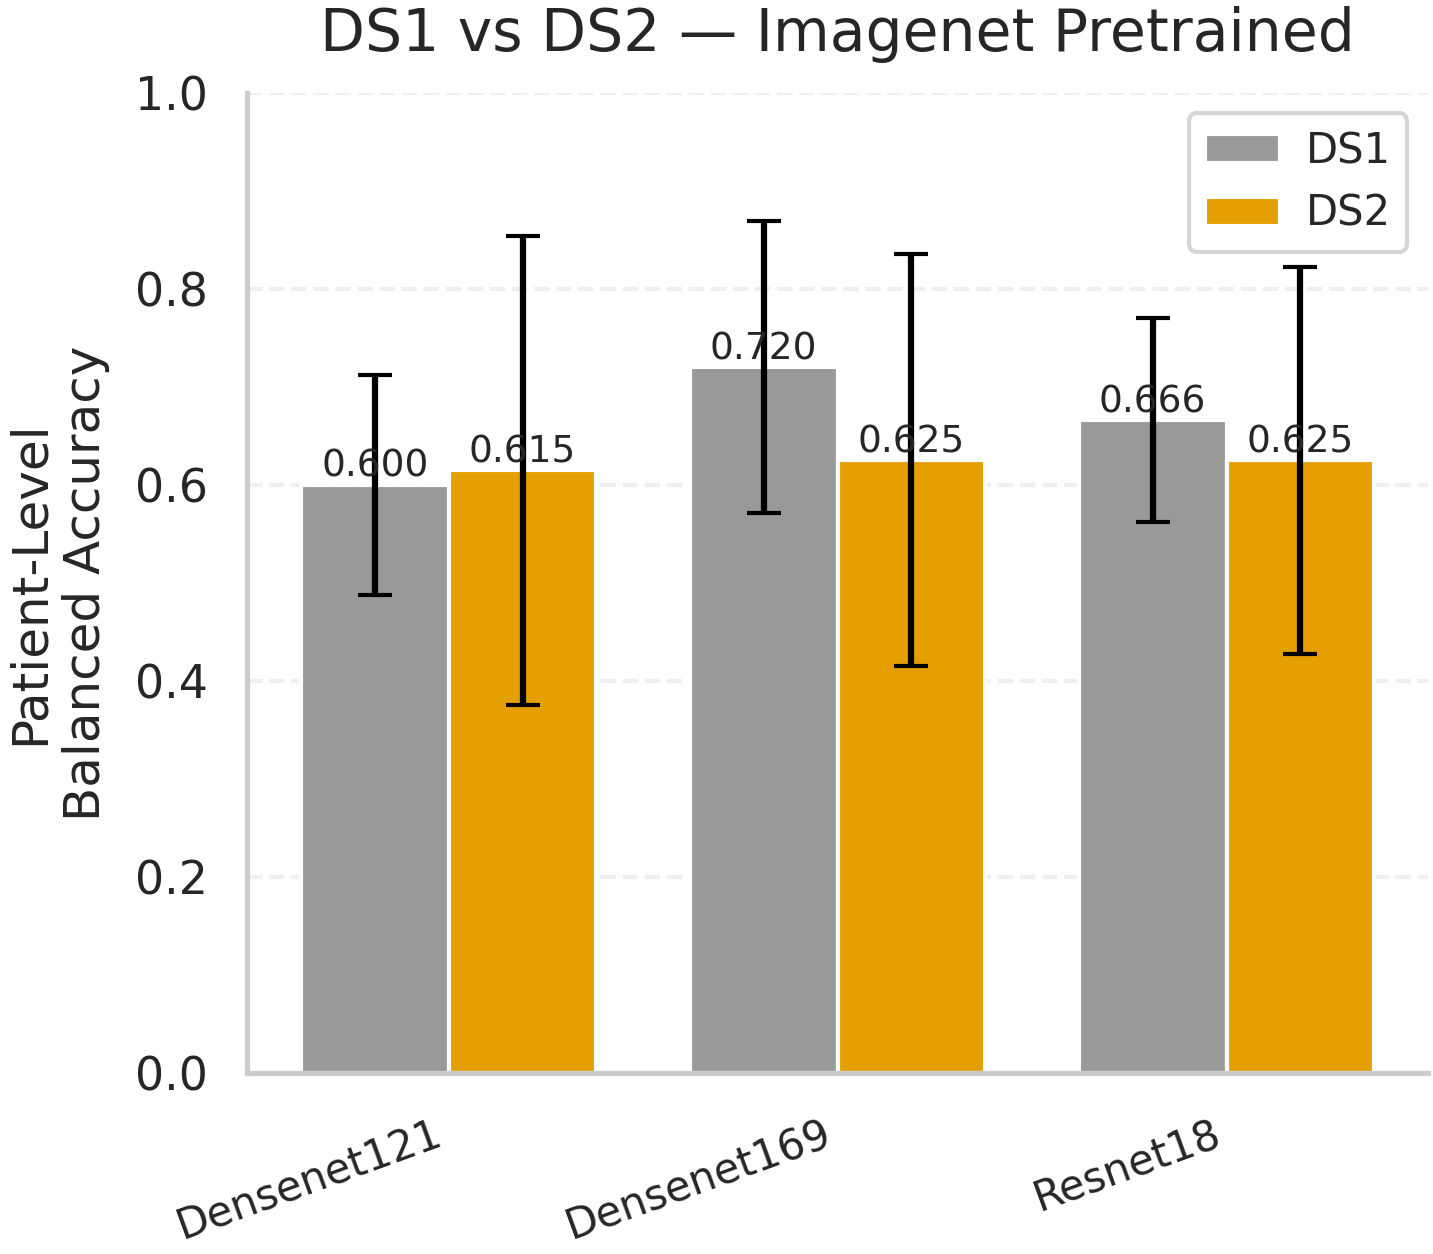

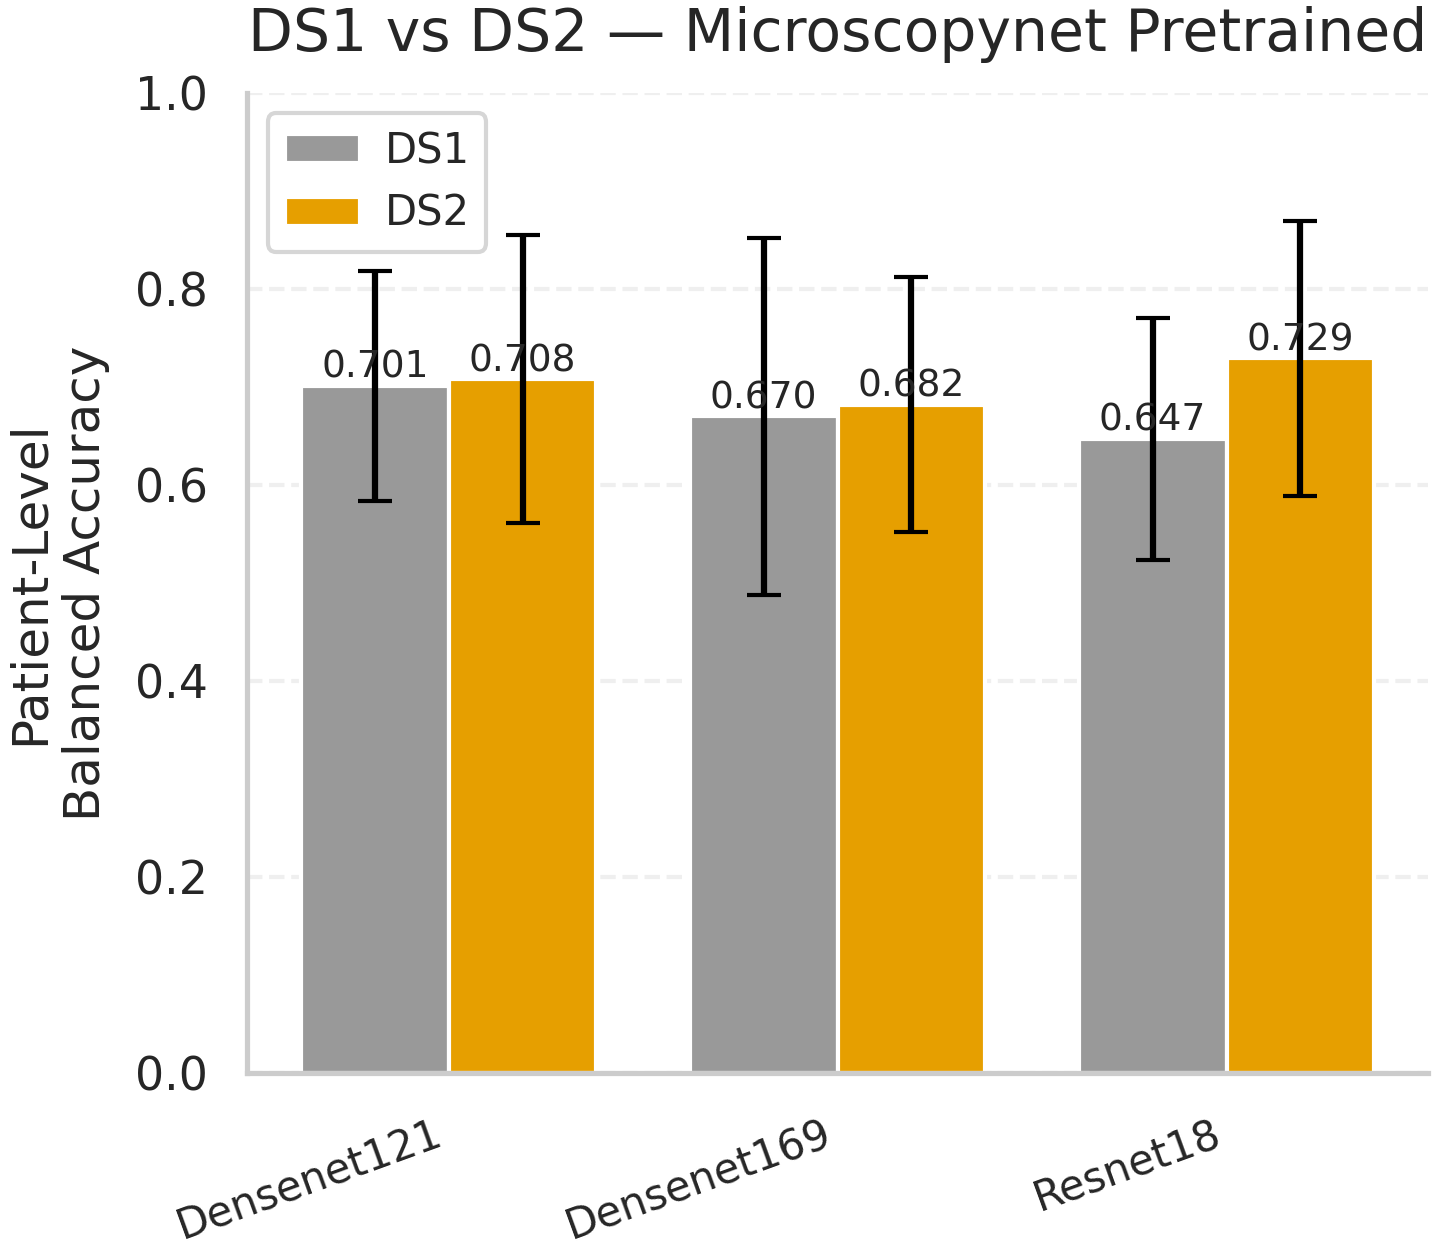

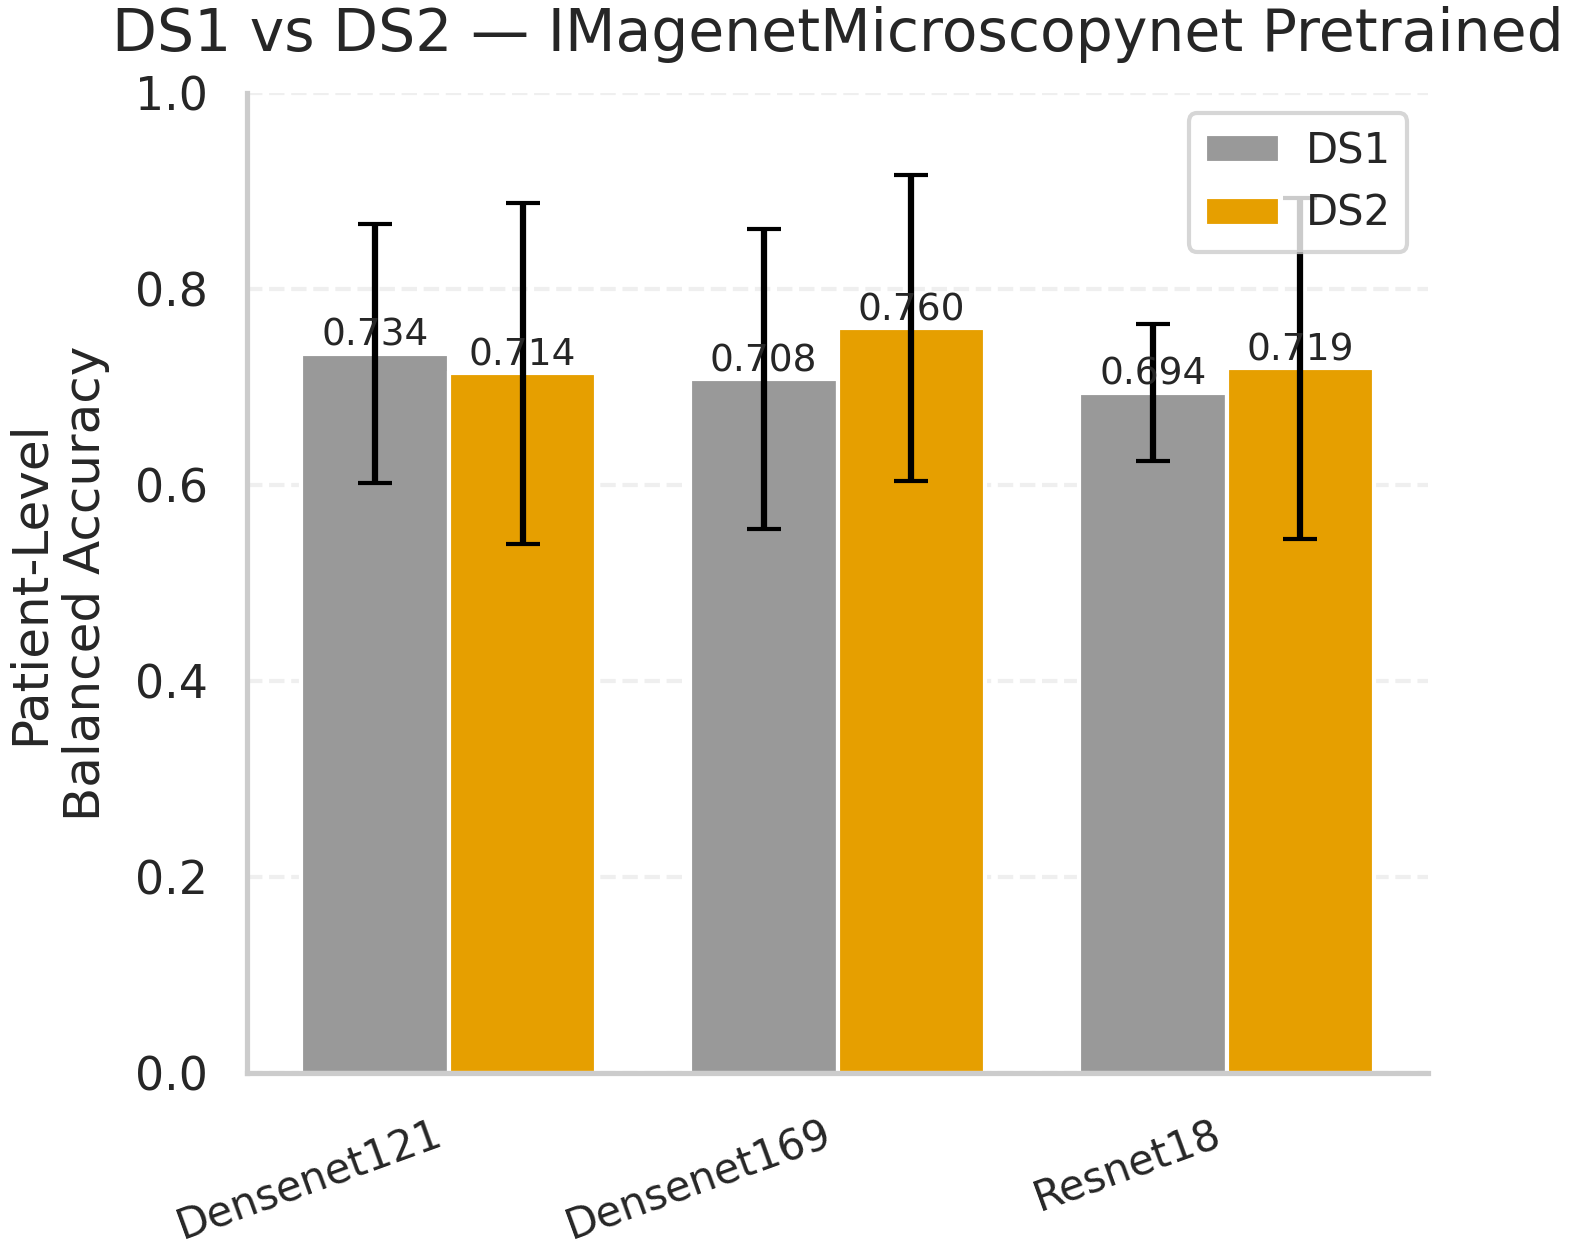

In [595]:
# from utils.mlflow_data_analyisis_helpers import extract_metrics_for_comparison, create_comparison_figure
#---------------------------------------------------------------------------------

metrics = [
    {
        "key": "patient_major_bal_acc",
        "col": "mean_patient_major_bal_acc",
        "std_col": "std_patient_major_bal_acc",
        "label": "Patient-Level\nBalanced Accuracy",
    },
    {
        "key": "patient_major_mcc",
        "col": "mean_patient_major_mcc",
        "std_col": "std_patient_major_mcc",
        "label": "Patient-Level\nMCC",
    },
    {
        "key": "patient_major_precision",
        "col": "mean_patient_major_precision",
        "std_col": "std_patient_major_precision",
        "label": "Patient-Level\nPrecision",
    },
    {
        "key": "patient_major_recall",
        "col": "mean_patient_major_recall",
        "std_col": "std_patient_major_recall",
        "label": "Patient-Level\nRecall",
    },
]


#------- imagenet pretrained ---------
res = extract_metrics_for_comparison(
    df_ds1=df_ds1_msap_pretrained_imagenet,
    df_ds2=df_ds2_msap_pretrained_imagenet,
    task_name="PD vs MSA-P",
    metrics=metrics,
    model_col="model_name",
)

output_path = create_comparison_figure(
    results=res,
    metric_key="patient_major_bal_acc",
    title="DS1 vs DS2 — Imagenet Pretrained",
    filename="cmp_ds1_ds2_bac_by_model_imagenet.png",
    ylim=(0, 1),
)

#------- microscopy net pretrained ---------
res = extract_metrics_for_comparison(
    df_ds1=df_ds1_msap_pretrained_microscopy,
    df_ds2=df_ds2_msap_pretrained_microscopy,
    task_name="PD vs MSA-P",
    metrics=metrics,
    model_col="model_name",
)

output_path = create_comparison_figure(
    results=res,
    metric_key="patient_major_bal_acc",
    title="DS1 vs DS2 — Microscopynet Pretrained",
    filename="cmp_ds1_ds2_bac_by_model_microscopy.png",
    ylim=(0, 1),
)
#--------- imagenet microscopynet pretrained ---------
res = extract_metrics_for_comparison(
    df_ds1=df_ds1_msap_pretrained_imagenet_microscopynet,
    df_ds2=df_ds2_msap_pretrained_imagenet_microscopynet,
    task_name="PD vs MSA-P",
    metrics=metrics,
    model_col="model_name",
)

output_path = create_comparison_figure(
    results=res,
    metric_key="patient_major_bal_acc",
    title="DS1 vs DS2 — IMagenetMicroscopynet Pretrained",
    filename="cmp_ds1_ds2_bac_by_model_imagenet_microscopy.png",
    ylim=(0, 1),
)
# --------------------------------------
# # ds1 vs ds2 msa not pretrained
# res = extract_metrics_for_comparison(
#     df_ds1=df_ds1_msa_3c_notpt,
#     df_ds2=df_ds2_msa_3c_notpt,
#     task_name="PD vs MSA",
#     metrics=metrics,
#     model_col="model_name",
# )
# output_path = create_comparison_figure(
#     results=res,
#     metric_key="patient_major_bal_acc",
#     title="DS1 vs DS2 — MSA 3c Not Pretrained",
#     filename="cmp_ds1_ds2_bac_by_model_msa_3c_notpt.png",
#     ylim=(0, 1),
# )
# ds1 vs ds2 msa 4c not pretrained---------------------
# res = extract_metrics_for_comparison(
#     df_ds1=df_ds1_msa_4c_notpt,
#     df_ds2=df_ds2_msa_4c_notpt,
#     task_name="PD vs MSA",
#     metrics=metrics,
#     model_col="model_name",
# )
# output_path = create_comparison_figure(
#     results=res,
#     metric_key="patient_major_bal_acc",
#     title="DS1 vs DS2 — MSA 4c Not Pretrained",
#     filename="cmp_ds1_ds2_bac_by_model_msa_4c_notpt.png",
#     ylim=(0, 1),
# )
#--------------------------------------
# ds1 vs ds2 3c msap not pretrained
# res = extract_metrics_for_comparison(
#     df_ds1=df_ds1_msap_notpt_3c,
#     df_ds2=df_ds2_msap_notpt_3c,
#     task_name="PD vs MSA",
#     metrics=metrics,
#     model_col="model_name",
# )
# output_path = create_comparison_figure(
#     results=res,
#     metric_key="patient_major_bal_acc",
#     title="DS1 vs DS2 — MSAP 3c Not Pretrained",
#     filename="cmp_ds1_ds2_bac_by_model_msap_3c_notpt.png",
#     ylim=(0, 1),
# )
# ------------------------------------------------------
# ds1 vs ds2 msap 4c not pretrained
# res = extract_metrics_for_comparison(
#     df_ds1=df_ds1_msap_notpt_4c,
#     df_ds2=df_ds2_msap_notpt_4c,
#     task_name="PD vs MSAP",
#     metrics=metrics,
#     model_col="model_name",
# )
# output_path = create_comparison_figure(
#     results=res,
#     metric_key="patient_major_bal_acc",
#     title="DS1 vs DS2 — MSAP 4c Not Pretrained",
#     filename="cmp_ds1_ds2_bac_by_model_msap_4c_notpt.png",
#     ylim=(0, 1),
# )
#--------------------------------------
# ds1 vs ds2 msap not pretrained
# res = extract_metrics_for_comparison(
#     df_ds1=df_ds1_msap_notpt,
#     df_ds2=df_ds2_msap_notpt,
#     task_name="PD vs MSA",
#     metrics=metrics,
#     model_col="model_name",
#)
#--------------------------------------
# output_path = create_comparison_figure(
#     results=res,
#     metric_key="patient_major_bal_acc",
#     title="DS1 vs DS2 — Balanced Accuracy by Architecture",
#     filename="cmp_ds1_ds2_bal_acc_by_model.png",
#     ylim=(0, 1),
# )
#-----------------------------------------------
# output_path = create_comparison_figure(
#     results=res,
#     metric_key="patient_major_mcc",
#     title="DS1 vs DS2 — MCC by Architecture",
#     filename="cmp_ds1_ds2_mcc_by_model.png",
#     ylim=(-1, 1),
# )

# from IPython.display import Image, display
# display(Image(output_path))

In [596]:
df_ds1_msa_pretrained.columns.to_list()

['experiment_name',
 'run_name',
 'dataset',
 'classes',
 'num_channels',
 'best_lr',
 'creation_date',
 'creation_time',
 'dropout_rate',
 'epochs',
 'freezed_layer_index',
 'intensity_augmentation_preset',
 'lr_discovery_folds',
 'mixup_alpha',
 'model_library',
 'model_name',
 'optimizer_name',
 'pretrained_weights',
 'test_counts',
 'test_pat_ids_for_best_fold',
 'test_pat_ids_per_fold',
 'total_params',
 'train_counts',
 'trainable_params',
 'transfer_learning',
 'val_counts',
 'weight_decay',
 'exec_time_min',
 'mean_patient_major_bal_acc',
 'mean_patient_major_mcc',
 'mean_patient_major_precision',
 'mean_patient_major_recall',
 'mean_patient_soft_bal_acc',
 'mean_patient_soft_mcc',
 'mean_patient_soft_precision',
 'mean_patient_soft_recall',
 'mean_test_accuracy',
 'mean_test_auc',
 'mean_test_balanced_acc',
 'mean_test_f1',
 'mean_test_mcc',
 'mean_test_precision',
 'mean_test_recall',
 'std_patient_major_bal_acc',
 'std_patient_major_mcc',
 'std_patient_major_precision',
 'st

In [597]:
df_ds2_msap_notpt

,experiment_name,run_name,dataset,classes,num_channels,best_lr,creation_date,creation_time,dropout_rate,epochs,freezed_layer_index,intensity_augmentation_preset,lr_discovery_folds,mixup_alpha,model_library,model_name,optimizer_name,pretrained_weights,test_counts,test_pat_ids_for_best_fold,test_pat_ids_per_fold,total_params,train_counts,trainable_params,transfer_learning,val_counts,weight_decay,exec_time_min,mean_patient_major_bal_acc,mean_patient_major_mcc,mean_patient_major_precision,mean_patient_major_recall,mean_patient_soft_bal_acc,mean_patient_soft_mcc,mean_patient_soft_precision,mean_patient_soft_recall,mean_test_accuracy,mean_test_auc,mean_test_balanced_acc,mean_test_f1,mean_test_mcc,mean_test_precision,mean_test_recall,std_patient_major_bal_acc,std_patient_major_mcc,std_patient_major_precision,std_patient_major_recall,std_patient_soft_bal_acc,std_patient_soft_mcc,std_patient_soft_precision,std_patient_soft_recall,std_test_accuracy,std_test_auc,std_test_balanced_acc,std_test_f1,std_test_mcc,std_test_precision,std_test_recall,patient_major_bal_acc_formatted,patient_major_mcc_formatted,patient_major_precision_formatted,patient_major_recall_formatted,patient_soft_bal_acc_formatted,patient_soft_mcc_formatted,patient_soft_precision_formatted,patient_soft_recall_formatted
0,DS2_3c_MSA-P_vs_PD_supervised,Densenet121_oversamp_torchvision_11-01_at:18-4...,DS2,MSA-P vs PD,3,1.9906996673933362e-05,11-01,18:45:38,0.2,150,None,light,4,0,torchvision,Densenet121,Adam,imagenet,70,NaN,"{0: array(['5776', '6008', '6060', '6258', '63...",6955906,"{0: 410, 1: 418, 2: 405, 3: 400, 4: 387, 5: 43...",6955906,False,"{0: 59, 1: 70, 2: 60, 3: 95, 4: 101, 5: 67, 6:...",1e-4,187.475,0.818,0.65,0.778,0.969,0.802,0.621,0.753,0.969,0.803,0.851,0.8,0.827,0.607,0.761,0.918,0.141,0.287,0.109,0.083,0.126,0.261,0.072,0.083,0.11,0.123,0.129,0.073,0.252,0.099,0.087,0.818 ± 0.141,0.650 ± 0.287,0.778 ± 0.109,0.969 ± 0.083,0.802 ± 0.126,0.621 ± 0.261,0.753 ± 0.072,0.969 ± 0.083


In [598]:
df_ds1_msap_notpt.head()

,experiment_name,run_name,dataset,classes,num_channels,best_lr,creation_date,creation_time,dropout_rate,epochs,freezed_layer_index,intensity_augmentation_preset,lr_discovery_folds,mixup_alpha,model_library,model_name,optimizer_name,pretrained_weights,test_counts,test_pat_ids_for_best_fold,test_pat_ids_per_fold,total_params,train_counts,trainable_params,transfer_learning,val_counts,weight_decay,exec_time_min,mean_patient_major_bal_acc,mean_patient_major_mcc,mean_patient_major_precision,mean_patient_major_recall,mean_patient_soft_bal_acc,mean_patient_soft_mcc,mean_patient_soft_precision,mean_patient_soft_recall,mean_test_accuracy,mean_test_auc,mean_test_balanced_acc,mean_test_f1,mean_test_mcc,mean_test_precision,mean_test_recall,std_patient_major_bal_acc,std_patient_major_mcc,std_patient_major_precision,std_patient_major_recall,std_patient_soft_bal_acc,std_patient_soft_mcc,std_patient_soft_precision,std_patient_soft_recall,std_test_accuracy,std_test_auc,std_test_balanced_acc,std_test_f1,std_test_mcc,std_test_precision,std_test_recall,patient_major_bal_acc_formatted,patient_major_mcc_formatted,patient_major_precision_formatted,patient_major_recall_formatted,patient_soft_bal_acc_formatted,patient_soft_mcc_formatted,patient_soft_precision_formatted,patient_soft_recall_formatted
84,DS1_4c_MSA-P_vs_PD_supervised,ViT_monai_10-30_at:12-06-53,DS1,MSA-P vs PD,4,0.00012207764786954147,10-30,12:06:53,0.2,450,None,light,4,0,monai,ViT,AdamW,None,"{'fold_0': 8, 'fold_1': 8, 'fold_2': 8, 'fold_...",NaN,"{0: array(['5776', '6008', '6060', '6258', '63...",1054978,"{0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...",1054978,False,"{0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...",1e-5,35.312,0.682,0.389,0.676,0.833,0.682,0.402,0.649,0.896,0.686,0.749,0.672,0.739,0.368,0.663,0.849,0.153,0.309,0.147,0.182,0.149,0.337,0.117,0.137,0.128,0.157,0.139,0.099,0.285,0.118,0.112,0.682 ± 0.153,0.389 ± 0.309,0.676 ± 0.147,0.833 ± 0.182,0.682 ± 0.149,0.402 ± 0.337,0.649 ± 0.117,0.896 ± 0.137
85,DS1_4c_MSA-P_vs_PD_supervised,Resnet18_oversamp_monai_10-30_at:11-31-10,DS1,MSA-P vs PD,4,9.77832594580138e-06,10-30,11:31:10,0.2,210,None,light,4,0,monai,Resnet18,AdamW,None,14,['5745' '5753' '5996' '6375' '6690' '7114' '71...,"{0: array(['5776', '6008', '6060', '6258', '63...",11181570,"{0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...",11181570,False,"{0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...",1e-4,46.095,0.792,0.593,0.781,0.865,0.812,0.642,0.790,0.906,0.773,0.815,0.775,0.795,0.562,0.771,0.839,0.172,0.344,0.190,0.138,0.132,0.261,0.134,0.121,0.124,0.139,0.122,0.108,0.247,0.145,0.120,0.792 ± 0.172,0.593 ± 0.344,0.781 ± 0.190,0.865 ± 0.138,0.812 ± 0.132,0.642 ± 0.261,0.790 ± 0.134,0.906 ± 0.121
86,DS1_4c_MSA-P_vs_PD_supervised,Densenet169_oversamp_monai_10-30_at:10-44-44,DS1,MSA-P vs PD,4,0.00012207764786954147,10-30,10:44:44,0.2,210,None,light,4,0,monai,Densenet169,AdamW,None,14,['5717' '5767' '6337' '6366' '6657' '7132' '72...,"{0: array(['5776', '6008', '6060', '6258', '63...",12490946,"{0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...",12490946,False,"{0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...",1e-4,32.821,0.792,0.592,0.777,0.833,0.729,0.483,0.698,0.792,0.750,0.781,0.750,0.764,0.516,0.733,0.812,0.174,0.350,0.205,0.182,0.164,0.343,0.196,0.243,0.139,0.141,0.134,0.144,0.278,0.157,0.165,0.792 ± 0.174,0.592 ± 0.350,0.777 ± 0.205,0.833 ± 0.182,0.729 ± 0.164,0.483 ± 0.343,0.698 ± 0.196,0.792 ± 0.243
87,DS1_4c_MSA-P_vs_PD_supervised,Densenet121_oversamp_monai_10-30_at:10-11-35,DS1,MSA-P vs PD,4,0.00012207764786954147,10-30,10:11:35,0.2,210,None,light,4,0,monai,Densenet121,AdamW,None,14,NaN,"{0: array(['5776', '6008', '6060', '6258', '63...",6959042,"{0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...",6959042,False,"{0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...",1e-4,28.708,0.818,0.650,0.790,0.865,0.776,0.583,0.758,0.823,0.760,0.796,0.763,0.771,0.538,0.763,0.802,0.141,0.287,0.154,0.186,0.108,0.222,0.132,0.252,0.084,0.087,0.084,0.087,0.179,0.128,0.133,0.818 

generate  msa vs pd , and msap vs pd aggregated variables ie the values are the mean of the metrcis shown over different architecture between the 2 different datasets

In [599]:
# Import plotting libraries and StyleManager and create the output directory to store images
#--------------------------------------------
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
# Add parent directory to path to import style module
# Try adding parent directory if style module not found
try:
    from style.style_manager import StyleManager
except ImportError:
    # If import fails, add parent directory to path
    current_dir = os.getcwd()
    if os.path.basename(current_dir) == 'notebooks':
        project_root = os.path.dirname(current_dir)
        sys.path.insert(0, project_root)
    else:
        # Try going up one level
        parent_dir = os.path.dirname(current_dir)
        sys.path.insert(0, parent_dir)
    from style.style_manager import StyleManager


# Determine project root and initialize style with correct paths
current_dir = os.getcwd()
if os.path.basename(current_dir) == 'notebooks':
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

mplstyle_path = os.path.join(project_root, 'style', 'thesis_style.mplstyle')
sm = StyleManager(mplstyle_path=mplstyle_path)
sm.activate()

# Create output directory if it doesn't exist
output_dir = "images/image_analysis"
os.makedirs(output_dir, exist_ok=True)

## Patients splits

In [600]:
# Import plotting libraries and StyleManager and create the output directory to store images
#--------------------------------------------
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
# Add parent directory to path to import style module
# Try adding parent directory if style module not found
try:
    from style.style_manager import StyleManager
except ImportError:
    # If import fails, add parent directory to path
    current_dir = os.getcwd()
    if os.path.basename(current_dir) == 'notebooks':
        project_root = os.path.dirname(current_dir)
        sys.path.insert(0, project_root)
    else:
        # Try going up one level
        parent_dir = os.path.dirname(current_dir)
        sys.path.insert(0, parent_dir)
    from style.style_manager import StyleManager


# Determine project root and initialize style with correct paths
current_dir = os.getcwd()
if os.path.basename(current_dir) == 'notebooks':
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

mplstyle_path = os.path.join(project_root, 'style', 'thesis_style.mplstyle')
sm = StyleManager(mplstyle_path=mplstyle_path)
sm.activate()

# Create output directory if it doesn't exist
output_dir = "images/image_analysis"
os.makedirs(output_dir, exist_ok=True)

Figure saved to images/01_patient_distribution_pd_vs_msa.png


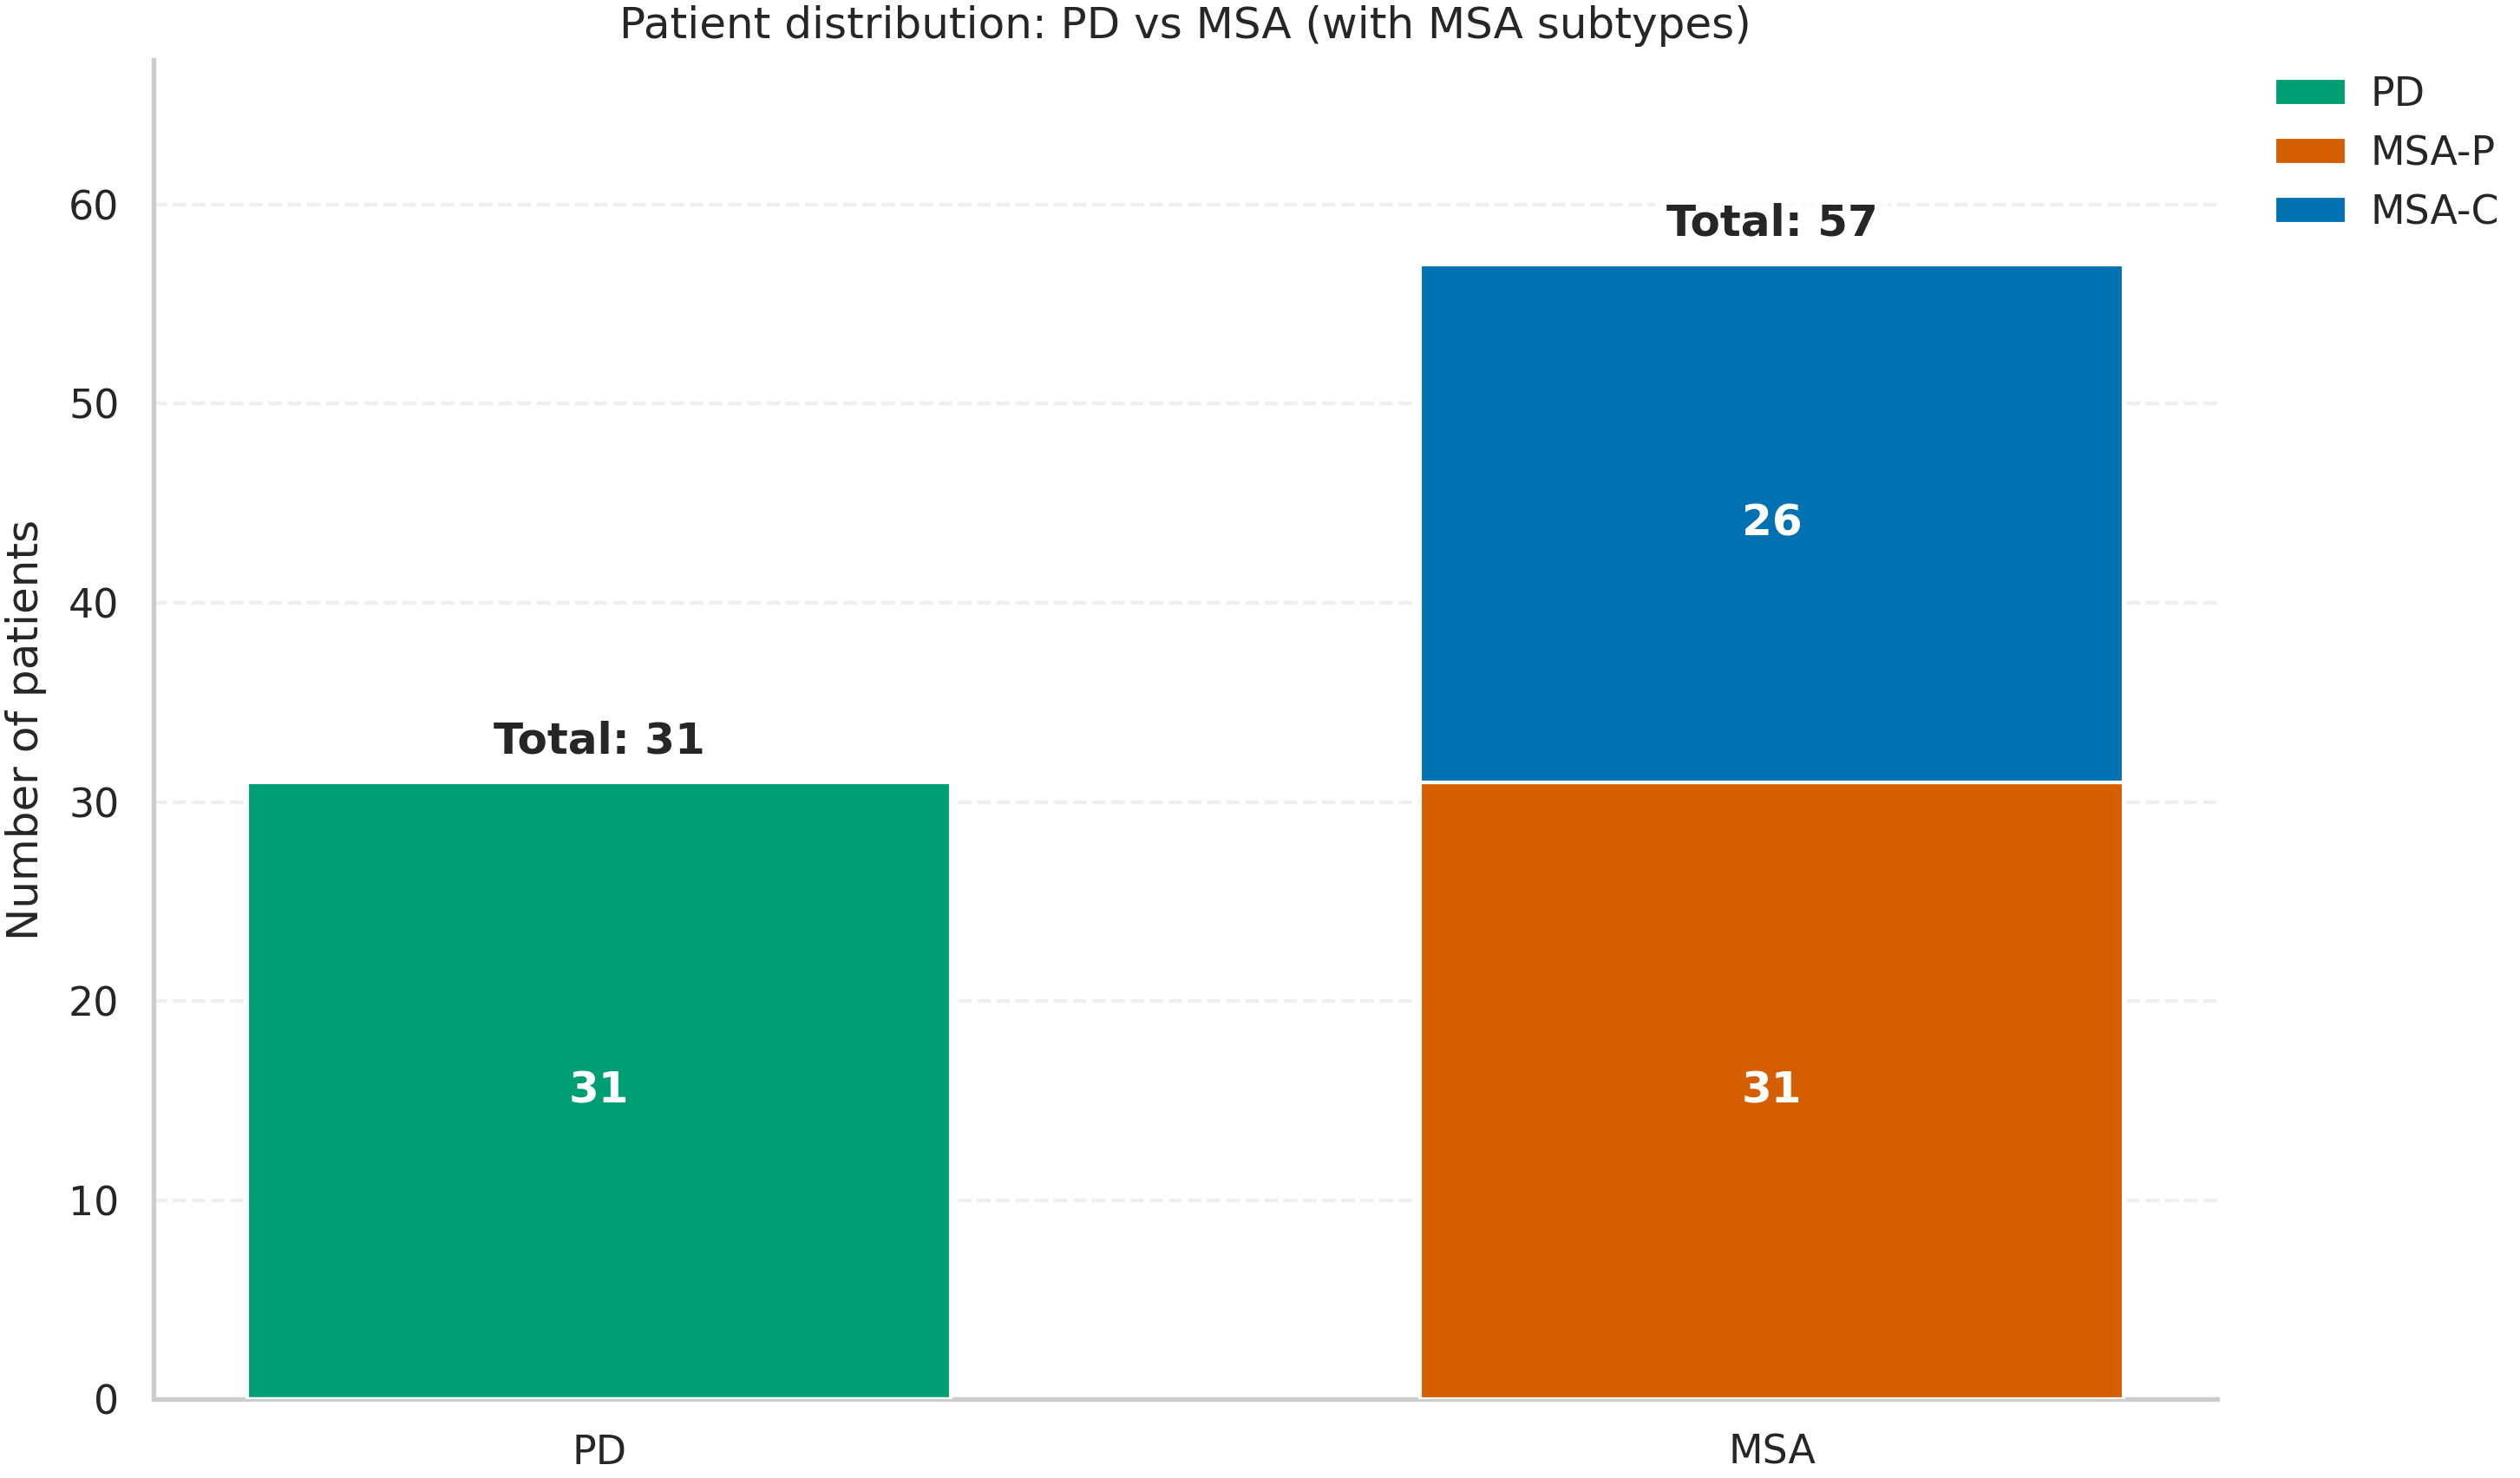

In [ ]:

# Data
pd_count = 31
msa_c_count = 26
msa_p_count = 31
msa_total = msa_c_count + msa_p_count

# Consistent class colors (Okabe–Ito)
COLOR_PD    = sm.palette[2]  # blue
COLOR_MSA_P = sm.palette[1]  # orange
COLOR_MSA_C = sm.palette[0]  # magenta

# Figure (match your original size)
fig, ax = plt.subplots(figsize=(10, 6))

# Categories and data – MSA-P bottom, MSA-C top
categories = ['PD', 'MSA']
pd_data   = [pd_count, 0]
msa_p_dt  = [0, msa_p_count]
msa_c_dt  = [0, msa_c_count]

bar_width = 0.6
x_pos = np.arange(len(categories))

# Bars
bars1 = ax.bar(x_pos, pd_data,   bar_width, label='PD',    color=COLOR_PD,    zorder=3)
bars2 = ax.bar(x_pos, msa_p_dt,  bar_width, label='MSA-P', color=COLOR_MSA_P, zorder=3)
bars3 = ax.bar(x_pos, msa_c_dt,  bar_width, bottom=msa_p_dt, label='MSA-C', color=COLOR_MSA_C, zorder=3)

# Labels & title
ax.set_ylabel('Number of patients')
ax.set_title('Patient distribution: PD vs MSA (with MSA subtypes)')
ax.set_xticks(x_pos)
ax.set_xticklabels(categories)

# Legend outside (no overlap with totals)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), borderaxespad=0., frameon=False)

# Value labels in bars
for i, (bar1, bar2, bar3) in enumerate(zip(bars1, bars2, bars3)):
    if bar1.get_height() > 0:
        ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height()/2,
                f'{int(bar1.get_height())}', ha='center', va='center',
                fontweight='bold', color='white')
    if bar2.get_height() > 0:
        ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height()/2,
                f'{int(bar2.get_height())}', ha='center', va='center',
                fontweight='bold', color='white')
    if bar3.get_height() > 0:
        ax.text(bar3.get_x() + bar3.get_width()/2, bar2.get_height() + bar3.get_height()/2,
                f'{int(bar3.get_height())}', ha='center', va='center',
                fontweight='bold', color='white')

# Totals above bars (with small white box for readability)
def total_label(x, y, txt):
    ax.text(x, y, txt, ha='center', va='bottom', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.8, edgecolor='none'))

total_label(x_pos[0], pd_count + 1.0,  f'Total: {pd_count}')
total_label(x_pos[1], msa_total + 1.0, f'Total: {msa_total}')

# Grid below bars
ax.set_ylim(0, max(pd_count, msa_total) * 1.18)
ax.grid(axis='y', alpha=0.3, linestyle='--', zorder=0)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
sm.savefig("images/01_patient_distribution_pd_vs_msa.png")
plt.show()

## train val test split


Data prepared for plotting (percentages):
split          Train  Validation       Test
dataset                                    
Dataset 1  74.846626   12.883436  12.269939
Dataset 2  72.626387   12.946979  14.426634
------------------------------
Figure saved to images/01_dataset_split_distribution.png
Plot generation complete. Figure saved to: images/01_dataset_split_distribution.png


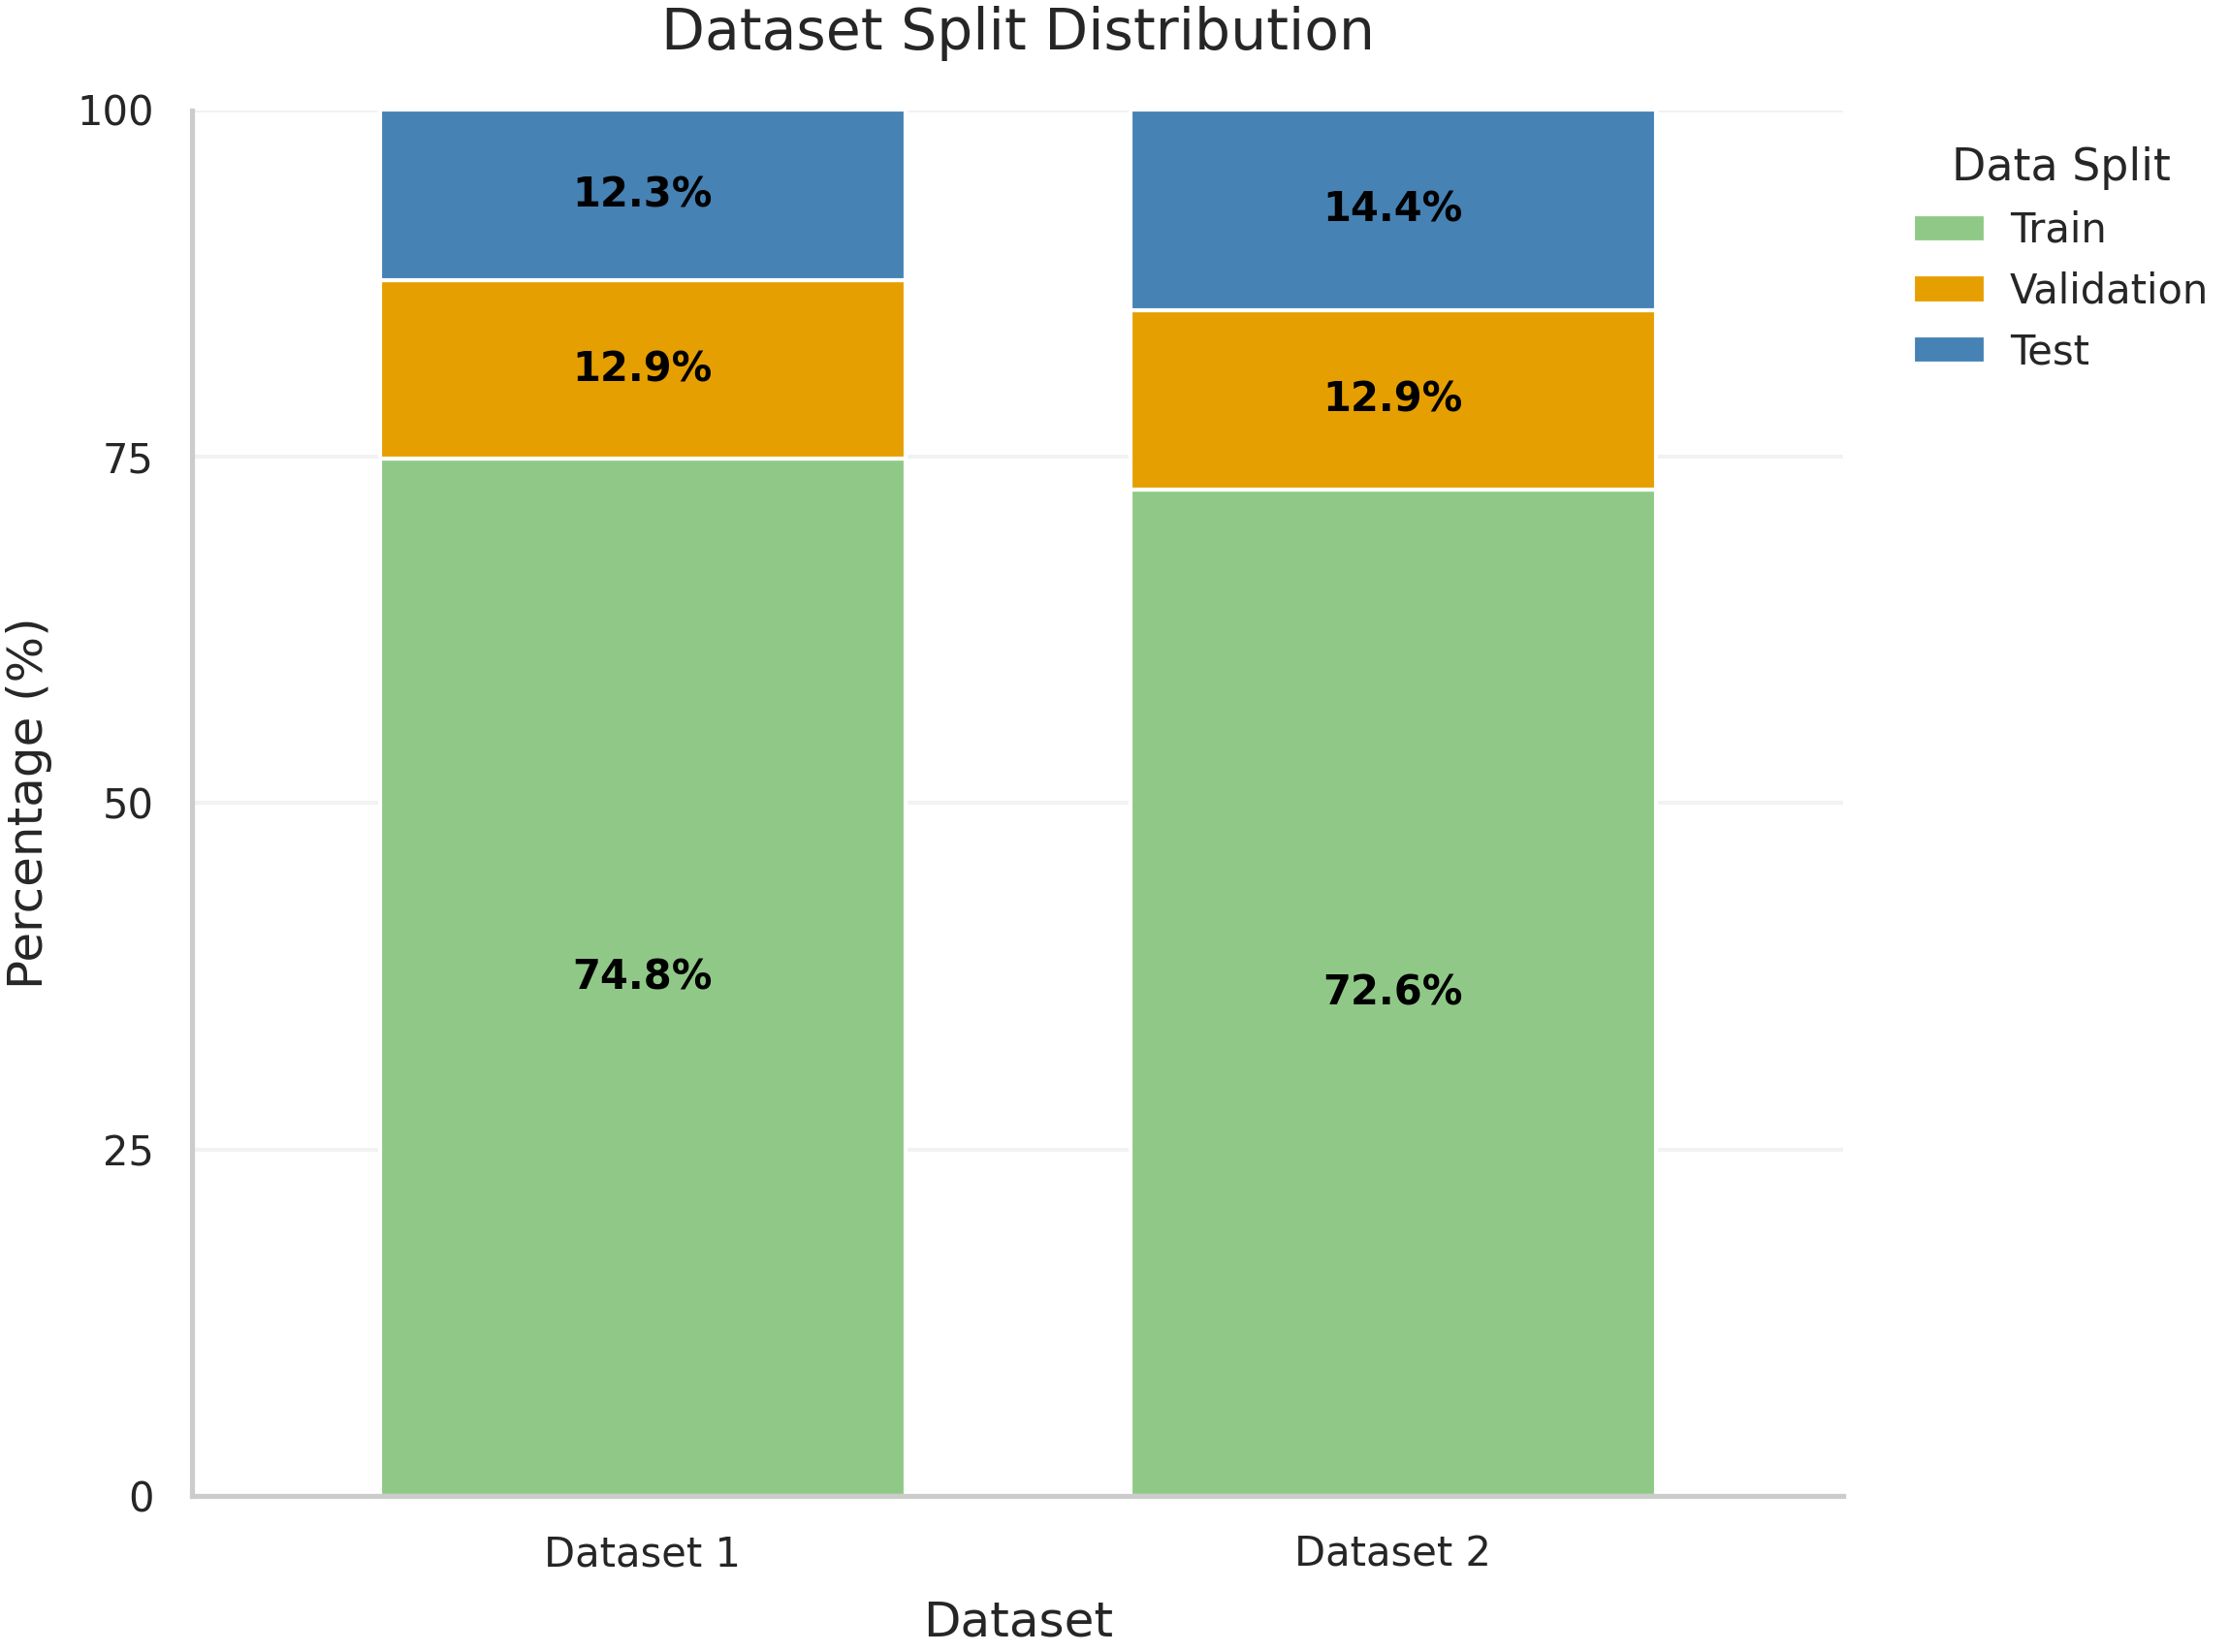

In [602]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Activate the thesis plot style
# This loads the .mplstyle and sets the default Okabe-Ito palette
try:
    # Set the default Seaborn theme using the style manager's palette
    sns.set_theme(style="whitegrid", palette=sm.palette)
except ImportError:
    print("Warning: StyleManager not found. Using default Matplotlib settings.")
    # Define fallback palette if StyleManager fails
    class MockStyleManager:
        def __init__(self):
            # Okabe–Ito palette
            self.palette = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', 
                            '#F0E442', '#56B4E9', '#E69F00', '#999999']
        def activate(self):
            plt.style.use('default')
        def savefig(self, fname, **kwargs):
            defaults = {'dpi': 300, 'bbox_inches': 'tight', 'transparent': True}
            defaults.update(kwargs)
            plt.savefig(fname, **defaults)
    
    sm = MockStyleManager()
    sm.activate()
    sns.set_theme(style="whitegrid", palette=sm.palette)


# 2. Input Data
data = [
    {"dataset": "Dataset 1", "split": "Train", "count": 122},
    {"dataset": "Dataset 1", "split": "Validation", "count": 21},
    {"dataset": "Dataset 1", "split": "Test", "count": 20},
    {"dataset": "Dataset 2", "split": "Train", "count": 589},
    {"dataset": "Dataset 2", "split": "Validation", "count": 105},
    {"dataset": "Dataset 2", "split": "Test", "count": 117},
]

# 3. Data Preparation (Convert counts to percentages)
df = pd.DataFrame(data)

# Calculate total counts per dataset to find percentages
df['total'] = df.groupby('dataset')['count'].transform('sum')
df['percentage'] = (df['count'] / df['total']) * 100

# Pivot the data for stacked bar plotting
df_pivot = df.pivot(index='dataset', columns='split', values='percentage')

# Ensure logical stacking order (Train -> Val -> Test)
split_order = ['Train', 'Validation', 'Test']
df_pivot = df_pivot[split_order]

print("Data prepared for plotting (percentages):")
print(df_pivot)
print("-" * 30)

# 4. Plot Generation (100% Stacked Bar)
fig, ax = plt.subplots(figsize=(8, 6))

colors = ['#90C987', '#E69F00', '#4682B4']

# Create the stacked bar plot
df_pivot.plot(kind='bar', stacked=True, color=colors, ax=ax, width=0.7)

# 5. Add Percentage Labels (Thesis Requirement)
# We must iterate through the bars to place text labels
bottom = pd.Series([0.0] * len(df_pivot), index=df_pivot.index)

for i, split in enumerate(split_order):
    values = df_pivot[split]
    
    # Iterate over each dataset (each bar)
    for j, (dataset_name, value) in enumerate(values.items()):
        
        # Only add a label if the segment is large enough (e.g., > 4%)
        if value > 4:
            # Calculate the vertical center of the segment
            y_pos = bottom[dataset_name] + (value / 2)
            label = f"{value:.1f}%"
            
            # Use white text for the first (dark blue) segment
            text_color = 'black' 
            
            ax.text(j, y_pos, label, 
                    ha='center', va='center', 
                    color=text_color, 
                    fontsize=10, 
                    fontweight='bold')
    
    # Update the bottom position for the next segment
    bottom += values

# 6. Styling and Formatting (Adhering to Guidelines)
ax.set_title("Dataset Split Distribution", fontsize=14, pad=15)
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.set_xlabel("Dataset", fontsize=12)

# Set Y-axis limits and ticks
ax.set_ylim(0, 100)
ax.set_yticks([0, 25, 50, 75, 100])
ax.tick_params(axis='both', which='major', labelsize=10)

# Format X-axis ticks
ax.set_xticklabels(df_pivot.index, rotation=0, ha='center')

# Format legend
ax.legend(title="Data Split", 
          bbox_to_anchor=(1.02, 1), 
          loc='upper left', 
          fontsize=10,
          title_fontsize=11)

# Remove top/right spines and vertical gridlines
sns.despine(ax=ax, top=True, right=True)
ax.grid(axis='x') # Keep horizontal gridlines

plt.tight_layout()

# 7. Save the figure using the StyleManager
save_path = "images/01_dataset_split_distribution.png"
sm.savefig(save_path)

print(f"Plot generation complete. Figure saved to: {save_path}")
plt.show()

Data prepared for plotting (Dataset 1 percentages):
              dataset  count  percentage
split                                   
Train       Dataset 1    122   74.846626
Validation  Dataset 1     21   12.883436
Test        Dataset 1     20   12.269939
------------------------------
Figure saved to images/02_dataset_split_ds1_donut.png
Plot generation complete. Figure saved to: images/02_dataset_split_ds1_donut.png


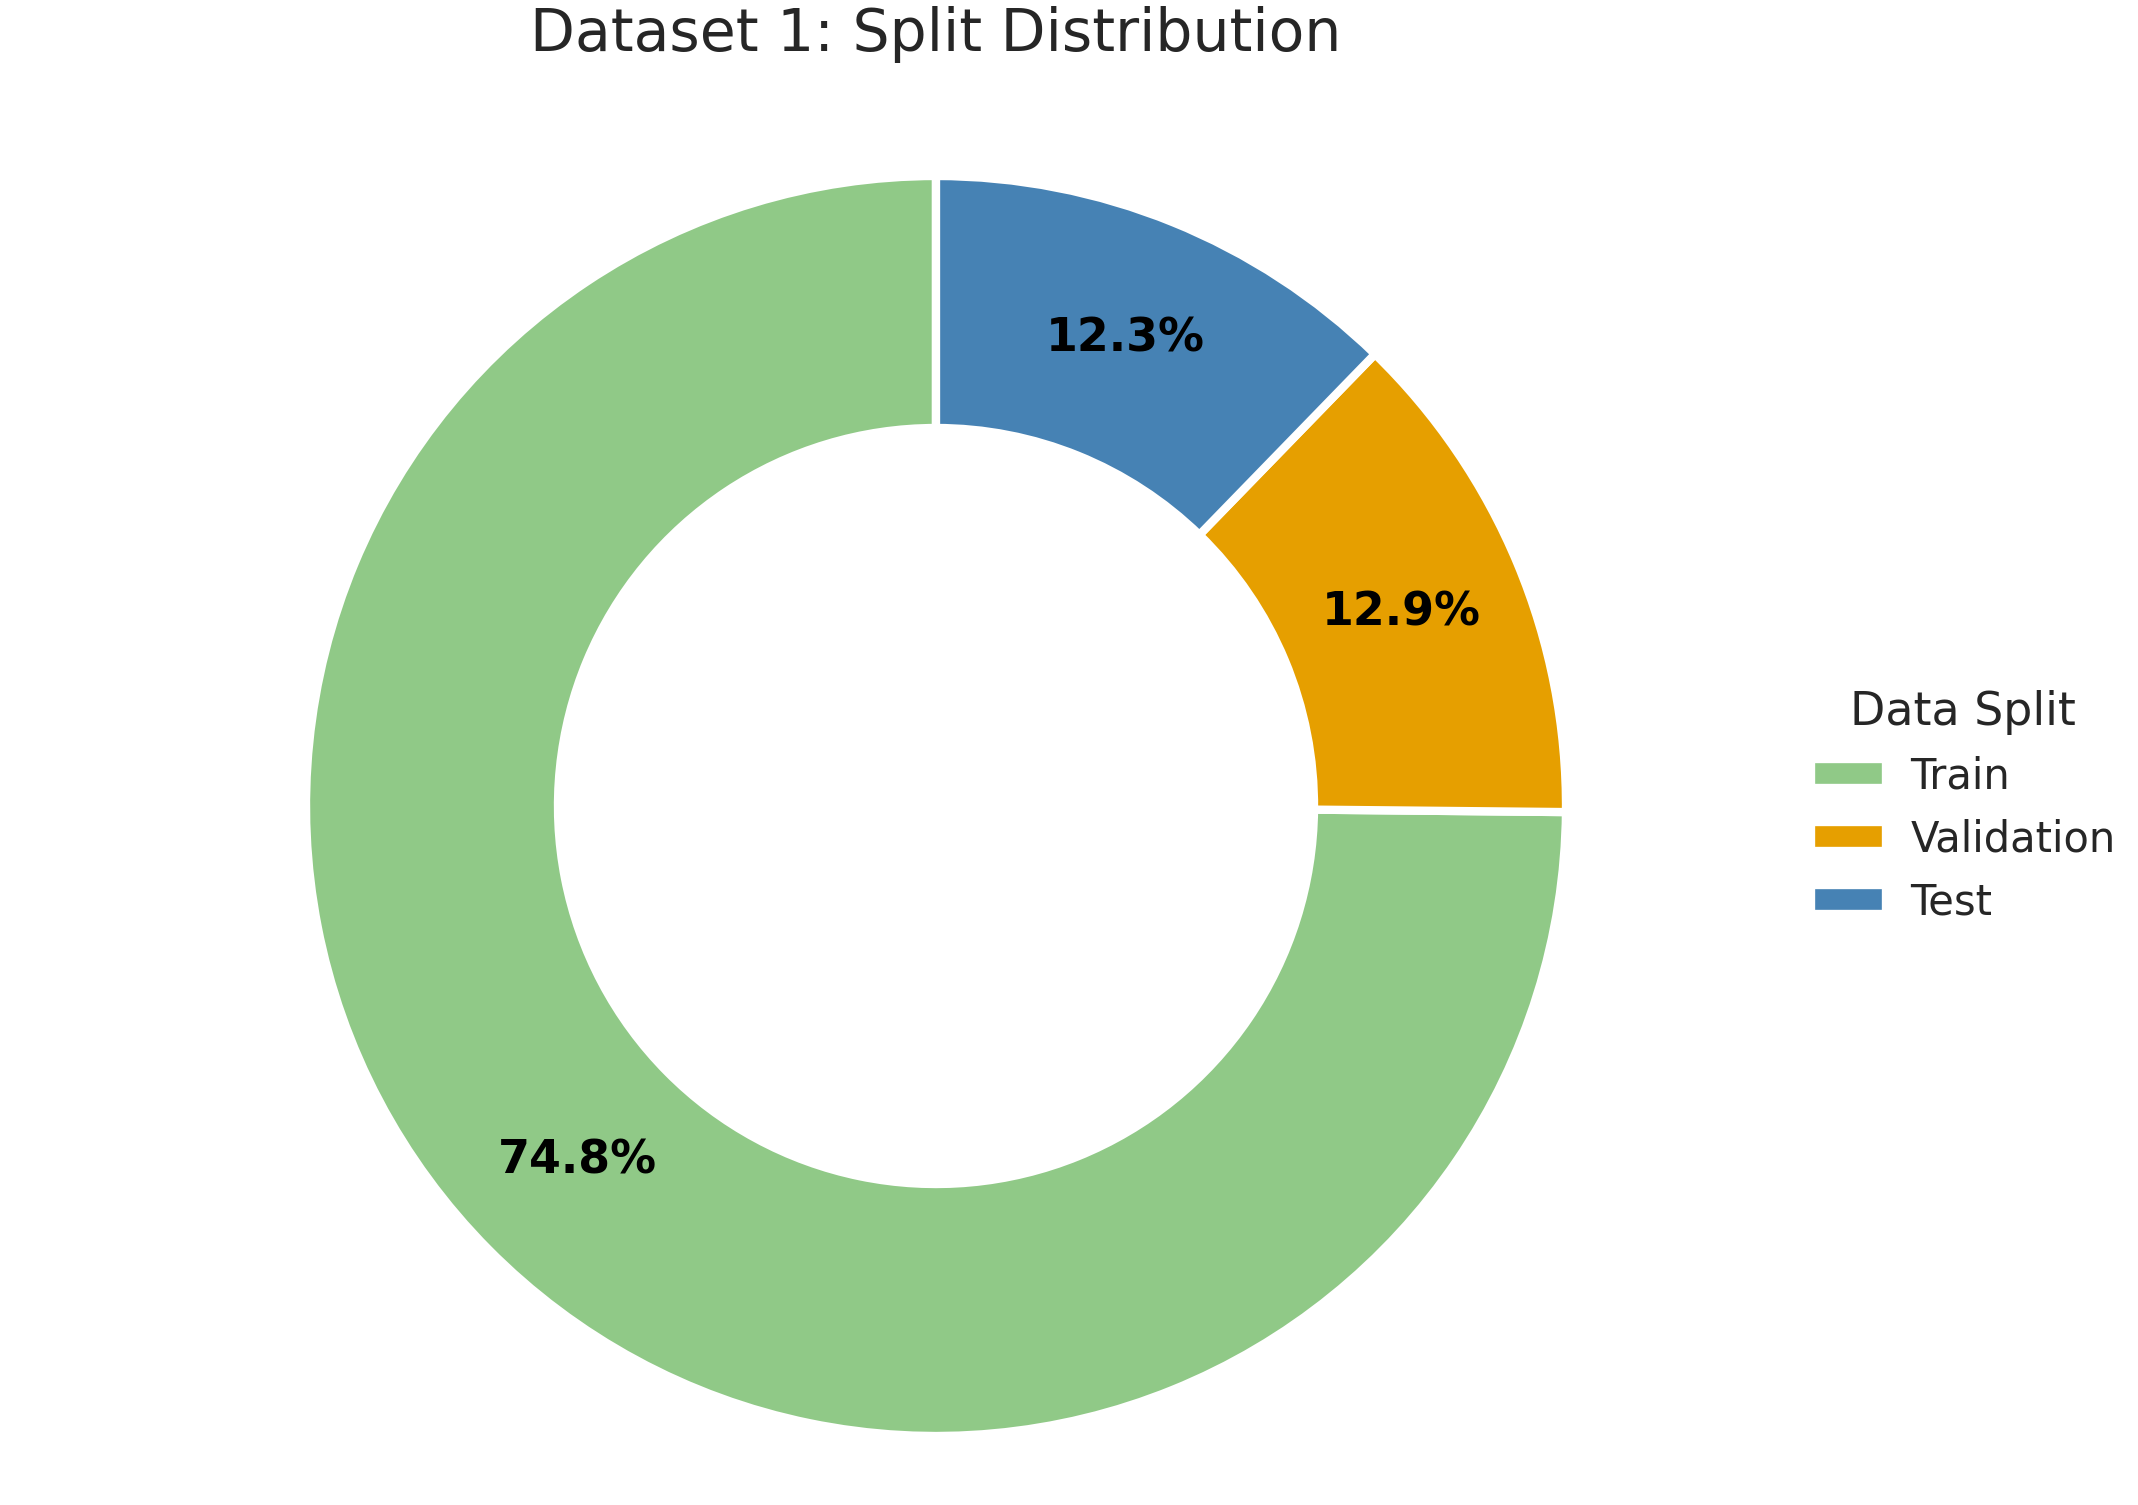

In [603]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from style.style_manager import StyleManager # Assuming style.style_manager.py exists


# 2. Input Data (Full)
data = [
    {"dataset": "Dataset 1", "split": "Train", "count": 122},
    {"dataset": "Dataset 1", "split": "Validation", "count": 21},
    {"dataset": "Dataset 1", "split": "Test", "count": 20},
    {"dataset": "Dataset 2", "split": "Train", "count": 589},
    {"dataset": "Dataset 2", "split": "Validation", "count": 105},
    {"dataset": "Dataset 2", "split": "Test", "count": 117},
]

# 3. Data Preparation (Filter for DS1 and calculate percentages)
df = pd.DataFrame(data)

# Filter for Dataset 1
df_ds1 = df[df['dataset'] == "Dataset 1"].copy()

# Calculate percentages
df_ds1['percentage'] = (df_ds1['count'] / df_ds1['count'].sum()) * 100

# Ensure logical order
split_order = ['Train', 'Validation', 'Test']
df_ds1 = df_ds1.set_index('split').reindex(split_order)

print("Data prepared for plotting (Dataset 1 percentages):")
print(df_ds1)
print("-" * 30)

# 4. Plot Generation (Donut Chart)
fig, ax = plt.subplots(figsize=(8, 6))

# Define sizes, labels, and the requested colors
sizes = df_ds1['percentage']
labels = df_ds1.index
colors = ['#90C987', '#E69F00', '#4682B4'] # Green, Orange, Blue

# Define the "donut" hole
wedgeprops = {'width': 0.4, 'edgecolor': 'w', 'linewidth': 2}

# Create the pie chart
patches, texts, autotexts = ax.pie(
    sizes, 
    autopct='%1.1f%%',  # Add percentage labels
    startangle=90,
    colors=colors,
    wedgeprops=wedgeprops,
    pctdistance=0.8 # Place percentage labels inside the donut
)

# 5. Styling and Formatting
ax.set_title("Dataset 1: Split Distribution", fontsize=14, pad=15)

# Style the percentage text (autopct) for readability
# We must use black text to contrast with the light green/orange colors
plt.setp(autotexts, size=11, weight="bold", color="black")

# Add a legend adhering to thesis style
ax.legend(
    patches, 
    labels, 
    title="Data Split", 
    loc="center left", 
    bbox_to_anchor=(0.95, 0.5), # Place legend outside the plot
    fontsize=10,
    title_fontsize=11
)

# Ensure the plot is circular
ax.axis('equal')

# 6. Save the figure
save_path = "images/02_dataset_split_ds1_donut.png"
sm.savefig(save_path)

print(f"Plot generation complete. Figure saved to: {save_path}")
plt.show()

In [604]:
df.head()

,dataset,split,count
0,Dataset 1,Train,122
1,Dataset 1,Validation,21
2,Dataset 1,Test,20
3,Dataset 2,Train,589
4,Dataset 2,Validation,105


Saving plot to images/03_ds1_msa_notpt_scatter.png...
Figure saved to images/03_ds1_msa_notpt_scatter.png


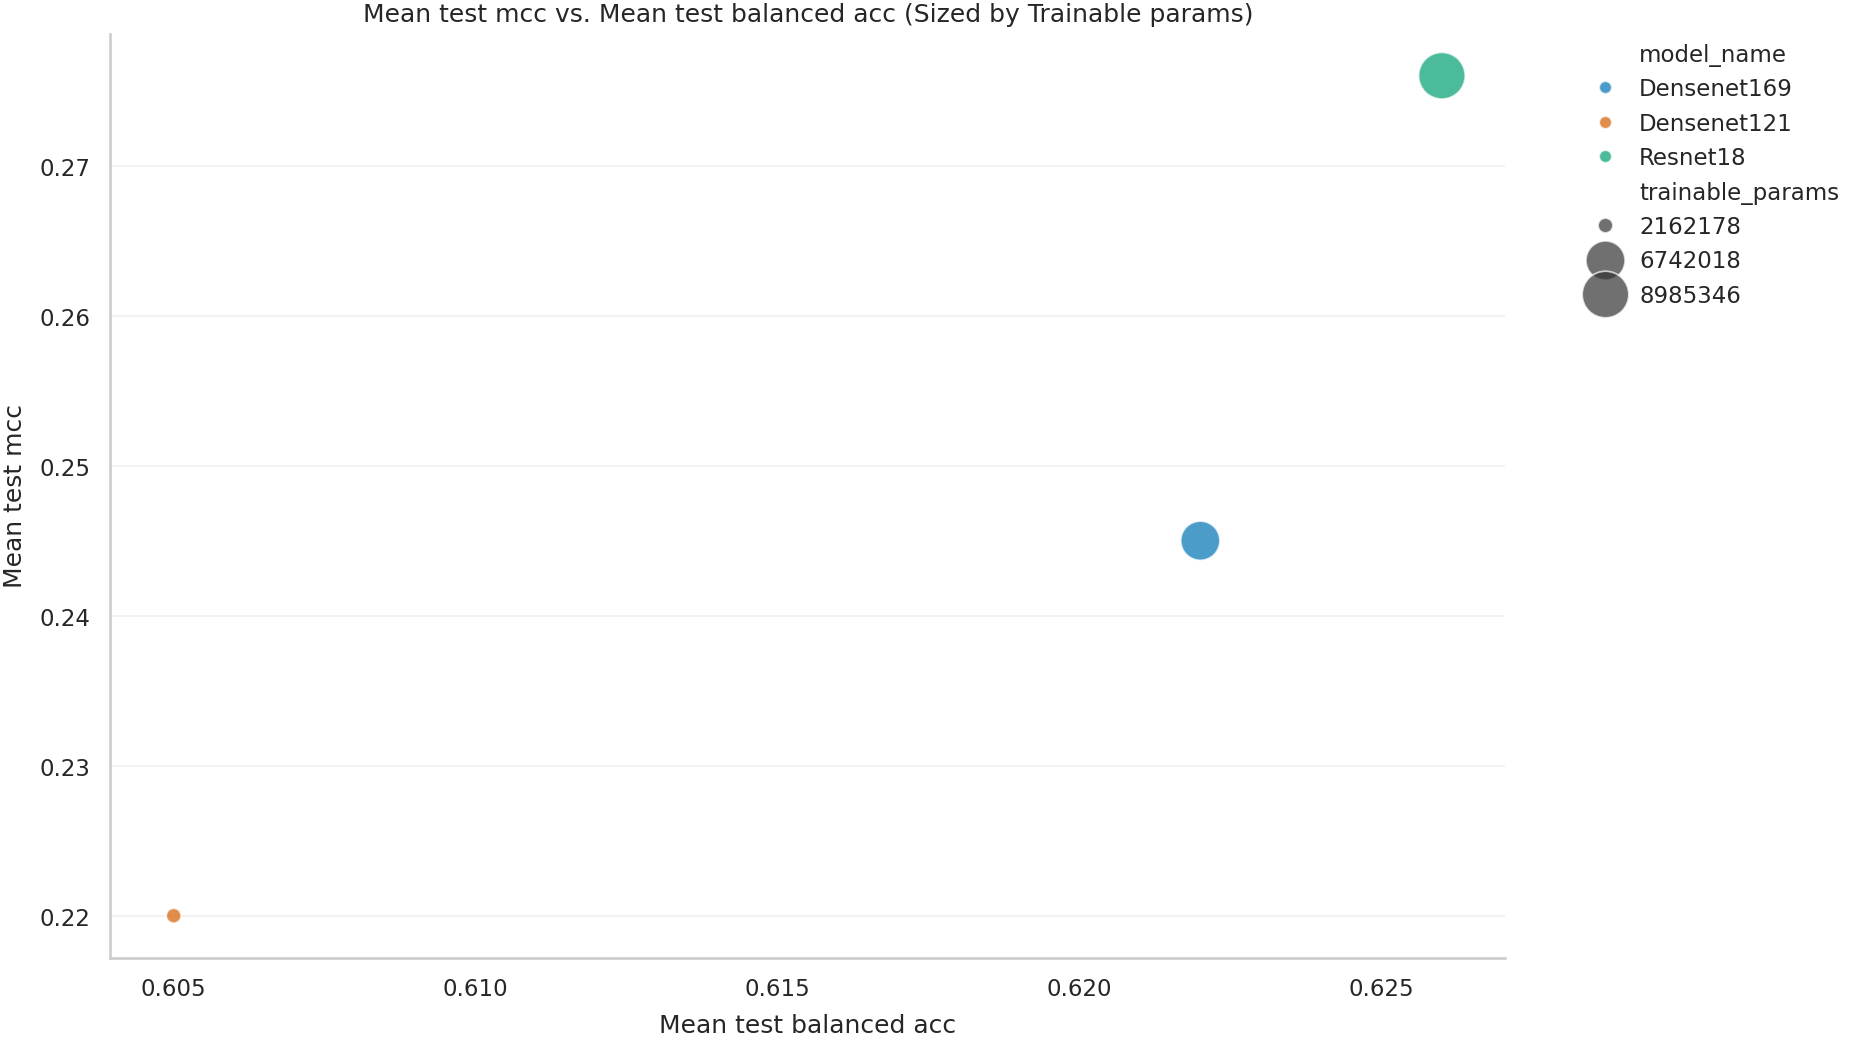

In [631]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # Import numpy for numeric checks

# We assume 'style_manager as sm' is already imported and activated

def _format_label(col_name):
    """Converts a column name into a human-readable label."""
    return col_name.replace('_', ' ').capitalize()

def plot_performance_scatter_df(df_input, x_col, y_col, 
                                hue_col='model_name', 
                                size_col='trainable_params', 
                                save_filename=None):
    """
    Generates a styled scatterplot comparing two performance metrics from a 
    SINGLE DataFrame.
    
    Args:
        df_input (pd.DataFrame): The input DataFrame to plot.
        x_col (str): The column name for the x-axis.
        y_col (str): The column name for the y-axis.
        hue_col (str): The column name for color encoding.
        size_col (str): The column name for size encoding.
        save_filename (str): The path to save the figure (e.g., "images/my_plot.png").
    """
    
    # --- 1. Data Preparation ---
    # Check for necessary columns in the provided DataFrame
    required_cols = [x_col, y_col, hue_col, size_col]
    if not all(col in df_input.columns for col in required_cols):
        print(f"Error: Missing one or more required columns: {required_cols}")
        return
    
    df_plot = df_input.copy() 

    # --- FIX ---
    # Ensure the plot columns are numeric for correct scaling and plotting.
    # This is critical for the 'size' aesthetic.
    try:
        df_plot[x_col] = pd.to_numeric(df_plot[x_col])
        df_plot[y_col] = pd.to_numeric(df_plot[y_col])
        df_plot[size_col] = pd.to_numeric(df_plot[size_col])
    except ValueError as e:
        print(f"Error: Could not convert columns to numeric. Check data.")
        print(f"Column '{size_col}' must be numeric for size scaling.")
        print(f"Pandas error: {e}")
        return
    # --- END FIX ---

    # --- 2. Plot Generation ---
    # Set the standard Seaborn theme
    sns.set_theme(style="whitegrid", palette=sm.palette)
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Generate the scatterplot
    sns.scatterplot(
        data=df_plot,
        x=x_col,
        y=y_col,
        hue=hue_col,
        size=size_col,
        sizes=(50, 500),  # Set a min/max range for bubble sizes
        alpha=0.7,        # Use transparency
        ax=ax
    )
    
    # --- 3. Style Adherence ---
    # Create formatted labels
    x_label = _format_label(x_col)
    y_label = _format_label(y_col)
    size_label = _format_label(size_col)
    
    # Set labels and title (as per thesis style)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f"{y_label} vs. {x_label} (Sized by {size_label})")
    
    # Remove top and right spines
    sns.despine(ax=ax)
    
    # Move the legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    # --- 4. Save Figure ---
    if save_filename:
        print(f"Saving plot to {save_filename}...")
        sm.savefig(save_filename)
    else:
        print("Displaying plot. Note: 'save_filename' not provided; plot will not be saved.")
    
    plt.show()
    
# This will now work:
# plot_performance_scatter_df(
#     df_input=df_ds1_msa_notpt,
#     x_col='mean_test_balanced_acc',
#     y_col='mean_test_mcc',
#     save_filename="images/03_ds1_msa_notpt_scatter.png"
# )

# This will now work:
plot_performance_scatter_df(
    df_input=df_ds1_msap_pretrained_imagenet,
    x_col='mean_test_balanced_acc',
    y_col='mean_test_mcc',
    save_filename="images/03_ds1_msa_notpt_scatter.png"
)

In [606]:
df_ds1_msap_pretrained_imagenet[["model_name","trainable_params"]].head()

,model_name,trainable_params
56,Densenet169,6742018
59,Densenet121,2162178
62,Resnet18,8985346


# BAR PLOTS WITH ERRORS

Figure saved to images/architecture_errorbars/errorbar_bal_acc_ds1_msa_notpt.png
Plotted 4 architectures:
  DenseNet121: 0.672 ± 0.126 (n=1)
  DenseNet169: 0.641 ± 0.091 (n=1)
  ResNet18: 0.639 ± 0.167 (n=1)
  ViT: 0.547 ± 0.102 (n=1)
Figure saved to images/architecture_errorbars/errorbar_mcc_ds1_msa_notpt.png
Plotted 4 architectures:
  DenseNet121: 0.345 ± 0.243 (n=1)
  DenseNet169: 0.314 ± 0.178 (n=1)
  ResNet18: 0.273 ± 0.323 (n=1)
  ViT: 0.092 ± 0.235 (n=1)


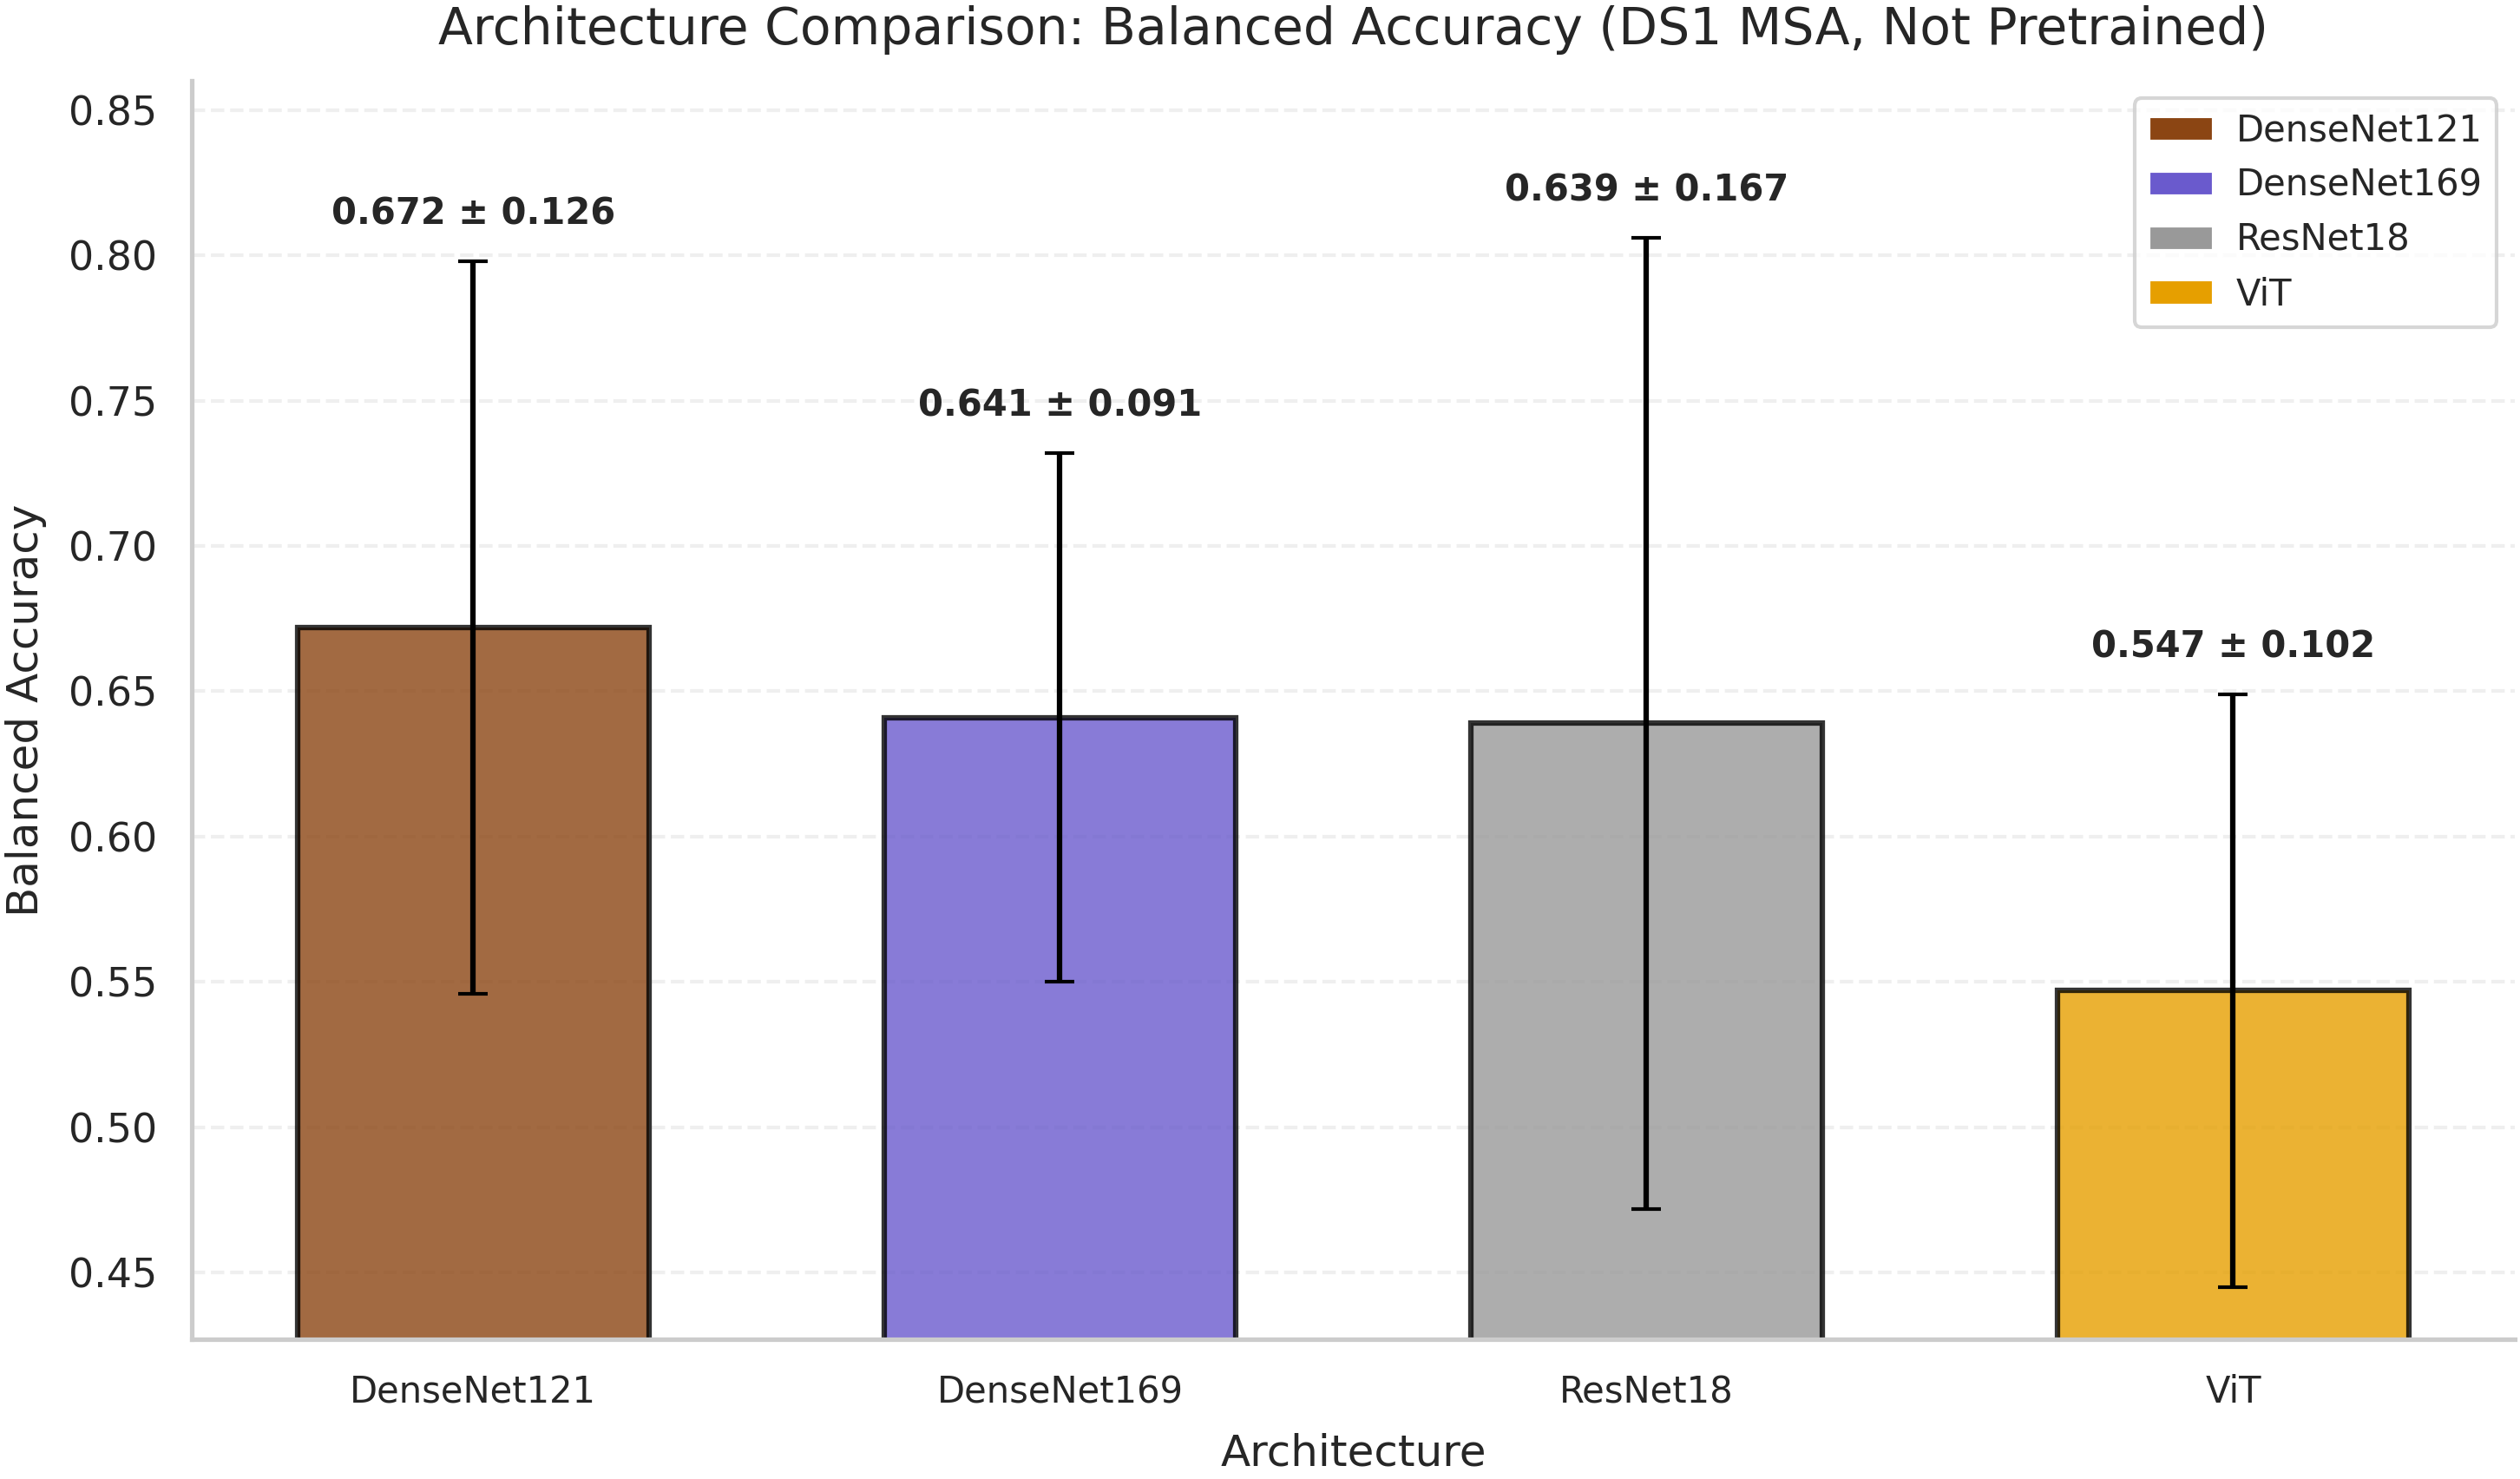

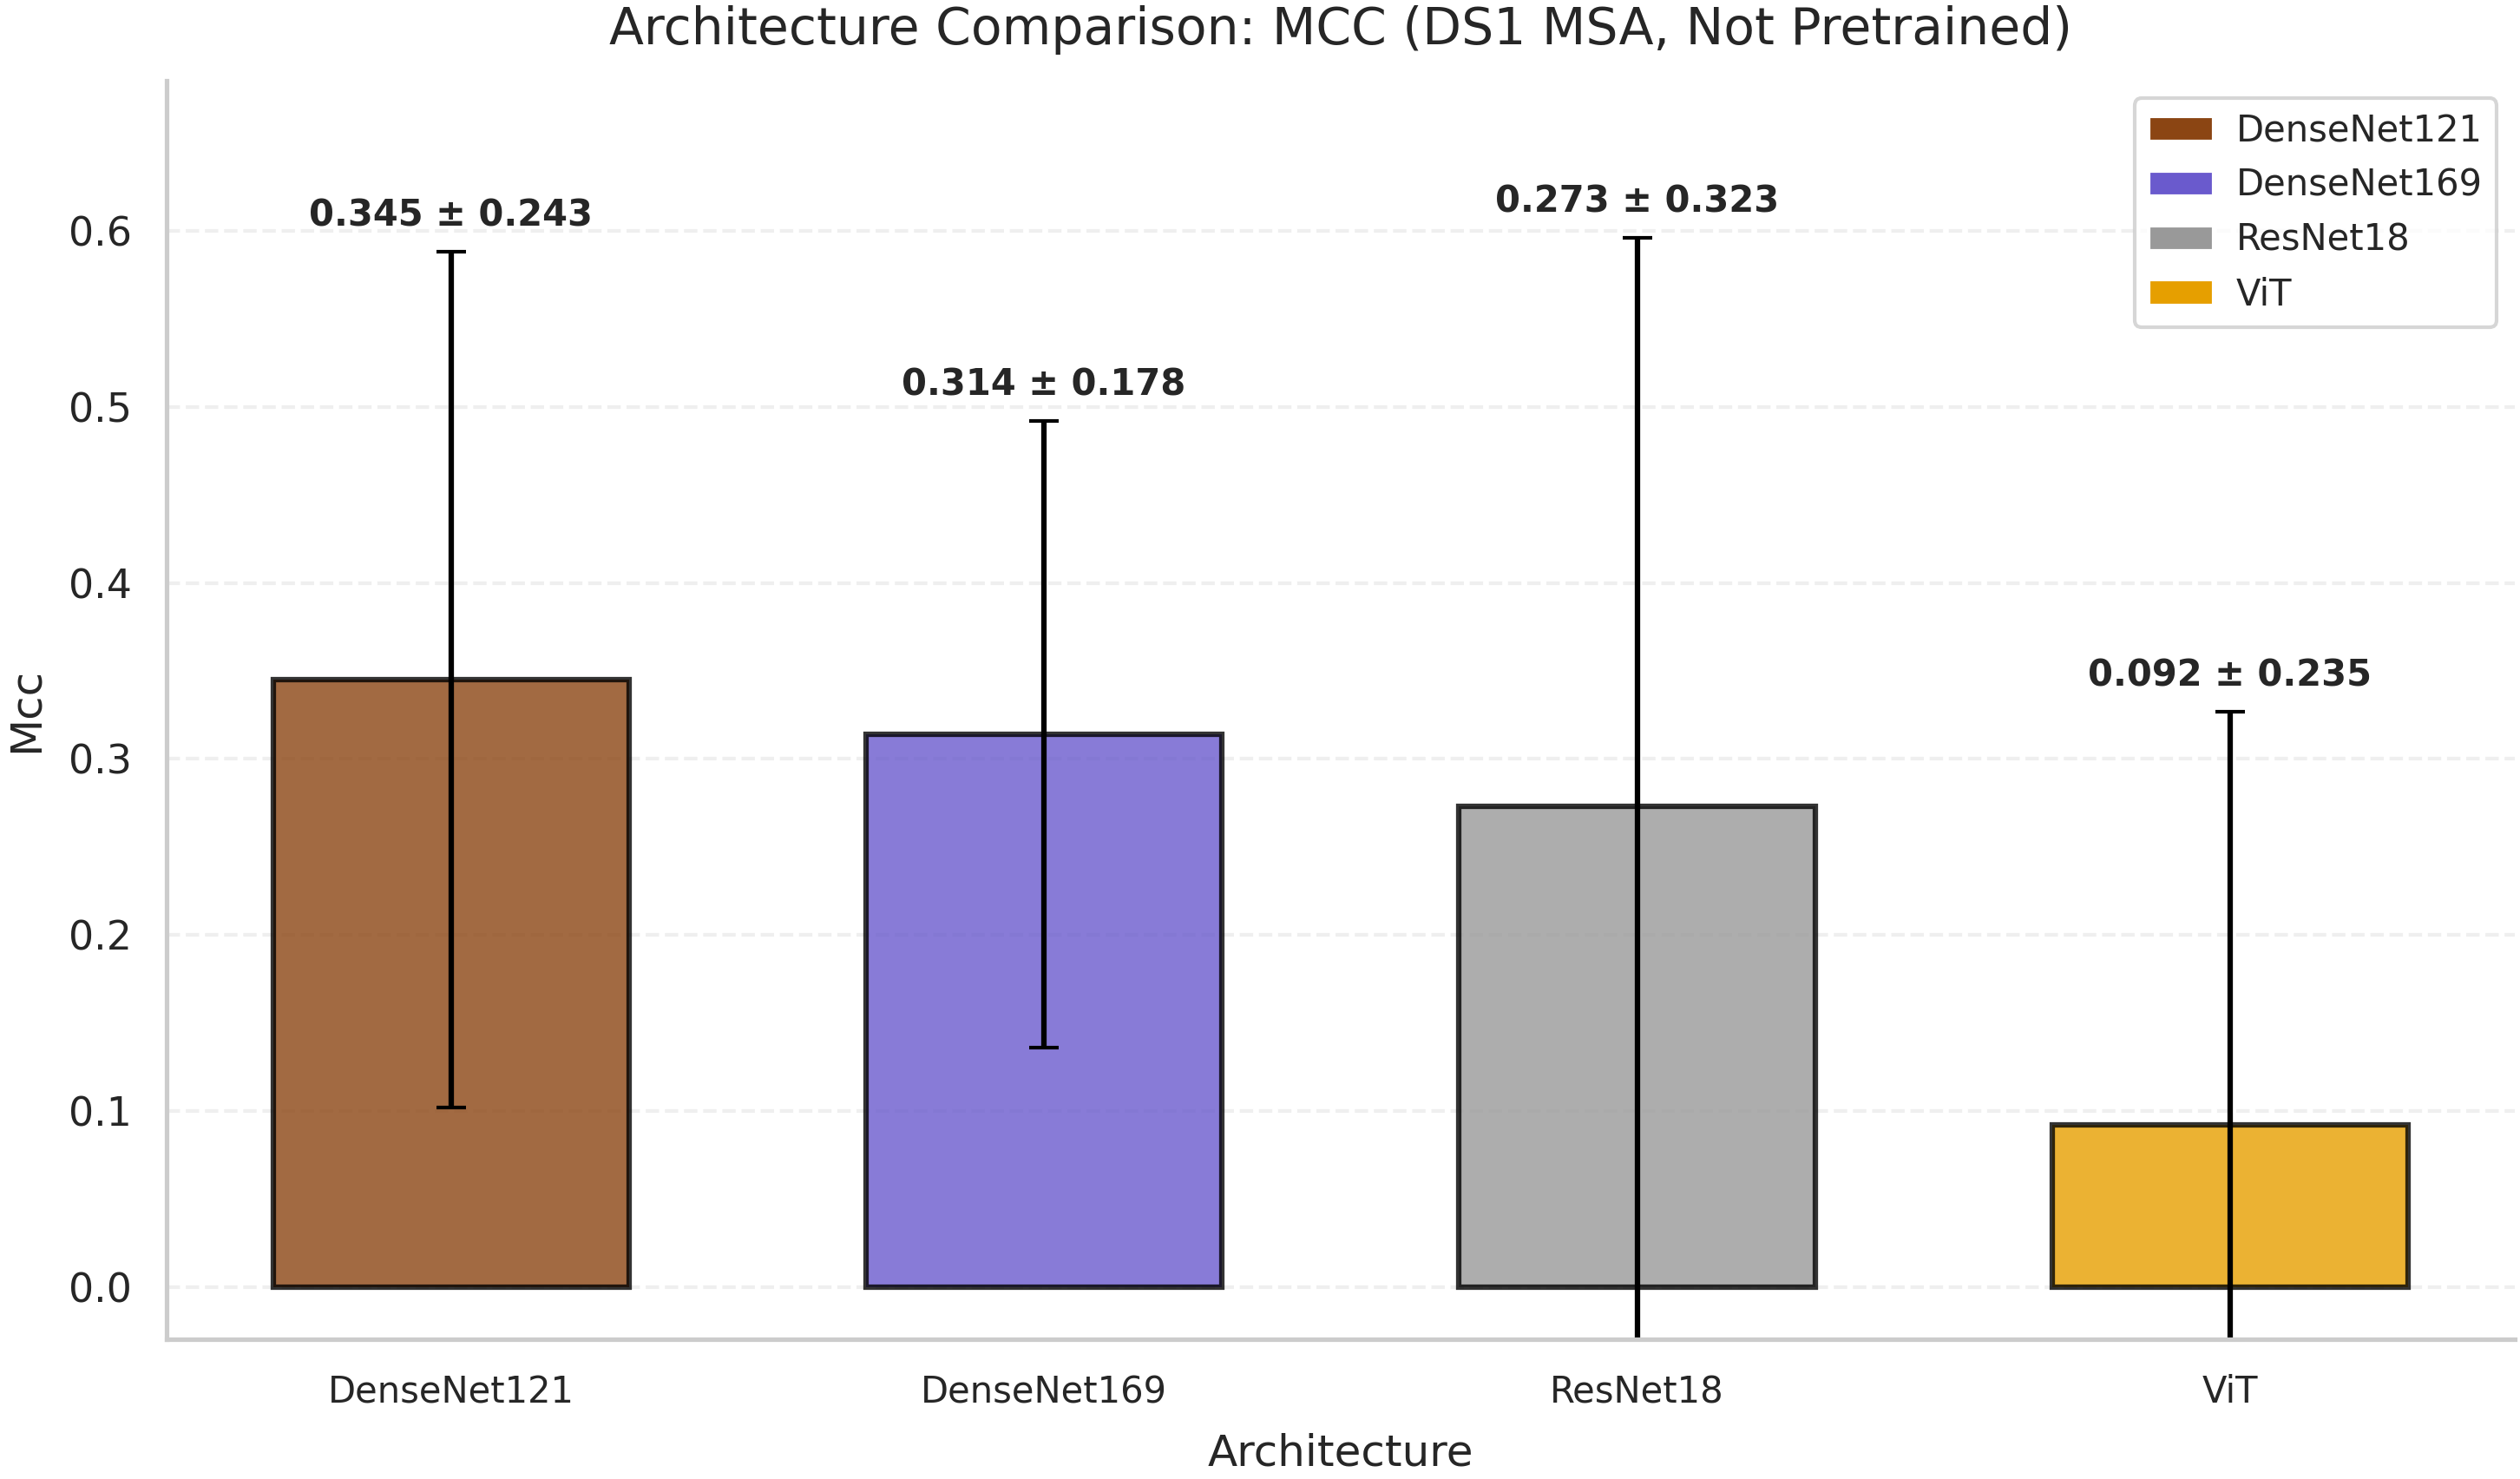

In [ ]:
"""
Error Bar Plots for Architecture Comparison
-------------------------------------------
Creates error bar plots comparing the 4 main architectures (Vit, ResNet18, 
DenseNet121, DenseNet169) from a dataframe with mean and std metrics.

Usage:
    from style.style_manager import StyleManager
    import pandas as pd
    
    # Assuming you have a dataframe from dfs_to_export
    df = df_ds1_msa_notpt  # or any other dataframe
    
    # Create error bar plot for balanced accuracy
    create_architecture_errorbar_plot(
        df, 
        metric='mean_test_balanced_acc',
        std_metric='std_test_balanced_acc',
        title='Architecture Comparison: Balanced Accuracy',
        filename='architecture_errorbar_bal_acc.png'
    )
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re

# Import StyleManager
try:
    from style.style_manager import StyleManager
except ImportError:
    current_dir = os.getcwd()
    if os.path.basename(current_dir) == 'notebooks':
        project_root = os.path.dirname(current_dir)
        sys.path.insert(0, project_root)
    else:
        parent_dir = os.path.dirname(current_dir)
        sys.path.insert(0, parent_dir)
    from style.style_manager import StyleManager

# Initialize style
current_dir = os.getcwd()
if os.path.basename(current_dir) == 'notebooks':
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

mplstyle_path = os.path.join(project_root, 'style', 'thesis_style.mplstyle')
sm = StyleManager(mplstyle_path=mplstyle_path)
sm.activate()
sns.set_theme(style="whitegrid", palette=sm.palette)

# Architecture colors from plotting.mdc
architecture_colors = {
    'vit': '#E69F00',           # Amber (palette[6])
    'resnet18': '#999999',      # Gray (palette[7])
    'densenet121': '#8B4513',   # Saddle brown
    'densenet169': '#6A5ACD',   # Slate blue
}

# Architecture display names
architecture_names = {
    'vit': 'ViT',
    'resnet18': 'ResNet18',
    'densenet121': 'DenseNet121',
    'densenet169': 'DenseNet169',
}


def extract_architecture_name(model_name: str) -> str:
    """
    Extract architecture family name from model_name.
    
    Parameters
    ----------
    model_name : str
        Full model name (e.g., 'Densenet121_oversamp_TL', 'resnet18', 'vit_b16')
        
    Returns
    -------
    str
        Architecture family name: 'vit', 'resnet18', 'densenet121', 'densenet169', or 'unknown'
    """
    if not isinstance(model_name, str):
        return 'unknown'
    
    name_lower = model_name.lower()
    
    # Check for ViT
    if 'vit' in name_lower:
        return 'vit'
    
    # Check for ResNet18
    if 'resnet18' in name_lower or 'resnet_18' in name_lower:
        return 'resnet18'
    
    # Check for DenseNet121
    if 'densenet121' in name_lower or 'densenet_121' in name_lower:
        return 'densenet121'
    
    # Check for DenseNet169
    if 'densenet169' in name_lower or 'densenet_169' in name_lower:
        return 'densenet169'
    
    # Try regex pattern matching
    match = re.search(r'(densenet\d+|resnet\d+|vit)', name_lower)
    if match:
        arch = match.group(1)
        if 'densenet121' in arch:
            return 'densenet121'
        elif 'densenet169' in arch:
            return 'densenet169'
        elif 'resnet18' in arch:
            return 'resnet18'
        elif 'vit' in arch:
            return 'vit'
    
    return 'unknown'


def create_architecture_errorbar_plot(
    df: pd.DataFrame,
    metric: str = 'mean_test_balanced_acc',
    std_metric: str = 'std_test_balanced_acc',
    title: str = 'Architecture Comparison',
    ylabel: str = None,
    filename: str = 'architecture_errorbar.png',
    output_dir: str = 'images/bar_err_plots',
    architectures: list = ['vit', 'resnet18', 'densenet121', 'densenet169'],
    figsize: tuple = (10, 6)
) -> str:
    """
    Create error bar plot comparing the 4 main architectures.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with model_name, metric, and std_metric columns.
    metric : str
        Column name for the mean metric (default: 'mean_test_balanced_acc').
    std_metric : str
        Column name for the standard deviation (default: 'std_test_balanced_acc').
    title : str
        Plot title.
    ylabel : str, optional
        Y-axis label. If None, derived from metric name.
    filename : str
        Output filename.
    output_dir : str
        Directory to save the figure.
    architectures : list
        List of architecture names to include.
    figsize : tuple
        Figure size (width, height).
        
    Returns
    -------
    str
        Path to saved figure.
    """
    # Filter dataframe to only include valid data
    required_cols = ['model_name', metric, std_metric]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(
            f"Missing required columns: {missing_cols}. "
            f"Available columns: {list(df.columns)}"
        )
    
    # Remove rows with missing values
    df_clean = df[required_cols].copy()
    df_clean = df_clean.dropna(subset=[metric, std_metric])
    
    if df_clean.empty:
        print(f"Warning: No valid data found after filtering. DataFrame has {len(df)} rows.")
        return None
    
    # Extract architecture names
    df_clean['arch_family'] = df_clean['model_name'].apply(extract_architecture_name)
    
    # Filter to only include the 4 main architectures
    df_clean = df_clean[df_clean['arch_family'].isin(architectures)]
    
    if df_clean.empty:
        print(f"Warning: No data found for architectures {architectures}.")
        print(f"Found architectures: {df_clean['arch_family'].unique() if 'arch_family' in df_clean.columns else 'N/A'}")
        return None
    
    # Group by architecture and aggregate (in case of multiple runs per architecture)
    # Use mean of means and calculate pooled std if multiple runs
    arch_data = []
    for arch in architectures:
        arch_df = df_clean[df_clean['arch_family'] == arch]
        if not arch_df.empty:
            # Take mean of means
            mean_val = arch_df[metric].mean()
            # For std: use max(std) or sqrt(mean(std^2)) - here we use max for simplicity
            # Alternatively, you might want to keep the std from a single best run
            std_val = arch_df[std_metric].max()  # Conservative: use max std
            arch_data.append({
                'architecture': arch,
                'mean': mean_val,
                'std': std_val,
                'count': len(arch_df)
            })
    
    if not arch_data:
        print("Warning: No architecture data to plot.")
        return None
    
    # Convert to DataFrame for plotting
    plot_df = pd.DataFrame(arch_data)
    
    # Sort by mean value for better visualization
    plot_df = plot_df.sort_values('mean', ascending=False)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Prepare x positions and data
    x_pos = np.arange(len(plot_df))
    means = plot_df['mean'].values
    stds = plot_df['std'].values
    arch_labels = [architecture_names[arch] for arch in plot_df['architecture'].values]
    
    # Create colors list
    colors = [architecture_colors.get(arch, sm.palette[0]) for arch in plot_df['architecture'].values]
    
    # Create error bar plot
    bars = ax.bar(
        x_pos,
        means,
        yerr=stds,
        capsize=4,
        ecolor='black',
        edgecolor='black',
        linewidth=1.5,
        color=colors,
        alpha=0.8,
        width=0.6
    )
    
    # Add value labels on top of bars
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + std + 0.01,  # Position above error bar
            f'{mean:.3f} ± {std:.3f}',
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )
    
    # Customize plot
    ax.set_xlabel('Architecture', fontsize=12)
    if ylabel is None:
        # Derive ylabel from metric name
        ylabel = metric.replace('mean_', '').replace('_', ' ').title()
        # Clean up common patterns
        ylabel = ylabel.replace('Test ', '').replace('Balanced Acc', 'Balanced Accuracy')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(arch_labels, fontsize=10)
    
    # Set y-axis limits
    y_max = (means + stds).max()
    y_min = max(0, (means - stds).min())
    ax.set_ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.15 * (y_max - y_min))
    
    # Add grid
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend with architecture colors
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=architecture_colors[arch], label=architecture_names[arch])
        for arch in plot_df['architecture'].values
    ]
    ax.legend(handles=legend_elements, loc='best', frameon=True, fontsize=10)
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)
    sm.savefig(output_path)
    
    print(f"Plotted {len(plot_df)} architectures:")
    for _, row in plot_df.iterrows():
        print(f"  {architecture_names[row['architecture']]}: "
              f"{row['mean']:.3f} ± {row['std']:.3f} (n={row['count']})")
    
    return output_path


# Example usage:
if __name__ == "__main__" or True:  # Set to True for notebook execution
    # Example: Create error bar plot for a dataframe
    # Assuming you have df_ds1_msa_notpt or similar available
    
    # Uncomment and modify as needed:
    create_architecture_errorbar_plot(
        df_ds1_msa_notpt,
        metric='mean_test_balanced_acc',
        std_metric='std_test_balanced_acc',
        title='Architecture Comparison: Balanced Accuracy (DS1 MSA, Not Pretrained)',
        filename='errorbar_bal_acc_ds1_msa_notpt.png'
    )
    
    # You can also create plots for other metrics:
    create_architecture_errorbar_plot(
        df_ds1_msa_notpt,
        metric='mean_test_mcc',
        std_metric='std_test_mcc',
        title='Architecture Comparison: MCC (DS1 MSA, Not Pretrained)',
        filename='errorbar_mcc_ds1_msa_notpt.png'
    )
    
    pass

In [660]:
"""
Grouped Error Bar Plot: Balanced Accuracy and F1 Score
--------------------------------------------------------
Creates a grouped bar chart comparing Balanced Accuracy and F1 Score 
side-by-side for each architecture in a single plot.
"""

def create_grouped_bal_acc_f1_errorbar_plot(
    df: pd.DataFrame,
    bal_acc_metric: str = 'mean_test_balanced_acc',
    bal_acc_std: str = 'std_test_balanced_acc',
    f1_metric: str = 'mean_test_f1',
    f1_std: str = 'std_test_f1',
    title: str = 'Architecture Comparison: Balanced Accuracy and F1 Score',
    ylabel: str = 'Score',
    filename: str = 'grouped_bal_acc_f1_errorbar.png',
    output_dir: str = 'images/bar_err_plots',
    architectures: list = ['vit', 'resnet18', 'densenet121', 'densenet169'],
    figsize: tuple = (12, 6)
) -> str:
    """
    Create grouped error bar plot comparing Balanced Accuracy and F1 Score 
    side-by-side for each architecture.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with model_name, metrics, and std columns.
    bal_acc_metric : str
        Column name for mean balanced accuracy.
    bal_acc_std : str
        Column name for std balanced accuracy.
    f1_metric : str
        Column name for mean F1 score.
    f1_std : str
        Column name for std F1 score.
    title : str
        Plot title.
    ylabel : str
        Y-axis label.
    filename : str
        Output filename.
    output_dir : str
        Directory to save the figure.
    architectures : list
        List of architecture names to include.
    figsize : tuple
        Figure size (width, height).
        
    Returns
    -------
    str
        Path to saved figure.
    """
    # Filter dataframe to only include valid data
    required_cols = ['model_name', bal_acc_metric, bal_acc_std, f1_metric, f1_std]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(
            f"Missing required columns: {missing_cols}. "
            f"Available columns: {list(df.columns)}"
        )
    
    # Remove rows with missing values
    df_clean = df[required_cols].copy()
    df_clean = df_clean.dropna(subset=[bal_acc_metric, bal_acc_std, f1_metric, f1_std])
    
    if df_clean.empty:
        print(f"Warning: No valid data found after filtering. DataFrame has {len(df)} rows.")
        return None
    
    # Extract architecture names
    df_clean['arch_family'] = df_clean['model_name'].apply(extract_architecture_name)
    
    # Filter to only include the 4 main architectures
    df_clean = df_clean[df_clean['arch_family'].isin(architectures)]
    
    if df_clean.empty:
        print(f"Warning: No data found for architectures {architectures}.")
        print(f"Found architectures: {df_clean['arch_family'].unique() if 'arch_family' in df_clean.columns else 'N/A'}")
        return None
    
    # Group by architecture and aggregate (in case of multiple runs per architecture)
    arch_data = []
    for arch in architectures:
        arch_df = df_clean[df_clean['arch_family'] == arch]
        if not arch_df.empty:
            # Take mean of means for both metrics
            bal_acc_mean = arch_df[bal_acc_metric].mean()
            bal_acc_std_val = arch_df[bal_acc_std].max()  # Conservative: use max std
            f1_mean = arch_df[f1_metric].mean()
            f1_std_val = arch_df[f1_std].max()
            
            arch_data.append({
                'architecture': arch,
                'bal_acc_mean': bal_acc_mean,
                'bal_acc_std': bal_acc_std_val,
                'f1_mean': f1_mean,
                'f1_std': f1_std_val,
                'count': len(arch_df)
            })
    
    if not arch_data:
        print("Warning: No architecture data to plot.")
        return None
    
    # Convert to DataFrame for plotting
    plot_df = pd.DataFrame(arch_data)
    
    # Sort by balanced accuracy mean for better visualization
    plot_df = plot_df.sort_values('bal_acc_mean', ascending=False)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Prepare x positions and data
    x_pos = np.arange(len(plot_df))
    width = 0.35  # Width of the bars
    
    # Data for bars
    bal_acc_means = plot_df['bal_acc_mean'].values
    bal_acc_stds = plot_df['bal_acc_std'].values
    f1_means = plot_df['f1_mean'].values
    f1_stds = plot_df['f1_std'].values
    arch_labels = [architecture_names[arch] for arch in plot_df['architecture'].values]
    
    # Colors from palette: Blue for Balanced Accuracy, Orange for F1
    bal_acc_color = sm.palette[0]  # Blue (#0072B2)
    f1_color = sm.palette[1]       # Orange/Vermillion (#D55E00)
    
    # Create grouped bars
    bars1 = ax.bar(
        x_pos - width/2,
        bal_acc_means,
        width,
        yerr=bal_acc_stds,
        capsize=4,
        ecolor='black',
        edgecolor='black',
        linewidth=1.5,
        color=bal_acc_color,
        alpha=0.8,
        label='Balanced Accuracy'
    )
    
    bars2 = ax.bar(
        x_pos + width/2,
        f1_means,
        width,
        yerr=f1_stds,
        capsize=4,
        ecolor='black',
        edgecolor='black',
        linewidth=1.5,
        color=f1_color,
        alpha=0.8,
        label='F1-Score',
        hatch='///'  # Diagonal stripes pattern
    )
    
    # Add value labels on top of bars
    for bar, mean, std in zip(bars1, bal_acc_means, bal_acc_stds):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + std + 0.02,
            f'{mean:.2f}',
            ha='center',
            va='bottom',
            fontsize=9,
            fontweight='bold'
        )
    
    for bar, mean, std in zip(bars2, f1_means, f1_stds):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + std + 0.02,
            f'{mean:.2f}',
            ha='center',
            va='bottom',
            fontsize=9,
            fontweight='bold'
        )
    
    # Customize plot
    ax.set_xlabel('Architecture', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(arch_labels, fontsize=10)
    
    # Set y-axis limits (both metrics are typically 0-1)
    y_max = max((bal_acc_means + bal_acc_stds).max(), (f1_means + f1_stds).max())
    y_min = max(0, min((bal_acc_means - bal_acc_stds).min(), (f1_means - f1_stds).min()))
    ax.set_ylim(y_min - 0.05 * (y_max - y_min), min(1.0, y_max + 0.15 * (y_max - y_min)))
    
    # Add grid
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend
    ax.legend(loc='best', frameon=True, fontsize=10)
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)
    sm.savefig(output_path)
    
    print(f"Plotted {len(plot_df)} architectures:")
    for _, row in plot_df.iterrows():
        print(f"  {architecture_names[row['architecture']]}: "
              f"Bal Acc = {row['bal_acc_mean']:.3f} ± {row['bal_acc_std']:.3f}, "
              f"F1 = {row['f1_mean']:.3f} ± {row['f1_std']:.3f} (n={row['count']})")
    
    return output_path


# Example usage:
# create_grouped_bal_acc_f1_errorbar_plot(
#     df_ds1_msa_notpt,
#     title='Training from scratch 4 channels',
#     filename='grouped_bal_acc_f1_ds1_msa_notpt.png'
# )


In [658]:

def create_architecture_f1_errorbar_plot(
    df: pd.DataFrame,
    metric: str = 'mean_test_f1',
    std_metric: str = 'std_test_f1',
    title: str = 'Architecture Comparison: F1 Score',
    ylabel: str = 'F1 Score',
    filename: str = 'architecture_errorbar_f1.png',
    output_dir: str = 'images/bar_err_plots',
    architectures: list = ['vit', 'resnet18', 'densenet121', 'densenet169'],
    figsize: tuple = (10, 6)
) -> str:
    """
    Create error bar plot comparing F1 scores for the 4 main architectures.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with model_name, metric, and std_metric columns.
    metric : str
        Column name for the mean metric (default: 'mean_test_f1').
    std_metric : str
        Column name for the standard deviation (default: 'std_test_f1').
    title : str
        Plot title.
    ylabel : str
        Y-axis label.
    filename : str
        Output filename.
    output_dir : str
        Directory to save the figure (default: 'images/bar_err_plots').
    architectures : list
        List of architecture names to include.
    figsize : tuple
        Figure size (width, height).
        
    Returns
    -------
    str
        Path to saved figure.
    """
    # Filter dataframe to only include valid data
    required_cols = ['model_name', metric, std_metric]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(
            f"Missing required columns: {missing_cols}. "
            f"Available columns: {list(df.columns)}"
        )
    
    # Remove rows with missing values
    df_clean = df[required_cols].copy()
    df_clean = df_clean.dropna(subset=[metric, std_metric])
    
    if df_clean.empty:
        print(f"Warning: No valid data found after filtering. DataFrame has {len(df)} rows.")
        return None
    
    # Extract architecture names
    df_clean['arch_family'] = df_clean['model_name'].apply(extract_architecture_name)
    
    # Filter to only include the 4 main architectures
    df_clean = df_clean[df_clean['arch_family'].isin(architectures)]
    
    if df_clean.empty:
        print(f"Warning: No data found for architectures {architectures}.")
        print(f"Found architectures: {df_clean['arch_family'].unique() if 'arch_family' in df_clean.columns else 'N/A'}")
        return None
    
    # Group by architecture and aggregate (in case of multiple runs per architecture)
    arch_data = []
    for arch in architectures:
        arch_df = df_clean[df_clean['arch_family'] == arch]
        if not arch_df.empty:
            # Take mean of means
            mean_val = arch_df[metric].mean()
            # For std: use max(std) for conservative estimate
            std_val = arch_df[std_metric].max()
            arch_data.append({
                'architecture': arch,
                'mean': mean_val,
                'std': std_val,
                'count': len(arch_df)
            })
    
    if not arch_data:
        print("Warning: No architecture data to plot.")
        return None
    
    # Convert to DataFrame for plotting
    plot_df = pd.DataFrame(arch_data)
    
    # Sort by mean value for better visualization
    plot_df = plot_df.sort_values('mean', ascending=False)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Prepare x positions and data
    x_pos = np.arange(len(plot_df))
    means = plot_df['mean'].values
    stds = plot_df['std'].values
    arch_labels = [architecture_names[arch] for arch in plot_df['architecture'].values]
    
    # Create colors list
    colors = [architecture_colors.get(arch, sm.palette[0]) for arch in plot_df['architecture'].values]
    
    # Create error bar plot
    bars = ax.bar(
        x_pos,
        means,
        yerr=stds,
        capsize=4,
        ecolor='black',
        edgecolor='black',
        linewidth=1.5,
        color=colors,
        alpha=0.8,
        width=0.6
    )
    
    # Add value labels on top of bars
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + std + 0.01,  # Position above error bar
            f'{mean:.3f} ± {std:.3f}',
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )
    
    # Customize plot
    ax.set_xlabel('Architecture', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(arch_labels, fontsize=10)
    
    # Set y-axis limits (F1 is typically 0-1)
    y_max = (means + stds).max()
    y_min = max(0, (means - stds).min())
    ax.set_ylim(y_min - 0.05 * (y_max - y_min), min(1.0, y_max + 0.15 * (y_max - y_min)))
    
    # Add grid
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend with architecture colors
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=architecture_colors[arch], label=architecture_names[arch])
        for arch in plot_df['architecture'].values
    ]
    ax.legend(handles=legend_elements, loc='best', frameon=True, fontsize=10)
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)
    sm.savefig(output_path)
    
    print(f"Plotted {len(plot_df)} architectures:")
    for _, row in plot_df.iterrows():
        print(f"  {architecture_names[row['architecture']]}: "
              f"{row['mean']:.3f} ± {row['std']:.3f} (n={row['count']})")
    
    return output_path

Figure saved to images/bar_err_plots/grouped_bal_acc_f1_ds1_msa_notpt.png
Plotted 4 architectures:
  DenseNet121: Bal Acc = 0.672 ± 0.126, F1 = 0.608 ± 0.151 (n=1)
  DenseNet169: Bal Acc = 0.641 ± 0.091, F1 = 0.514 ± 0.153 (n=1)
  ResNet18: Bal Acc = 0.639 ± 0.167, F1 = 0.579 ± 0.162 (n=1)
  ViT: Bal Acc = 0.547 ± 0.102, F1 = 0.359 ± 0.193 (n=1)


'images/bar_err_plots/grouped_bal_acc_f1_ds1_msa_notpt.png'

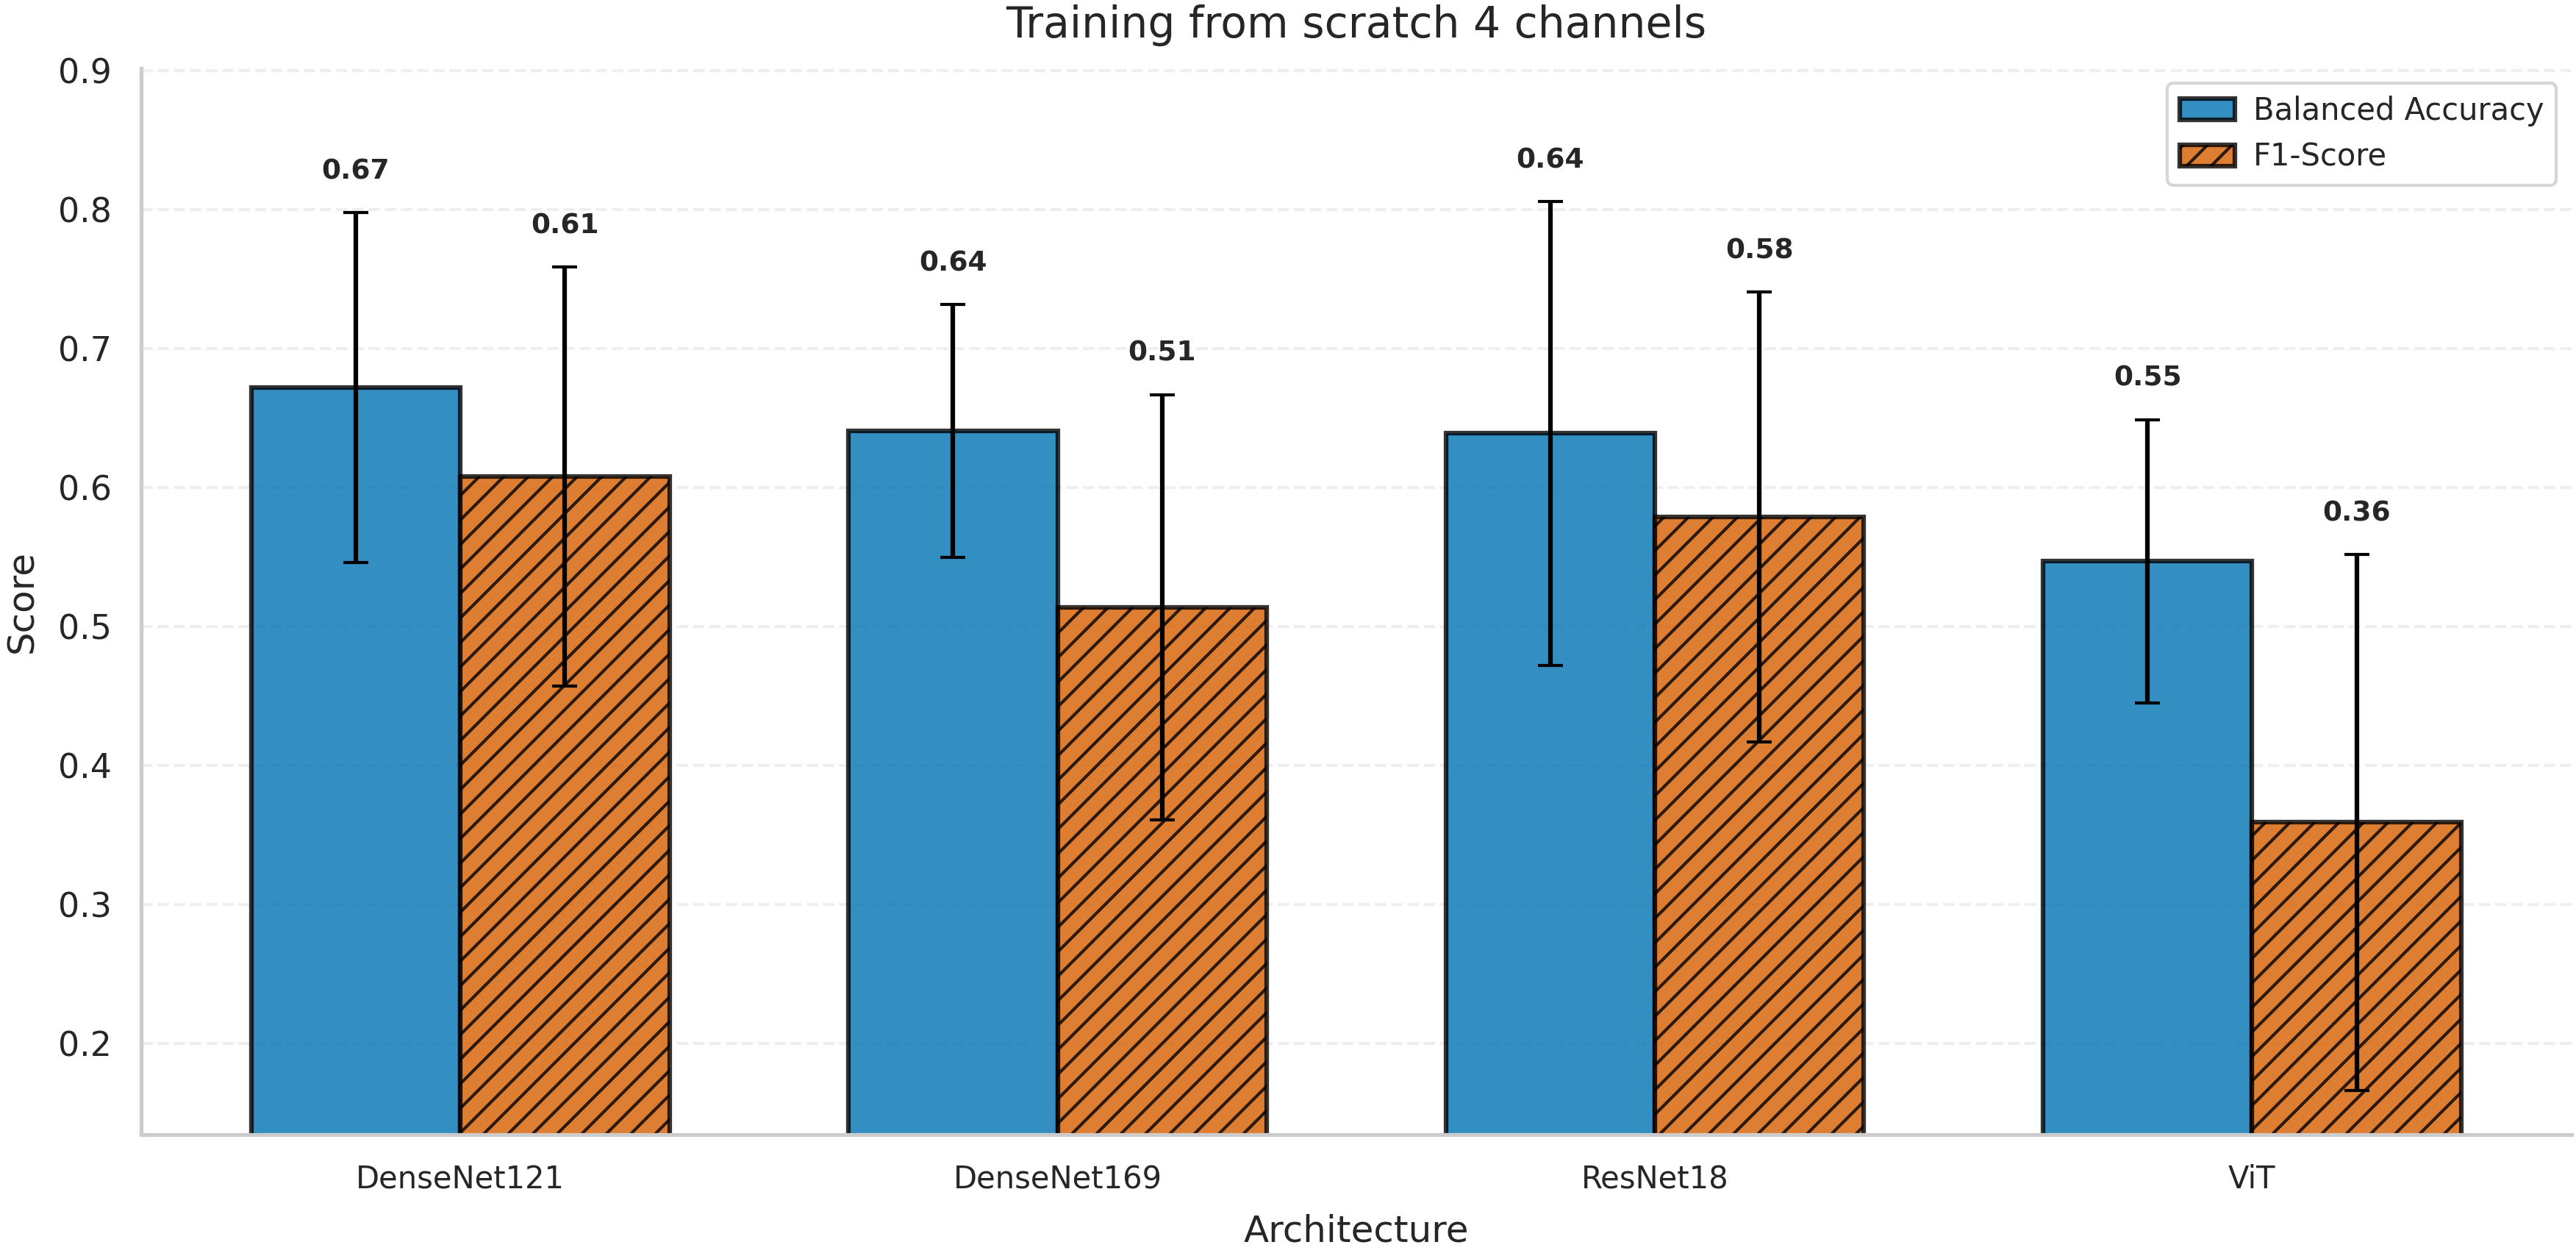

In [661]:
# Example usage for both functions:
# 
# # For balanced accuracy (update the existing call):
# create_architecture_errorbar_plot(
#     df_ds1_msa_notpt,
#     metric='mean_test_balanced_acc',
#     std_metric='std_test_balanced_acc',
#     title='Architecture Comparison: Balanced Accuracy (DS1 MSA, Not Pretrained)',
#     filename='errorbar_bal_acc_ds1_msa_notpt.png',
#     output_dir='images/bar_err_plots'  # Updated directory
# )

# # For F1 score (new function):
# create_architecture_f1_errorbar_plot(
#     df_ds1_msa_notpt,
#     title='Architecture Comparison: F1 Score (DS1 MSA, Not Pretrained)',
#     filename='errorbar_f1_ds1_msa_notpt.png'
# )

# For the grouped comparison (like your image):
create_grouped_bal_acc_f1_errorbar_plot(
    df_ds1_msa_notpt,
    title='Training from scratch 4 channels',
    filename='grouped_bal_acc_f1_ds1_msa_notpt.png'
)

## pretraining vs no pretraining

In [607]:
import sys

# These are the 16 DataFrame keys we need to plot
keys_to_check = [
    # DS1-MSA
    "DS1_MSA_NotPT",
    "DS1_MSA_PT_imagenet",
    "DS1_MSA_PT_imagenet_microscopynet",
    "DS1_MSA_PT_microscopy",
    # DS1-MSAP
    "DS1_MSAP_NotPT",
    "DS1_MSAP_PT_imagenet",
    "DS1_MSAP_PT_imagenet_microscopynet",
    "DS1_MSAP_PT_microscopy",
    # DS2-MSA
    "DS2_MSA_NotPT",
    "DS2_MSA_PT_imagenet",
    "DS2_MSA_PT_imagenet_microscopynet",
    "DS2_MSA_PT_microscopy",
    # DS2-MSAP
    "DS2_MSAP_NotPT",
    "DS2_MSAP_PT_imagenet",
    "DS2_MSAP_PT_imagenet_microscopynet",
    "DS2_MSAP_PT_microscopy",
]

print("--- Starting validation ---")
empty_dfs = []

for key in keys_to_check:
    # 1. Check if key exists
    if key not in dfs_to_export:
        print(f"ERROR: Key '{key}' is MISSING from your dfs_to_export dictionary.")
        empty_dfs.append(f"{key} (MISSING)")
        continue # Check the next key
        
    # 2. Get the DataFrame
    df = dfs_to_export[key]
    
    # 3. Check if it's empty
    if df.empty:
        print(f"FOUND: DataFrame '{key}' is EMPTY (0 rows).")
        empty_dfs.append(key)

if not empty_dfs:
    print("\nSUCCESS: All 16 required DataFrames are present and not empty.")
    print("You can now run the plotting script.")
else:
    print(f"\n--- VALIDATION FAILED ---")
    print("The plot failed because the following DataFrame(s) are missing or empty:")
    for key in empty_dfs:
        print(f"  - {key}")
    print("\nPlease check your data generation process for these experiments.")

--- Starting validation ---
FOUND: DataFrame 'DS1_MSA_PT_imagenet' is EMPTY (0 rows).
FOUND: DataFrame 'DS2_MSA_NotPT' is EMPTY (0 rows).

--- VALIDATION FAILED ---
The plot failed because the following DataFrame(s) are missing or empty:
  - DS1_MSA_PT_imagenet
  - DS2_MSA_NotPT

Please check your data generation process for these experiments.


In [608]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Define the thesis style palette (Okabe-Ito, colorblind-safe)
THESIS_PALETTE = ['#999999', '#E69F00', '#0072B2', '#009E73', '#D55E00', '#CC79A7', '#56B4E9', '#F0E442']
# Re-ordered: Grey (Scratch), Orange (ImageNet), Blue (Microscopy), Green (Both)
PLOT_PALETTE = ['#999999', '#E69F00', '#0072B2', '#009E73']


def apply_thesis_style():
    """Applies the standard thesis plot style for Matplotlib and Seaborn."""
    
    # Set Seaborn defaults
    sns.set_theme(
        style="whitegrid",
        palette=PLOT_PALETTE
    )
    
    # Matplotlib customizations
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',  # Arial or DejaVu Sans
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'lines.linewidth': 2.0,
        'lines.markersize': 6,
        'figure.dpi': 150
    })
    
    # Remove top and right spines
    plt.rc('axes.spines', top=False, right=False)

In [632]:
# 1. Define the keys for comparison (using your correction)
keys_to_compare_ds1_msa = {
    "Scratch": "DS1_MSA_NotPT_3c",
    "ImageNet": "DS1_MSA_PT_imagenet",
    "MicroscopyNet": "DS1_MSA_PT_microscopy",
    "ImageNet + MicroscopyNet": "DS1_MSA_PT_imagenet_microscopynet"
}

keys_to_compare_ds1_msap = {
    "Scratch": "DS1_MSAP_NotPT_3c",
    "ImageNet": "DS1_MSAP_PT_imagenet",
    "MicroscopyNet": "DS1_MSAP_PT_microscopy",
    "ImageNet + MicroscopyNet": "DS1_MSAP_PT_imagenet_microscopynet"
}

keys_to_compare_ds2_msa = {
    "Scratch": "DS2_MSA_NotPT_3c",
    "ImageNet": "DS2_MSA_PT_imagenet",
    "MicroscopyNet": "DS2_MSA_PT_microscopy",
    "ImageNet + MicroscopyNet": "DS2_MSA_PT_imagenet_microscopynet"
}

keys_to_compare_ds2_msap = {
    "Scratch": "DS2_MSAP_NotPT_3c",
    "ImageNet": "DS2_MSAP_PT_imagenet",
    "MicroscopyNet": "DS2_MSAP_PT_microscopy",
    "ImageNet + MicroscopyNet": "DS2_MSAP_PT_imagenet_microscopynet"
}

# 2. Extract and concatenate *all* relevant data
plot_data_frames = []
#NOTE CHANGE THIS KEYS_TO_COMPARE TO CHANGE DS 
for label, key in keys_to_compare.items():
    if key in dfs_to_export:
        # Get the full DataFrame
        temp_df = dfs_to_export[key].copy()
        # Add the 'Pretraining' label as a new column
        temp_df['Pretraining'] = label
        plot_data_frames.append(temp_df)
    else:
        print(f"Warning: Key '{key}' not found in dfs_to_export.")

# 3. Create one master DataFrame for plotting
plot_df = pd.concat(plot_data_frames, ignore_index=True)

# 4. Filter to only essential columns
columns_to_keep = [ 
    'model_name', 'Pretraining',
    'mean_test_balanced_acc', 'std_test_balanced_acc',
    'mean_test_mcc', 'std_test_mcc'
]
plot_df = plot_df[columns_to_keep]

# 5. Set categorical order for 'Pretraining' to ensure correct plot order
plot_df['Pretraining'] = pd.Categorical(
    plot_df['Pretraining'],
    categories=keys_to_compare.keys()
)

# 6. Sort values for predictable plotting
plot_df = plot_df.sort_values(by=['Pretraining', 'model_name'])

print("Robust plotting DataFrame prepared:")
print(plot_df.to_markdown(index=False))

Robust plotting DataFrame prepared:
| model_name   | Pretraining              |   mean_test_balanced_acc |   std_test_balanced_acc |   mean_test_mcc |   std_test_mcc |
|:-------------|:-------------------------|-------------------------:|------------------------:|----------------:|---------------:|
| Densenet121  | Scratch                  |                    0.8   |                   0.129 |           0.607 |          0.252 |
| Densenet121  | ImageNet                 |                    0.651 |                   0.147 |           0.302 |          0.293 |
| Densenet169  | ImageNet                 |                    0.627 |                   0.159 |           0.259 |          0.321 |
| Resnet18     | ImageNet                 |                    0.637 |                   0.158 |           0.29  |          0.328 |
| Densenet121  | MicroscopyNet            |                    0.688 |                   0.17  |           0.387 |          0.341 |
| Densenet169  | MicroscopyNet          

## scatterplot effects of pretraining

In [ ]:
def plot_pretraining_scatter(df, x_col, y_col, x_label, y_label, title, save_path):
    """
    Generates a faceted scatterplot comparing non-pretrained (x) vs.
    pretrained (y) performance, with a y=x diagonal line.
    """
    
    apply_thesis_style()
    
    # 1. Create the Figure-level scatterplot
    #    col="Dataset" creates the panels you wanted
    #    hue="model_name" colors the points
    #    style="Task" uses different markers for MSA vs. MSAP
    g = sns.relplot(
        data=df,
        x=x_col,
        y=y_col,
        hue='model_name',
        style='Task',
        s=100, # Marker size
        col='Dataset', # Facet by Dataset
        palette=THESIS_PALETTE,
        height=7,
        aspect=1
    )

    # 2. Add the y=x diagonal line to each facet
    for ax in g.axes.flat:
        # Get the current limits
        x_lim = ax.get_xlim()
        y_lim = ax.get_ylim()
        
        # Find the min and max for a symmetrical, square plot
        min_all = min(x_lim[0], y_lim[0])
        max_all = max(x_lim[1], y_lim[1])
        
        # Set symmetrical limits
        ax.set_xlim(min_all, max_all)
        ax.set_ylim(min_all, max_all)
        
        # Add the diagonal reference line
        ax.plot([min_all, max_all], [min_all, max_all], 'k--', alpha=0.7)
        
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    # 3. Tidy up the plot
    g.set_axis_labels(x_label, y_label)
    g.fig.suptitle(title, y=1.03, size=14)
    g.legend.set_title("Model")
    
    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the figure
    g.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(g.fig)
    print(f"Plot saved to {save_path}")
    

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np

# Define the thesis style palette (Okabe-Ito, colorblind-safe)
THESIS_PALETTE = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9', '#E69F00', '#999999']

def apply_thesis_style():
    """Applies the standard thesis plot style for Matplotlib and Seaborn."""
    sns.set_theme(style="whitegrid", palette=THESIS_PALETTE)
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'lines.linewidth': 2.0,
        'lines.markersize': 8, # Make markers a bit larger for scatter
        'figure.dpi': 150
    })
    plt.rc('axes.spines', top=False, right=False)
    
# (Assuming your dfs_to_export is loaded)

# 1. Define the comparison groups
comparison_groups_imagenet_microscopynet = [
    # (Scratch_Key, Pretrained_Key, Dataset_Label, Task_Label)
    ('DS1_MSA_NotPT_3c', 'DS1_MSA_PT_imagenet_microscopynet', 'DS1', 'MSA'),
    ('DS1_MSAP_NotPT_3c', 'DS1_MSAP_PT_imagenet_microscopynet', 'DS1', 'MSAP'),
    ('DS2_MSA_NotPT_3c', 'DS2_MSA_PT_imagenet_microscopynet', 'DS2', 'MSA'),
    ('DS2_MSAP_NotPT_3c', 'DS2_MSAP_PT_imagenet_microscopynet', 'DS2', 'MSAP'),
]

comparison_groups_imagenet = [
    ('DS1_MSA_NotPT_3c', 'DS1_MSA_PT_imagenet', 'DS1', 'MSA'),
    ('DS1_MSAP_NotPT_3c', 'DS1_MSAP_PT_imagenet', 'DS1', 'MSAP'),
    ('DS2_MSA_NotPT_3c', 'DS2_MSA_PT_imagenet', 'DS2', 'MSA'),
    ('DS2_MSAP_NotPT_3c', 'DS2_MSAP_PT_imagenet', 'DS2', 'MSAP'),
]

comparison_groups_microscopy = [
    ('DS1_MSA_NotPT_3c', 'DS1_MSA_PT_microscopy', 'DS1', 'MSA'),
    ('DS1_MSAP_NotPT_3c', 'DS1_MSAP_PT_microscopy', 'DS1', 'MSAP'),
    ('DS2_MSA_NotPT_3c', 'DS2_MSA_PT_microscopy', 'DS2', 'MSA'),
    ('DS2_MSAP_NotPT_3c', 'DS2_MSAP_PT_microscopy', 'DS2', 'MSAP'),
]


# Columns to keep for merging
metric_cols = ['model_name', 'mean_test_balanced_acc', 'mean_test_mcc']

scatter_plot_frames = []
for scratch_key, pt_key, dataset, task in comparison_groups:
    if scratch_key not in dfs_to_export or pt_key not in dfs_to_export:
        print(f"Warning: Skipping {dataset}-{task}, missing data for {scratch_key} or {pt_key}")
        continue
    
    # 2. Get the "Scratch" (Non-Pretrained) data
    df_scratch = dfs_to_export[scratch_key][metric_cols].copy()
    df_scratch = df_scratch.rename(columns={
        'mean_test_balanced_acc': 'bal_acc_scratch',
        'mean_test_mcc': 'mcc_scratch'
    })
    
    # 3. Get the "Pretrained" data
    df_pt = dfs_to_export[pt_key][metric_cols].copy()
    df_pt = df_pt.rename(columns={
        'mean_test_balanced_acc': 'bal_acc_pt',
        'mean_test_mcc': 'mcc_pt'
    })
    
    # 4. Merge on model_name
    df_merged = pd.merge(df_scratch, df_pt, on='model_name', how='inner')
    
    # 5. Add labels
    df_merged['Dataset'] = dataset
    df_merged['Task'] = task
    
    scatter_plot_frames.append(df_merged)

# 6. Create the final "wide" DataFrame for plotting
scatter_plot_df = pd.concat(scatter_plot_frames, ignore_index=True)

print("--- Scatter Plot DataFrame (Wide Format) ---")
print(scatter_plot_df.to_markdown(index=False))

In [637]:
# (Assuming your dfs_to_export is loaded)

# 1. Define all comparison groups
comparison_groups_imagenet_microscopynet = [
    ('DS1_MSA_NotPT_3c', 'DS1_MSA_PT_imagenet_microscopynet', 'DS1', 'MSA'),
    ('DS1_MSAP_NotPT_3c', 'DS1_MSAP_PT_imagenet_microscopynet', 'DS1', 'MSAP'),
    ('DS2_MSA_NotPT_3c', 'DS2_MSA_PT_imagenet_microscopynet', 'DS2', 'MSA'),
    ('DS2_MSAP_NotPT_3c', 'DS2_MSAP_PT_imagenet_microscopynet', 'DS2', 'MSAP'),
]

comparison_groups_imagenet = [
    ('DS1_MSA_NotPT_3c', 'DS1_MSA_PT_imagenet', 'DS1', 'MSA'),
    ('DS1_MSAP_NotPT_3c', 'DS1_MSAP_PT_imagenet', 'DS1', 'MSAP'),
    ('DS2_MSA_NotPT_3c', 'DS2_MSA_PT_imagenet', 'DS2', 'MSA'),
    ('DS2_MSAP_NotPT_3c', 'DS2_MSAP_PT_imagenet', 'DS2', 'MSAP'),
]

comparison_groups_microscopy = [
    ('DS1_MSA_NotPT_3c', 'DS1_MSA_PT_microscopy', 'DS1', 'MSA'),
    ('DS1_MSAP_NotPT_3c', 'DS1_MSAP_PT_microscopy', 'DS1', 'MSAP'),
    ('DS2_MSA_NotPT_3c', 'DS2_MSA_PT_microscopy', 'DS2', 'MSA'),
    ('DS2_MSAP_NotPT_3c', 'DS2_MSAP_PT_microscopy', 'DS2', 'MSAP'),
]

# 2. Create a master list to loop over
#    (Name for files, Comparison List)
master_comparison_list = [
    ('ImageNet_MicroscopyNet', comparison_groups_imagenet_microscopynet),
    ('ImageNet', comparison_groups_imagenet),
    ('MicroscopyNet', comparison_groups_microscopy),
]

# Columns to keep for merging
metric_cols = ['model_name', 'mean_test_balanced_acc', 'mean_test_mcc']

# Ensure the main save directory exists
os.makedirs('images/scatter_impact', exist_ok=True)

# 3. Main loop
print("--- Starting Scatter Plot Generation ---")
for pt_name, comparison_groups in master_comparison_list:
    
    print(f"\n--- Processing Pretraining: {pt_name} ---")
    
    # --- 3a. Data Preparation (per loop) ---
    scatter_plot_frames = []
    for scratch_key, pt_key, dataset, task in comparison_groups:
        if scratch_key not in dfs_to_export or pt_key not in dfs_to_export:
            print(f"Warning: Skipping {dataset}-{task}, missing data for {scratch_key} or {pt_key}")
            continue
        
        df_scratch = dfs_to_export[scratch_key][metric_cols].copy()
        df_scratch = df_scratch.rename(columns={
            'mean_test_balanced_acc': 'bal_acc_scratch',
            'mean_test_mcc': 'mcc_scratch'
        })
        
        df_pt = dfs_to_export[pt_key][metric_cols].copy()
        df_pt = df_pt.rename(columns={
            'mean_test_balanced_acc': 'bal_acc_pt',
            'mean_test_mcc': 'mcc_pt'
        })
        
        df_merged = pd.merge(df_scratch, df_pt, on='model_name', how='inner')
        df_merged['Dataset'] = dataset
        df_merged['Task'] = task
        scatter_plot_frames.append(df_merged)

    if not scatter_plot_frames:
        print(f"No data to plot for {pt_name}. Skipping.")
        continue
        
    scatter_plot_df = pd.concat(scatter_plot_frames, ignore_index=True)
    
    print(f"Plotting DataFrame for {pt_name} (Wide Format):")
    print(scatter_plot_df.head().to_markdown(index=False))

    # --- 3b. Plotting (per loop) ---
    
    # Plot 1: Balanced Accuracy
    plot_pretraining_scatter(
        df=scatter_plot_df,
        x_col='bal_acc_scratch',
        y_col='bal_acc_pt',
        x_label='Balanced Accuracy (Scratch)',
        y_label=f'Balanced Accuracy ({pt_name})',
        title=f'Pretraining Impact ({pt_name}) on Balanced Accuracy (3-Channel)',
        save_path=f'images/scatter_impact/09_impact_scatter_bal_acc_{pt_name}.png'
    )
    
    # Plot 2: MCC
    plot_pretraining_scatter(
        df=scatter_plot_df,
        x_col='mcc_scratch',
        y_col='mcc_pt',
        x_label='MCC (Scratch)',
        y_label=f'MCC ({pt_name})',
        title=f'Pretraining Impact ({pt_name}) on MCC (3-Channel)',
        save_path=f'images/scatter_impact/09_impact_scatter_mcc_{pt_name}.png'
    )

print("\nAll scatter plots generated successfully.")

--- Starting Scatter Plot Generation ---

--- Processing Pretraining: ImageNet_MicroscopyNet ---
Plotting DataFrame for ImageNet_MicroscopyNet (Wide Format):
| model_name   |   bal_acc_scratch |   mcc_scratch |   bal_acc_pt |   mcc_pt | Dataset   | Task   |
|:-------------|------------------:|--------------:|-------------:|---------:|:----------|:-------|
| Resnet18     |             0.751 |         0.506 |        0.61  |    0.213 | DS1       | MSA    |
| Densenet169  |             0.721 |         0.452 |        0.582 |    0.154 | DS1       | MSA    |
| Densenet121  |             0.696 |         0.406 |        0.612 |    0.218 | DS1       | MSA    |
| Resnet18     |             0.751 |         0.506 |        0.681 |    0.388 | DS1       | MSAP   |
| Densenet169  |             0.721 |         0.452 |        0.693 |    0.398 | DS1       | MSAP   |


/tmp/ipykernel_2159791/3001678087.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scatter_plot_df = pd.concat(scatter_plot_frames, ignore_index=True)
/tmp/ipykernel_2159791/2147732197.py:88: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.relplot(


Plot saved to images/scatter_impact/09_impact_scatter_bal_acc_ImageNet_MicroscopyNet.png


/tmp/ipykernel_2159791/2147732197.py:88: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.relplot(


Plot saved to images/scatter_impact/09_impact_scatter_mcc_ImageNet_MicroscopyNet.png

--- Processing Pretraining: ImageNet ---
Plotting DataFrame for ImageNet (Wide Format):
| model_name   |   bal_acc_scratch |   mcc_scratch |   bal_acc_pt |   mcc_pt | Dataset   | Task   |
|:-------------|------------------:|--------------:|-------------:|---------:|:----------|:-------|
| Resnet18     |             0.751 |         0.506 |        0.626 |    0.276 | DS1       | MSAP   |
| Densenet169  |             0.721 |         0.452 |        0.622 |    0.245 | DS1       | MSAP   |
| Densenet121  |             0.696 |         0.406 |        0.605 |    0.22  | DS1       | MSAP   |
| Densenet121  |             0.8   |         0.607 |        0.651 |    0.302 | DS2       | MSAP   |


/tmp/ipykernel_2159791/3001678087.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scatter_plot_df = pd.concat(scatter_plot_frames, ignore_index=True)
/tmp/ipykernel_2159791/2147732197.py:88: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.relplot(


Plot saved to images/scatter_impact/09_impact_scatter_bal_acc_ImageNet.png


/tmp/ipykernel_2159791/2147732197.py:88: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.relplot(


Plot saved to images/scatter_impact/09_impact_scatter_mcc_ImageNet.png

--- Processing Pretraining: MicroscopyNet ---
Plotting DataFrame for MicroscopyNet (Wide Format):
| model_name   |   bal_acc_scratch |   mcc_scratch |   bal_acc_pt |   mcc_pt | Dataset   | Task   |
|:-------------|------------------:|--------------:|-------------:|---------:|:----------|:-------|
| Resnet18     |             0.751 |         0.506 |        0.626 |    0.242 | DS1       | MSA    |
| Densenet169  |             0.721 |         0.452 |        0.507 |    0.014 | DS1       | MSA    |
| Densenet121  |             0.696 |         0.406 |        0.617 |    0.229 | DS1       | MSA    |
| Resnet18     |             0.751 |         0.506 |        0.648 |    0.315 | DS1       | MSAP   |
| Densenet169  |             0.721 |         0.452 |        0.655 |    0.308 | DS1       | MSAP   |


/tmp/ipykernel_2159791/3001678087.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scatter_plot_df = pd.concat(scatter_plot_frames, ignore_index=True)
/tmp/ipykernel_2159791/2147732197.py:88: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.relplot(


Plot saved to images/scatter_impact/09_impact_scatter_bal_acc_MicroscopyNet.png


/tmp/ipykernel_2159791/2147732197.py:88: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.relplot(


Plot saved to images/scatter_impact/09_impact_scatter_mcc_MicroscopyNet.png

All scatter plots generated successfully.


## 5. Bubble chart


trainable param , architectures, perfromances

In [647]:
def plot_bubble_correlation(df, x_col, y_col, size_col, title, save_path):
    """
    Generates a faceted bubble chart (scatterplot).
    - Facets (col, row) = Dataset, Task
    - Color (hue) = model_name
    - Size = trainable_params
    - Style (marker) = Pretraining_Status
    """
    
    apply_thesis_style()
    
    # Define specific markers for pretraining status
    status_markers = {
        'Scratch': 'o',  # Circle
        'Pretrained': 'X'   # X
    }
    
    # Get palette for the models
    num_models = len(df['model_name'].unique())
    model_palette = THESIS_PALETTE[:num_models]

    # 1. Create the Figure-level scatterplot
    g = sns.relplot(
        data=df,
        x=x_col,
        y=y_col,
        hue='model_name',         # Color by architecture
        size=size_col,            # Size by parameters
        style='Pretraining_Status', # Marker by Scratch vs. Pretrained
        col='Dataset',            # Facet by Dataset
        row='Task',               # Facet by Task
        palette=model_palette,
        markers=status_markers,
        sizes=(50, 500),          # Min and max bubble size
        alpha=0.7,                # Transparency for overlaps
        height=6,
        aspect=1.1
    )

    # 2. Add gridlines to each facet
    for ax in g.axes.flat:
        ax.grid(True, linestyle='--', alpha=0.7)

    # 3. Tidy up the plot
    g.set_axis_labels("Mean Test Balanced Accuracy", "Mean Test MCC")
    g.set_titles(col_template="{col_name}", row_template="{row_name}") # Titles for col/row
    g.fig.suptitle(title, y=1.03, size=14) # Overall title
    
    # Tidy up the legend
    # g.legend.set_title("Model")
    
    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the figure
    g.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(g.fig)
    print(f"Plot saved to {save_path}")

In [648]:
# (Assuming your dfs_to_export is loaded)

# 1. Define all key sets
keys_to_compare_ds1_msa = {
    "Scratch": "DS1_MSA_NotPT_3c", "ImageNet": "DS1_MSA_PT_imagenet",
    "MicroscopyNet": "DS1_MSA_PT_microscopy", "ImageNet + MicroscopyNet": "DS1_MSA_PT_imagenet_microscopynet"
}
keys_to_compare_ds1_msap = {
    "Scratch": "DS1_MSAP_NotPT_3c", "ImageNet": "DS1_MSAP_PT_imagenet",
    "MicroscopyNet": "DS1_MSAP_PT_microscopy", "ImageNet + MicroscopyNet": "DS1_MSAP_PT_imagenet_microscopynet"
}
keys_to_compare_ds2_msa = {
    "Scratch": "DS2_MSA_NotPT_3c", "ImageNet": "DS2_MSA_PT_imagenet",
    "MicroscopyNet": "DS2_MSA_PT_microscopy", "ImageNet + MicroscopyNet": "DS2_MSA_PT_imagenet_microscopynet"
}
keys_to_compare_ds2_msap = {
    "Scratch": "DS2_MSAP_NotPT_3c", "ImageNet": "DS2_MSAP_PT_imagenet",
    "MicroscopyNet": "DS2_MSAP_PT_microscopy", "ImageNet + MicroscopyNet": "DS2_MSAP_PT_imagenet_microscopynet"
}
key_sets = [keys_to_compare_ds1_msa, keys_to_compare_ds1_msap, keys_to_compare_ds2_msa, keys_to_compare_ds2_msap]

# 2. Build the master DataFrame
all_plot_data_frames = []
for keys_to_compare in key_sets:
    first_key = keys_to_compare['Scratch']
    dataset_name = 'DS1' if 'DS1' in first_key else 'DS2'
    class_name = 'MSAP' if 'MSAP' in first_key else 'MSA'
    
    for label, key in keys_to_compare.items():
        if key in dfs_to_export:
            temp_df = dfs_to_export[key].copy()
            temp_df['Pretraining'] = label
            temp_df['Dataset'] = dataset_name
            temp_df['Task'] = class_name
            all_plot_data_frames.append(temp_df)
        else:
            print(f"Warning: Key '{key}' not found in dfs_to_export.")

master_plot_df = pd.concat(all_plot_data_frames, ignore_index=True)

# 3. Add 'Pretraining_Status' column
master_plot_df['Pretraining_Status'] = np.where(
    master_plot_df['Pretraining'] == 'Scratch', 
    'Scratch', 
    'Pretrained'
)

# 4. Convert 'trainable_params' to numeric
master_plot_df['trainable_params'] = pd.to_numeric(master_plot_df['trainable_params'], errors='coerce')

# (We don't need the log version for this plot, as 'size' handles linear scale)

# 5. Filter to relevant columns
columns_to_keep = [ 
    'model_name', 'Pretraining', 'Dataset', 'Task', 'Pretraining_Status',
    'mean_test_balanced_acc', 'mean_test_mcc', 'trainable_params'
]
master_plot_df = master_plot_df.reindex(columns=columns_to_keep)

print("--- Master DataFrame for Bubble Plot ---")
print(master_plot_df.head().to_markdown(index=False))

# Check for any NaNs
if master_plot_df['trainable_params'].isnull().any():
    print("Warning: Some 'trainable_params' were non-numeric and are now NaN.")

--- Master DataFrame for Bubble Plot ---
| model_name   | Pretraining   | Dataset   | Task   | Pretraining_Status   |   mean_test_balanced_acc |   mean_test_mcc |   trainable_params |
|:-------------|:--------------|:----------|:-------|:---------------------|-------------------------:|----------------:|-------------------:|
| Resnet18     | Scratch       | DS1       | MSA    | Scratch              |                    0.751 |           0.506 |           11177538 |
| ViT          | Scratch       | DS1       | MSA    | Scratch              |                    0.737 |           0.489 |            1022210 |
| Densenet169  | Scratch       | DS1       | MSA    | Scratch              |                    0.721 |           0.452 |           12487810 |
| Densenet121  | Scratch       | DS1       | MSA    | Scratch              |                    0.696 |           0.406 |            6955906 |
| Resnet18     | MicroscopyNet | DS1       | MSA    | Pretrained           |                    0.626

/tmp/ipykernel_2159791/1688149394.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master_plot_df = pd.concat(all_plot_data_frames, ignore_index=True)


In [649]:
# Create the target save directory
os.makedirs('images/bubble_correlation', exist_ok=True)

if not master_plot_df.empty:
    plot_bubble_correlation(
        df=master_plot_df,
        x_col='mean_test_balanced_acc',
        y_col='mean_test_mcc',
        size_col='trainable_params',
        title='Performance vs. Efficiency: Bal. Acc vs. MCC (3-Channel)',
        save_path='images/bubble_correlation/12_bubble_correlation_full.png'
    )
else:
    print("Master DataFrame is empty. Skipping bubble plot.")

print("Bubble plot generated successfully.")

Plot saved to images/bubble_correlation/12_bubble_correlation_full.png
Bubble plot generated successfully.


## 6. Trainable Parameters vs Balanced Accuracy

Goal: Show model efficiency and whether pretraining helps smaller models more.

x-axis: log(trainable_params)

y-axis: mean_test_balanced_acc

color: pretrained vs not_pretrained

marker: dataset (DS1/DS2)

Insight:
If smaller models gain more from pretraining → suggests transfer learning helps underparameterized architectures.

In [644]:
def plot_efficiency_scatter(df, x_col, y_col, x_label, y_label, title, save_path):
    """
    Generates a faceted scatterplot of log(Params) vs. Bal. Acc.
    - Facets (columns) = Task (MSA vs. MSAP)
    - Color = Pretraining_Status (Scratch vs. Pretrained)
    - Style (marker) = Dataset (DS1 vs. DS2)
    """
    
    apply_thesis_style()
    
    # Define specific palettes and markers for clarity
    status_palette = {
        'Scratch': '#999999',     # Grey
        'Pretrained': '#0072B2'   # Blue
    }
    dataset_markers = {
        'DS1': 'o',  # Circle
        'DS2': 'X'   # X
    }

    # 1. Create the Figure-level scatterplot
    g = sns.relplot(
        data=df,
        x=x_col,
        y=y_col,
        hue='Pretraining_Status', # Color by Scratch vs. Pretrained
        style='Dataset',          # Marker by DS1 vs. DS2
        col='Task',               # Facet by MSA vs. MSAP
        palette=status_palette,
        markers=dataset_markers,
        s=100,      # Marker size
        height=7,
        aspect=1.1
    )

    # 2. Add gridlines to each facet
    for ax in g.axes.flat:
        ax.grid(True, linestyle='--', alpha=0.7)

    # 3. Tidy up the plot
    g.set_axis_labels(x_label, y_label)
    g.set_titles("{col_name} Task") # Set title for each column (MSA or MSAP)
    g.fig.suptitle(title, y=1.03, size=14) # Overall title
    
    # Tidy up the legend
    g.legend.set_title("Status")
    
    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the figure
    g.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(g.fig)
    print(f"Plot saved to {save_path}")

In [645]:
# (Assuming your dfs_to_export is loaded)

# 1. Define all key sets
keys_to_compare_ds1_msa = {
    "Scratch": "DS1_MSA_NotPT_3c", "ImageNet": "DS1_MSA_PT_imagenet",
    "MicroscopyNet": "DS1_MSA_PT_microscopy", "ImageNet + MicroscopyNet": "DS1_MSA_PT_imagenet_microscopynet"
}
keys_to_compare_ds1_msap = {
    "Scratch": "DS1_MSAP_NotPT_3c", "ImageNet": "DS1_MSAP_PT_imagenet",
    "MicroscopyNet": "DS1_MSAP_PT_microscopy", "ImageNet + MicroscopyNet": "DS1_MSAP_PT_imagenet_microscopynet"
}
keys_to_compare_ds2_msa = {
    "Scratch": "DS2_MSA_NotPT_3c", "ImageNet": "DS2_MSA_PT_imagenet",
    "MicroscopyNet": "DS2_MSA_PT_microscopy", "ImageNet + MicroscopyNet": "DS2_MSA_PT_imagenet_microscopynet"
}
keys_to_compare_ds2_msap = {
    "Scratch": "DS2_MSAP_NotPT_3c", "ImageNet": "DS2_MSAP_PT_imagenet",
    "MicroscopyNet": "DS2_MSAP_PT_microscopy", "ImageNet + MicroscopyNet": "DS2_MSAP_PT_imagenet_microscopynet"
}
key_sets = [keys_to_compare_ds1_msa, keys_to_compare_ds1_msap, keys_to_compare_ds2_msa, keys_to_compare_ds2_msap]

# 2. Build the master DataFrame
all_plot_data_frames = []
for keys_to_compare in key_sets:
    first_key = keys_to_compare['Scratch']
    dataset_name = 'DS1' if 'DS1' in first_key else 'DS2'
    class_name = 'MSAP' if 'MSAP' in first_key else 'MSA'
    
    for label, key in keys_to_compare.items():
        if key in dfs_to_export:
            temp_df = dfs_to_export[key].copy()
            temp_df['Pretraining'] = label
            temp_df['Dataset'] = dataset_name
            temp_df['Task'] = class_name
            all_plot_data_frames.append(temp_df)
        else:
            print(f"Warning: Key '{key}' not found in dfs_to_export.")

master_plot_df = pd.concat(all_plot_data_frames, ignore_index=True)

# 3. Add 'Pretraining_Status' column
master_plot_df['Pretraining_Status'] = np.where(
    master_plot_df['Pretraining'] == 'Scratch', 
    'Scratch', 
    'Pretrained'
)

# 4. --- CORRECTED SECTION ---
# Convert 'trainable_params' to numeric type *before* taking the log
master_plot_df['trainable_params'] = pd.to_numeric(master_plot_df['trainable_params'], errors='coerce')

# Now, taking the log will work
master_plot_df['log_trainable_params'] = np.log10(master_plot_df['trainable_params'])
# --- END CORRECTION ---

# 5. Filter to relevant columns
columns_to_keep = [ 
    'model_name', 'Pretraining', 'Dataset', 'Task', 'Pretraining_Status',
    'mean_test_balanced_acc', 'mean_test_mcc', 'trainable_params', 'log_trainable_params'
]
master_plot_df = master_plot_df.reindex(columns=columns_to_keep)

print("--- Master DataFrame for Efficiency (Corrected) ---")
print(master_plot_df.head().to_markdown(index=False))

# Check for any NaNs created during conversion (good practice)
if master_plot_df['log_trainable_params'].isnull().any():
    print("Warning: Some 'trainable_params' were non-numeric and are now NaN.")

--- Master DataFrame for Efficiency (Corrected) ---
| model_name   | Pretraining   | Dataset   | Task   | Pretraining_Status   |   mean_test_balanced_acc |   mean_test_mcc |   trainable_params |   log_trainable_params |
|:-------------|:--------------|:----------|:-------|:---------------------|-------------------------:|----------------:|-------------------:|-----------------------:|
| Resnet18     | Scratch       | DS1       | MSA    | Scratch              |                    0.751 |           0.506 |           11177538 |                7.04835 |
| ViT          | Scratch       | DS1       | MSA    | Scratch              |                    0.737 |           0.489 |            1022210 |                6.00954 |
| Densenet169  | Scratch       | DS1       | MSA    | Scratch              |                    0.721 |           0.452 |           12487810 |                7.09649 |
| Densenet121  | Scratch       | DS1       | MSA    | Scratch              |                    0.696 |     

/tmp/ipykernel_2159791/3093488574.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master_plot_df = pd.concat(all_plot_data_frames, ignore_index=True)


In [646]:
# Create the target save directory
os.makedirs('images/efficiency_scatter', exist_ok=True)

if not master_plot_df.empty:
    plot_efficiency_scatter(
        df=master_plot_df,
        x_col='log_trainable_params',
        y_col='mean_test_balanced_acc',
        x_label='Trainable Parameters (log10 scale)',
        y_label='Mean Test Balanced Accuracy',
        title='Model Efficiency: Performance vs. Parameters (3-Channel)',
        save_path='images/efficiency_scatter/11_efficiency_scatter_params_balacc.png'
    )
else:
    print("Master DataFrame is empty. Skipping efficiency plot.")

print("Efficiency plot generated successfully.")

Plot saved to images/efficiency_scatter/11_efficiency_scatter_params_balacc.png
Efficiency plot generated successfully.


⚖️ B. Trade-off and Correlation Scatterplots

3. Balanced Accuracy vs MCC (per model/run)

Goal: Show correlation between metrics and if pretraining shifts models to a better regime.



x-axis: mean_test_balanced_acc

y-axis: mean_test_mcc

color: pretrained vs not_pretrained

shape/marker: dataset (DS1 vs DS2)

Insight: Whether pretraining improves both metrics simultaneously or mainly one.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np

# Define the thesis style palette (Okabe-Ito, colorblind-safe)
THESIS_PALETTE = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9', '#E69F00', '#999999']

def apply_thesis_style():
    """Applies the standard thesis plot style for Matplotlib and Seaborn."""
    sns.set_theme(style="whitegrid", palette=THESIS_PALETTE)
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'lines.linewidth': 2.0,
        'lines.markersize': 8, # Good size for scatter
        'figure.dpi': 150
    })
    plt.rc('axes.spines', top=False, right=False)

In [639]:
# (Assuming your dfs_to_export is loaded)

# 1. Define all key sets
keys_to_compare_ds1_msa = {
    "Scratch": "DS1_MSA_NotPT_3c", "ImageNet": "DS1_MSA_PT_imagenet",
    "MicroscopyNet": "DS1_MSA_PT_microscopy", "ImageNet + MicroscopyNet": "DS1_MSA_PT_imagenet_microscopynet"
}
keys_to_compare_ds1_msap = {
    "Scratch": "DS1_MSAP_NotPT_3c", "ImageNet": "DS1_MSAP_PT_imagenet",
    "MicroscopyNet": "DS1_MSAP_PT_microscopy", "ImageNet + MicroscopyNet": "DS1_MSAP_PT_imagenet_microscopynet"
}
keys_to_compare_ds2_msa = {
    "Scratch": "DS2_MSA_NotPT_3c", "ImageNet": "DS2_MSA_PT_imagenet",
    "MicroscopyNet": "DS2_MSA_PT_microscopy", "ImageNet + MicroscopyNet": "DS2_MSA_PT_imagenet_microscopynet"
}
keys_to_compare_ds2_msap = {
    "Scratch": "DS2_MSAP_NotPT_3c", "ImageNet": "DS2_MSAP_PT_imagenet",
    "MicroscopyNet": "DS2_MSAP_PT_microscopy", "ImageNet + MicroscopyNet": "DS2_MSAP_PT_imagenet_microscopynet"
}
key_sets = [keys_to_compare_ds1_msa, keys_to_compare_ds1_msap, keys_to_compare_ds2_msa, keys_to_compare_ds2_msap]

# 2. Build the master DataFrame
all_plot_data_frames = []
for keys_to_compare in key_sets:
    first_key = keys_to_compare['Scratch']
    dataset_name = 'DS1' if 'DS1' in first_key else 'DS2'
    class_name = 'MSAP' if 'MSAP' in first_key else 'MSA'
    
    for label, key in keys_to_compare.items():
        if key in dfs_to_export:
            temp_df = dfs_to_export[key].copy()
            temp_df['Pretraining'] = label
            temp_df['Dataset'] = dataset_name
            temp_df['Task'] = class_name
            all_plot_data_frames.append(temp_df)
        else:
            print(f"Warning: Key '{key}' not found in dfs_to_export.")

master_plot_df = pd.concat(all_plot_data_frames, ignore_index=True)

# 3. Add the new binary 'Pretraining_Status' column
# This column is 'Scratch' if Pretraining is 'Scratch', and 'Pretrained' otherwise
master_plot_df['Pretraining_Status'] = np.where(
    master_plot_df['Pretraining'] == 'Scratch', 
    'Scratch', 
    'Pretrained'
)

# 4. Filter to relevant columns
columns_to_keep = [ 
    'model_name', 'Pretraining', 'Dataset', 'Task', 'Pretraining_Status',
    'mean_test_balanced_acc', 'mean_test_mcc'
]
# Use .reindex to avoid errors if a column is missing, though they shouldn't be
master_plot_df = master_plot_df.reindex(columns=columns_to_keep)

print("--- Master DataFrame for Correlation ---")
print(master_plot_df.head().to_markdown(index=False))

def plot_metric_correlation_scatter(df, x_col, y_col, title, save_path):
    """
    Generates a faceted scatterplot of Bal. Acc. vs. MCC.
    - Facets (columns) = Task (MSA vs. MSAP)
    - Color = Pretraining_Status (Scratch vs. Pretrained)
    - Style (marker) = Dataset (DS1 vs. DS2)
    """
    
    apply_thesis_style()
    
    # Define specific palettes and markers for clarity
    status_palette = {
        'Scratch': '#999999',     # Grey
        'Pretrained': '#0072B2'   # Blue
    }
    dataset_markers = {
        'DS1': 'o',  # Circle
        'DS2': 'X'   # X
    }

    # 1. Create the Figure-level scatterplot
    g = sns.relplot(
        data=df,
        x=x_col,
        y=y_col,
        hue='Pretraining_Status', # Color by Scratch vs. Pretrained
        style='Dataset',          # Marker by DS1 vs. DS2
        col='Task',               # Facet by MSA vs. MSAP
        palette=status_palette,
        markers=dataset_markers,
        s=100,      # Marker size
        height=7,
        aspect=1.1
    )

    # 2. Add gridlines to each facet
    for ax in g.axes.flat:
        ax.grid(True, linestyle='--', alpha=0.7)

    # 3. Tidy up the plot
    g.set_axis_labels("Mean Test Balanced Accuracy", "Mean Test MCC")
    g.set_titles("{col_name} Task") # Set title for each column (MSA or MSAP)
    g.fig.suptitle(title, y=1.03, size=14) # Overall title
    
    # Tidy up the legend
    g.legend.set_title("Status")
    
    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the figure
    g.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(g.fig)
    print(f"Plot saved to {save_path}")
    
# Create the target save directory
os.makedirs('images/correlation_scatter', exist_ok=True)

if not master_plot_df.empty:
    plot_metric_correlation_scatter(
        df=master_plot_df,
        x_col='mean_test_balanced_acc',
        y_col='mean_test_mcc',
        title='Metric Correlation: Balanced Accuracy vs. MCC (3-Channel)',
        save_path='images/correlation_scatter/10_correlation_scatter_balacc_mcc.png'
    )
else:
    print("Master DataFrame is empty. Skipping correlation plot.")

print("Correlation plot generated successfully.")

/tmp/ipykernel_2159791/2643034091.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master_plot_df = pd.concat(all_plot_data_frames, ignore_index=True)


--- Master DataFrame for Correlation ---
| model_name   | Pretraining   | Dataset   | Task   | Pretraining_Status   |   mean_test_balanced_acc |   mean_test_mcc |
|:-------------|:--------------|:----------|:-------|:---------------------|-------------------------:|----------------:|
| Resnet18     | Scratch       | DS1       | MSA    | Scratch              |                    0.751 |           0.506 |
| ViT          | Scratch       | DS1       | MSA    | Scratch              |                    0.737 |           0.489 |
| Densenet169  | Scratch       | DS1       | MSA    | Scratch              |                    0.721 |           0.452 |
| Densenet121  | Scratch       | DS1       | MSA    | Scratch              |                    0.696 |           0.406 |
| Resnet18     | MicroscopyNet | DS1       | MSA    | Pretrained           |                    0.626 |           0.242 |
Plot saved to images/correlation_scatter/10_correlation_scatter_balacc_mcc.png
Correlation plot generated

## BOX STRIPS

 DIFFERENT PRETRAININGS COMPARISON PER DATASET


In [615]:
# Define the thesis style palette (Okabe-Ito, colorblind-safe)
THESIS_PALETTE = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9', '#E69F00', '#999999']

def apply_thesis_style():
    """Applies the standard thesis plot style for Matplotlib and Seaborn."""
    
    # Set Seaborn defaults
    sns.set_theme(
        style="whitegrid",
        palette=THESIS_PALETTE
    )
    
    # Matplotlib customizations
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'lines.linewidth': 2.0,
        'lines.markersize': 7, # Make markers a bit larger
        'figure.dpi': 150
    })
    
    # Remove top and right spines
    plt.rc('axes.spines', top=False, right=False)

In [616]:
def plot_pretraining_box_strip(df, metric_col, y_label, title, save_path):
    """
    Generates a plot combining a boxplot (for distribution/std)
    and a stripplot (for individual points).
    """
    
    apply_thesis_style()
    
    # Determine the number of models to set the palette
    num_models = len(df['model_name'].unique())
    model_palette = ['#66C2A5', '#FC8D62', '#8DA0CB', '#E78AC3']  # Green, orange, blue, pink


    fig, ax = plt.subplots(figsize=(12, 7))

    # 1. Draw the Box Plots (for summary statistics)
    #    This will show the median, 25th, and 75th percentiles.
    sns.boxplot(
        data=df,
        x='Pretraining',
        y=metric_col,
        ax=ax,
        color="0.9",  # A light, neutral grey for the boxes
        showfliers=False, # Hide outliers, we will plot all points
        boxprops={'alpha': 0.7} # Make box slightly transparent
    )

    # 2. Overlay the individual points (Strip Plot)
    #    'jitter=True' spreads them horizontally to avoid overlap
    sns.stripplot(
        data=df,
        x='Pretraining',
        y=metric_col,
        hue='model_name',
        palette=model_palette,
        ax=ax,
        jitter=True, # Add 'jitter' to prevent points overlapping
        s=7,         # Marker size
        alpha=1.0    # Solid points
    )

    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel("Pretraining Strategy")
    
    # Add horizontal grid lines for readability
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    # Move legend outside the plot area
    ax.legend(title='Model Name', loc='upper left', bbox_to_anchor=(1.02, 1))
    
    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"Plot saved to {save_path}")

In [617]:
# 1. Define the keys for comparison (using your correction)
keys_to_compare_ds1_msa = {
    "Scratch": "DS1_MSA_NotPT_3c",
    "ImageNet": "DS1_MSA_PT_imagenet",
    "MicroscopyNet": "DS1_MSA_PT_microscopy",
    "ImageNet + MicroscopyNet": "DS1_MSA_PT_imagenet_microscopynet"
}

keys_to_compare_ds1_msap = {
    "Scratch": "DS1_MSAP_NotPT_3c",
    "ImageNet": "DS1_MSAP_PT_imagenet",
    "MicroscopyNet": "DS1_MSAP_PT_microscopy",
    "ImageNet + MicroscopyNet": "DS1_MSAP_PT_imagenet_microscopynet"
}

keys_to_compare_ds2_msa = {
    "Scratch": "DS2_MSA_NotPT_3c",
    "ImageNet": "DS2_MSA_PT_imagenet",
    "MicroscopyNet": "DS2_MSA_PT_microscopy",
    "ImageNet + MicroscopyNet": "DS2_MSA_PT_imagenet_microscopynet"
}

keys_to_compare_ds2_msap = {
    "Scratch": "DS2_MSAP_NotPT_3c",
    "ImageNet": "DS2_MSAP_PT_imagenet",
    "MicroscopyNet": "DS2_MSAP_PT_microscopy",
    "ImageNet + MicroscopyNet": "DS2_MSAP_PT_imagenet_microscopynet"
}

# 2. Extract and concatenate *all* relevant data
for keys_to_compare in [keys_to_compare_ds1_msa, keys_to_compare_ds1_msap, keys_to_compare_ds2_msa, keys_to_compare_ds2_msap]:
    dataset_name = 'DS1' if 'DS1' in keys_to_compare['Scratch'] else 'DS2'
    class_name = 'MSAP' if 'MSAP' in keys_to_compare['Scratch'] else 'MSA'
    
    plot_data_frames = []
    #NOTE CHANGE THIS KEYS_TO_COMPARE TO CHANGE DS 
    for label, key in keys_to_compare.items():
        if key in dfs_to_export:
            # Get the full DataFrame
            temp_df = dfs_to_export[key].copy()
            # Add the 'Pretraining' label as a new column
            temp_df['Pretraining'] = label
            plot_data_frames.append(temp_df)
        else:
            print(f"Warning: Key '{key}' not found in dfs_to_export.")

    # 3. Create one master DataFrame for plotting
    plot_df = pd.concat(plot_data_frames, ignore_index=True)

    # 4. Filter to only essential columns
    columns_to_keep = [ 
        'model_name', 'Pretraining',
        'mean_test_balanced_acc', 'std_test_balanced_acc',
        'mean_test_mcc', 'std_test_mcc'
    ]
    plot_df = plot_df[columns_to_keep]

    # 5. Set categorical order for 'Pretraining' to ensure correct plot order
    plot_df['Pretraining'] = pd.Categorical(
        plot_df['Pretraining'],
        categories=keys_to_compare.keys()
    )

    # 6. Sort values for predictable plotting
    plot_df = plot_df.sort_values(by=['Pretraining', 'model_name'])

    print("Robust plotting DataFrame prepared:")
    print(plot_df.to_markdown(index=False))
    
    plot_pretraining_box_strip(
        df=plot_df,
        metric_col='mean_test_balanced_acc',
        y_label='Balanced Accuracy',
        title=f'Model Performance Distribution by Pretraining Strategy ({dataset_name}-{class_name}, 3-Channel)',
        save_path=f'images/box_strip/06_pretraining_box_strip_bal_acc_{dataset_name}_{class_name}.png'
    )

/tmp/ipykernel_2159791/445884244.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat(plot_data_frames, ignore_index=True)


Robust plotting DataFrame prepared:
| model_name   | Pretraining              |   mean_test_balanced_acc |   std_test_balanced_acc |   mean_test_mcc |   std_test_mcc |
|:-------------|:-------------------------|-------------------------:|------------------------:|----------------:|---------------:|
| Densenet121  | Scratch                  |                    0.696 |                   0.126 |           0.406 |          0.261 |
| Densenet169  | Scratch                  |                    0.721 |                   0.128 |           0.452 |          0.259 |
| Resnet18     | Scratch                  |                    0.751 |                   0.162 |           0.506 |          0.327 |
| ViT          | Scratch                  |                    0.737 |                   0.161 |           0.489 |          0.323 |
| Densenet121  | MicroscopyNet            |                    0.617 |                   0.095 |           0.229 |          0.181 |
| Densenet169  | MicroscopyNet          

/tmp/ipykernel_2159791/445884244.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat(plot_data_frames, ignore_index=True)
/tmp/ipykernel_2159791/1022320326.py:30: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.stripplot(
/tmp/ipykernel_2159791/1022320326.py:30: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.stripplot(


Plot saved to images/box_strip/06_pretraining_box_strip_bal_acc_DS2_MSAP.png


### BOX STRIPTS SIDE BY SIDE

In [627]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np

# Define the thesis style palette (Okabe-Ito, colorblind-safe)
THESIS_PALETTE = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9', '#E69F00', '#999999']

def apply_thesis_style():
    """Applies the standard thesis plot style for Matplotlib and Seaborn."""
    sns.set_theme(style="whitegrid", palette=THESIS_PALETTE)
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'lines.linewidth': 2.0,
        'lines.markersize': 7,
        'figure.dpi': 150
    })
    plt.rc('axes.spines', top=False, right=False)

In [628]:
# --- 3. Key Definitions ---
# (Assuming your dfs_to_export is loaded)

keys_to_compare_ds1_msa = {
    "Scratch": "DS1_MSA_NotPT_3c", "ImageNet": "DS1_MSA_PT_imagenet",
    "MicroscopyNet": "DS1_MSA_PT_microscopy", "ImageNet + MicroscopyNet": "DS1_MSA_PT_imagenet_microscopynet"
}
keys_to_compare_ds1_msap = {
    "Scratch": "DS1_MSAP_NotPT_3c", "ImageNet": "DS1_MSAP_PT_imagenet",
    "MicroscopyNet": "DS1_MSAP_PT_microscopy", "ImageNet + MicroscopyNet": "DS1_MSAP_PT_imagenet_microscopynet"
}
keys_to_compare_ds2_msa = {
    "Scratch": "DS2_MSA_NotPT_3c", "ImageNet": "DS2_MSA_PT_imagenet",
    "MicroscopyNet": "DS2_MSA_PT_microscopy", "ImageNet + MicroscopyNet": "DS2_MSA_PT_imagenet_microscopynet"
}
keys_to_compare_ds2_msap = {
    "Scratch": "DS2_MSAP_NotPT_3c", "ImageNet": "DS2_MSAP_PT_imagenet",
    "MicroscopyNet": "DS2_MSAP_PT_microscopy", "ImageNet + MicroscopyNet": "DS2_MSAP_PT_imagenet_microscopynet"
}

key_sets = [keys_to_compare_ds1_msa, keys_to_compare_ds1_msap, keys_to_compare_ds2_msa, keys_to_compare_ds2_msap]

# --- 4. Master DataFrame Creation ---
all_plot_data_frames = []
for keys_to_compare in key_sets:
    first_key = keys_to_compare['Scratch']
    dataset_name = 'DS1' if 'DS1' in first_key else 'DS2'
    class_name = 'MSAP' if 'MSAP' in first_key else 'MSA'
    
    for label, key in keys_to_compare.items():
        if key in dfs_to_export: # This will now use YOUR data
            temp_df = dfs_to_export[key].copy()
            temp_df['Pretraining'] = label
            temp_df['Dataset'] = dataset_name
            temp_df['Task'] = class_name
            all_plot_data_frames.append(temp_df)
        else:
            print(f"Warning: Key '{key}' not found in dfs_to_export.")

master_plot_df = pd.concat(all_plot_data_frames, ignore_index=True)

columns_to_keep = [ 
    'model_name', 'Pretraining', 'Dataset', 'Task',
    'mean_test_balanced_acc', 'std_test_balanced_acc',
    'mean_test_mcc', 'std_test_mcc'
]
master_plot_df = master_plot_df[columns_to_keep]

master_plot_df['Pretraining'] = pd.Categorical(
    master_plot_df['Pretraining'],
    categories=keys_to_compare_ds1_msa.keys()
)

print("--- Master Plotting DataFrame (from your data) ---")
print(master_plot_df.to_markdown(index=False))

--- Master Plotting DataFrame (from your data) ---
| model_name   | Pretraining              | Dataset   | Task   |   mean_test_balanced_acc |   std_test_balanced_acc |   mean_test_mcc |   std_test_mcc |
|:-------------|:-------------------------|:----------|:-------|-------------------------:|------------------------:|----------------:|---------------:|
| Resnet18     | Scratch                  | DS1       | MSA    |                    0.751 |                   0.162 |           0.506 |          0.327 |
| ViT          | Scratch                  | DS1       | MSA    |                    0.737 |                   0.161 |           0.489 |          0.323 |
| Densenet169  | Scratch                  | DS1       | MSA    |                    0.721 |                   0.128 |           0.452 |          0.259 |
| Densenet121  | Scratch                  | DS1       | MSA    |                    0.696 |                   0.126 |           0.406 |          0.261 |
| Resnet18     | MicroscopyNet 

/tmp/ipykernel_2159791/202735952.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master_plot_df = pd.concat(all_plot_data_frames, ignore_index=True)


In [629]:
def plot_faceted_box_strip(df, metric_col, y_label, title_prefix, save_path):
    """
    Generates a faceted plot (side-by-side columns) for MSA vs MSAP.
    Each facet combines a boxplot and a stripplot with model_name hue.
    """
    
    apply_thesis_style()
    
    # Determine the number of models to set the palette
    num_models = len(df['model_name'].unique())
    model_palette = THESIS_PALETTE[:num_models]

    # 1. Create the Figure-level plot using catplot
    #    'col="Task"' is what creates the side-by-side plots.
    g = sns.catplot(
        data=df,
        x='Pretraining',
        y=metric_col,
        col='Task',          # <-- This creates the facets
        kind='box',          # <-- Start with the boxplot
        color="0.9",         # Light grey for boxes
        showfliers=False,    # Hide outliers
        boxprops={'alpha': 0.7},
        height=7,
        aspect=1.2,
        palette=model_palette # Pass palette for next step
    )

    # 2. Iterate over each facet (Axes) to overlay the stripplot
    #    This is the key to getting the overlay right.
    g.map_dataframe(
        sns.stripplot,
        x='Pretraining',
        y=metric_col,
        hue='model_name',   # <-- Color the points by model
        palette=model_palette,
        jitter=True,
        s=7,
        alpha=1.0,
        dodge=False # We don't need to dodge, just jitter
    )

    # 3. Tidy up the plot
    g.set_axis_labels("Pretraining Strategy", y_label)
    g.set_titles("{col_name}") # Set title for each column (MSA or MSAP)
    g.fig.suptitle(title_prefix, y=1.03, size=14) # Overall title
    
    # Add a single, shared legend
    g.add_legend(title='Model Name')
    
    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the figure
    g.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(g.fig)
    print(f"Plot saved to {save_path}")

In [630]:
# Create the target save directory
os.makedirs('images/faceted_box_strip', exist_ok=True)

# --- Plot 1: Dataset DS1 ---
df_ds1 = master_plot_df[master_plot_df['Dataset'] == 'DS1']

if not df_ds1.empty:
    plot_faceted_box_strip(
        df=df_ds1,
        metric_col='mean_test_balanced_acc',
        y_label='Balanced Accuracy',
        title_prefix='Model Performance by Task (DS1, 3-Channel)',
        save_path='images/faceted_box_strip/08_faceted_box_strip_bal_acc_DS1.png'
    )
    
    plot_faceted_box_strip(
        df=df_ds1,
        metric_col='mean_test_mcc',
        y_label='MCC',
        title_prefix='Model Performance by Task (DS1, 3-Channel)',
        save_path='images/faceted_box_strip/08_faceted_box_strip_mcc_DS1.png'
    )
else:
    print("No data found for DS1, skipping DS1 plots.")

# --- Plot 2: Dataset DS2 ---
df_ds2 = master_plot_df[master_plot_df['Dataset'] == 'DS2']

if not df_ds2.empty:
    plot_faceted_box_strip(
        df=df_ds2,
        metric_col='mean_test_balanced_acc',
        y_label='Balanced Accuracy',
        title_prefix='Model Performance by Task (DS2, 3-Channel)',
        save_path='images/faceted_box_strip/08_faceted_box_strip_bal_acc_DS2.png'
    )
    
    plot_faceted_box_strip(
        df=df_ds2,
        metric_col='mean_test_mcc',
        y_label='MCC',
        title_prefix='Model Performance by Task (DS2, 3-Channel)',
        save_path='images/faceted_box_strip/08_faceted_box_strip_mcc_DS2.png'
    )
else:
    print("No data found for DS2, skipping DS2 plots.")

print("All faceted plots generated successfully.")

/tmp/ipykernel_2159791/4201662964.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


Plot saved to images/faceted_box_strip/08_faceted_box_strip_bal_acc_DS1.png


/tmp/ipykernel_2159791/4201662964.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


Plot saved to images/faceted_box_strip/08_faceted_box_strip_mcc_DS1.png


/tmp/ipykernel_2159791/4201662964.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/tmp/ipykernel_2159791/4201662964.py:15: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  g = sns.catplot(


Plot saved to images/faceted_box_strip/08_faceted_box_strip_bal_acc_DS2.png


/tmp/ipykernel_2159791/4201662964.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/tmp/ipykernel_2159791/4201662964.py:15: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  g = sns.catplot(


Plot saved to images/faceted_box_strip/08_faceted_box_strip_mcc_DS2.png
All faceted plots generated successfully.


# TABLES IMAGES CREATIONS

In [ ]:
def create_table_image(
    df_table,
    title,
    filename,
    auto_width=True,
    max_col_width=0.25,
    min_col_width=0.08,
    wrap_text=True,
    max_chars_per_line=30
):
    """
    Create a publication-ready table as an image with automatic overflow
    handling.
    
    Parameters
    ----------
    df_table : pd.DataFrame
        The dataframe to visualize
    title : str
        Title for the table
    filename : str
        Output filename
    auto_width : bool, default=True
        Automatically adjust column widths based on content
    max_col_width : float, default=0.25
        Maximum column width (relative to figure width)
    min_col_width : float, default=0.08
        Minimum column width (relative to figure width)
    wrap_text : bool, default=True
        Enable text wrapping for long content
    max_chars_per_line : int, default=30
        Maximum characters per line before wrapping
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure
    
    Notes
    -----
    The table is saved in the images/tables folder as filename.png.
    """
    import textwrap
    
    # Define the save path
    save_path = './images/tables/'
    # if not os.path.exists(save_path):
    #     os.makedirs(save_path)

    filename = os.path.join(save_path, filename)

    # Calculate optimal column widths
    def get_text_length(text):
        """Get effective length of text content."""
        return len(str(text))
    
    if auto_width:
        col_widths = []
        for col in df_table.columns:
            # Get max length in column (header + all values)
            header_len = get_text_length(col)
            max_val_len = df_table[col].astype(str).apply(
                get_text_length
            ).max()
            max_len = max(header_len, max_val_len)
            
            # Convert to relative width (heuristic: 1 char ≈ 0.012 width)
            width = min(max(max_len * 0.012, min_col_width), max_col_width)
            col_widths.append(width)
    else:
        # Equal widths
        col_widths = [0.15] * len(df_table.columns)
    
    # Calculate figure size dynamically
    total_width = sum(col_widths) * 100  # Convert to inches (approx)
    fig_width = max(12, min(total_width, 20))  # Between 12 and 20 inches
    fig_height = max(
        len(df_table) * 0.5 + 3,  # Changed from +2 to +3 for extra space for title
        6
    )  # Min 6 inches height
    
    # Temporarily override matplotlib style figure.figsize to use our calculated size
    # This prevents the .mplstyle file from forcing all figures to 6x4 inches
    original_figsize = plt.rcParams.get('figure.figsize', [6, 4])
    plt.rcParams['figure.figsize'] = (fig_width, fig_height)
    
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis('tight')
    ax.axis('off')
    
    # Prepare table data with intelligent text wrapping
    def wrap_cell_text(text, col_width, is_header=False):
        """
        Wrap text to fit in cell based on actual column width.
        
        Parameters
        ----------
        text : str
            Text to wrap
        col_width : float
            Column width (relative to figure)
        is_header : bool
            Whether this is a header cell
        """
        if not wrap_text:
            return str(text)
        
        text_str = str(text)
        
        # Estimate characters that fit based on column width
        # Heuristic: col_width of 0.012 ≈ 1 character
        # So reverse: chars_that_fit ≈ col_width / 0.012
        chars_per_line = int(col_width / 0.011)  # Slightly conservative
        
        # For headers, be more conservative to avoid unnecessary wrapping
        if is_header:
            chars_per_line = int(chars_per_line * 0.9)
        
        # Only wrap if text is actually longer than what fits
        if len(text_str) <= chars_per_line:
            return text_str
        
        # Wrap with intelligent line breaks
        return '\n'.join(textwrap.wrap(
            text_str,
            width=max(chars_per_line, 15),  # Min 15 chars per line
            break_long_words=False,
            break_on_hyphens=False
        ))
    
    table_data = []
    # Wrap headers based on their column widths
    table_data.append([
        wrap_cell_text(col, col_widths[i], is_header=True)
        for i, col in enumerate(df_table.columns)
    ])
    # Wrap data rows based on their column widths
    for idx, row in df_table.iterrows():
        wrapped_row = [
            wrap_cell_text(val, col_widths[i], is_header=False)
            for i, val in enumerate(row)
        ]
        table_data.append(wrapped_row)
    
    # Create the table
    table = ax.table(
        cellText=table_data,
        cellLoc='center',  # Center all cell content horizontally
        loc='center',
        colWidths=col_widths
    )
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 3.0)  # Increased from 2.2 to 3.0 for more vertical spacing
    
    # Header row styling
    for i in range(len(df_table.columns)):
        cell = table[(0, i)]
        cell.set_facecolor('#4472C4')  # Professional blue
        cell.set_text_props(
            weight='bold',
            color='white',
            fontsize=11,
            ha='center',
            va='center'
        )
        cell.set_edgecolor('white')
        cell.set_linewidth(2)
        # Add padding to header
        cell.PAD = 0.08  # Horizontal padding
    
    # Data rows styling - alternating colors
    for i in range(1, len(table_data)):
        for j in range(len(df_table.columns)):
            cell = table[(i, j)]
            if i % 2 == 0:
                cell.set_facecolor('#E7E6E6')  # Light gray
            else:
                cell.set_facecolor('white')
            cell.set_edgecolor('#CCCCCC')
            cell.set_linewidth(0.5)
            cell.set_text_props(fontsize=10, ha='center', va='center')
            # Add padding to all cells
            cell.PAD = 0.08  # Horizontal padding (default is 0.0)
    
    # Place title with a fixed relative gap above the table
    # This anchors the title to the table's top, avoiding overlap on tall tables
    # and excessive spacing on short tables.
    try:
        # Ensure artists are laid out before measuring extents
        fig.canvas.draw()
        renderer = fig.canvas.get_renderer()

        # Get table bbox in figure coordinates
        table_bbox_disp = table.get_window_extent(renderer=renderer)
        table_bbox_fig = table_bbox_disp.transformed(fig.transFigure.inverted())

        # Compute title Y just above the table with a consistent figure-relative gap
        title_gap = 0.02  # 2% of figure height
        title_y = table_bbox_fig.y1 + title_gap

        fig.text(
            0.5,
            title_y,
            title,
            ha='center',
            va='bottom',
            fontsize=14,
            fontweight='bold',
            transform=fig.transFigure
        )
    except Exception:
        # Fallback: use a modest pad and default top margin
        plt.title(title, fontsize=14, fontweight='bold', pad=8)
        plt.subplots_adjust(top=0.9)

    # Save with high quality
    try:
        fig.savefig(
            filename,
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.5,  # Increased from 0.3 to 0.5 for more padding
            facecolor='white',
            edgecolor='none'
        )
    except Exception as e:
        print(f" Error saving table image: {e}")

    print(f" Table saved: {filename}")
    # plt.show()
    sm.savefig(filename)
    plt.close(fig)
    return filename

In [ ]:
df_notpt=dfs_to_export["DS1_MSAP_NotPT"]
df_notpt.columns.tolist()

['experiment_name',
 'run_name',
 'dataset',
 'classes',
 'num_channels',
 'best_lr',
 'creation_date',
 'creation_time',
 'dropout_rate',
 'epochs',
 'freezed_layer_index',
 'intensity_augmentation_preset',
 'lr_discovery_folds',
 'mixup_alpha',
 'model_library',
 'model_name',
 'optimizer_name',
 'pretrained_weights',
 'test_counts',
 'test_pat_ids_for_best_fold',
 'test_pat_ids_per_fold',
 'total_params',
 'train_counts',
 'trainable_params',
 'transfer_learning',
 'val_counts',
 'weight_decay',
 'exec_time_min',
 'mean_patient_major_bal_acc',
 'mean_patient_major_mcc',
 'mean_patient_major_precision',
 'mean_patient_major_recall',
 'mean_patient_soft_bal_acc',
 'mean_patient_soft_mcc',
 'mean_patient_soft_precision',
 'mean_patient_soft_recall',
 'mean_test_accuracy',
 'mean_test_auc',
 'mean_test_balanced_acc',
 'mean_test_f1',
 'mean_test_mcc',
 'mean_test_precision',
 'mean_test_recall',
 'std_patient_major_bal_acc',
 'std_patient_major_mcc',
 'std_patient_major_precision',
 'st

In [ ]:
df_notpt.head()

,experiment_name,run_name,dataset,classes,num_channels,best_lr,creation_date,creation_time,dropout_rate,epochs,freezed_layer_index,intensity_augmentation_preset,lr_discovery_folds,mixup_alpha,model_library,model_name,optimizer_name,pretrained_weights,test_counts,test_pat_ids_for_best_fold,test_pat_ids_per_fold,total_params,train_counts,trainable_params,transfer_learning,val_counts,weight_decay,exec_time_min,mean_patient_major_bal_acc,mean_patient_major_mcc,mean_patient_major_precision,mean_patient_major_recall,mean_patient_soft_bal_acc,mean_patient_soft_mcc,mean_patient_soft_precision,mean_patient_soft_recall,mean_test_accuracy,mean_test_auc,mean_test_balanced_acc,mean_test_f1,mean_test_mcc,mean_test_precision,mean_test_recall,std_patient_major_bal_acc,std_patient_major_mcc,std_patient_major_precision,std_patient_major_recall,std_patient_soft_bal_acc,std_patient_soft_mcc,std_patient_soft_precision,std_patient_soft_recall,std_test_accuracy,std_test_auc,std_test_balanced_acc,std_test_f1,std_test_mcc,std_test_precision,std_test_recall,patient_major_bal_acc_formatted,patient_major_mcc_formatted,patient_major_precision_formatted,patient_major_recall_formatted,patient_soft_bal_acc_formatted,patient_soft_mcc_formatted,patient_soft_precision_formatted,patient_soft_recall_formatted
84,DS1_4c_MSA-P_vs_PD_supervised,Resnet18_oversamp_monai_10-30_at:11-31-10,DS1,MSA-P vs PD,4,9.77832594580138e-06,10-30,11:31:10,0.2,210,None,light,4,0,monai,Resnet18,AdamW,None,14,['5745' '5753' '5996' '6375' '6690' '7114' '71...,"{0: array(['5776', '6008', '6060', '6258', '63...",11181570,"{0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...",11181570,False,"{0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...",1e-4,46.095,0.792,0.593,0.781,0.865,0.812,0.642,0.790,0.906,0.773,0.815,0.775,0.795,0.562,0.771,0.839,0.172,0.344,0.190,0.138,0.132,0.261,0.134,0.121,0.124,0.139,0.122,0.108,0.247,0.145,0.120,0.792 ± 0.172,0.593 ± 0.344,0.781 ± 0.190,0.865 ± 0.138,0.812 ± 0.132,0.642 ± 0.261,0.790 ± 0.134,0.906 ± 0.121
86,DS1_4c_MSA-P_vs_PD_supervised,Densenet121_oversamp_monai_10-30_at:10-11-35,DS1,MSA-P vs PD,4,0.00012207764786954147,10-30,10:11:35,0.2,210,None,light,4,0,monai,Densenet121,AdamW,None,14,NaN,"{0: array(['5776', '6008', '6060', '6258', '63...",6959042,"{0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...",6959042,False,"{0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...",1e-4,28.708,0.818,0.650,0.790,0.865,0.776,0.583,0.758,0.823,0.760,0.796,0.763,0.771,0.538,0.763,0.802,0.141,0.287,0.154,0.186,0.108,0.222,0.132,0.252,0.084,0.087,0.084,0.087,0.179,0.128,0.133,0.818 ± 0.141,0.650 ± 0.287,0.790 ± 0.154,0.865 ± 0.186,0.776 ± 0.108,0.583 ± 0.222,0.758 ± 0.132,0.823 ± 0.252
85,DS1_4c_MSA-P_vs_PD_supervised,Densenet169_oversamp_monai_10-30_at:10-44-44,DS1,MSA-P vs PD,4,0.00012207764786954147,10-30,10:44:44,0.2,210,None,light,4,0,monai,Densenet169,AdamW,None,14,['5717' '5767' '6337' '6366' '6657' '7132' '72...,"{0: array(['5776', '6008', '6060', '6258', '63...",12490946,"{0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...",12490946,False,"{0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...",1e-4,32.821,0.792,0.592,0.777,0.833,0.729,0.483,0.698,0.792,0.750,0.781,0.750,0.764,0.516,0.733,0.812,0.174,0.350,0.205,0.182,0.164,0.343,0.196,0.243,0.139,0.141,0.134,0.144,0.278,0.157,0.165,0.792 ± 0.174,0.592 ± 0.350,0.777 ± 0.205,0.833 ± 0.182,0.729 ± 0.164,0.483 ± 0.343,0.698 ± 0.196,0.792 ± 0.243
83,DS1_4c_MSA-P_vs_PD_supervised,ViT_monai_10-30_at:12-06-53,DS1,MSA-P vs PD,4,0.00012207764786954147,10-30,12:06:53,0.2,450,None,light,4,0,monai,ViT,AdamW,None,"{'fold_0': 8, 'fold_1': 8, 'fold_2': 8, 'fold_...",NaN,"{0: array(['5776', '6008', '6060', '6258', '63...",1054978,"{0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...",1054978,False,"{0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...",1e-5,35.312,0.682,0.389,0.676,0.833,0.682,0.402,0.649,0.896,0.686,0.749,0.672,0.739,0.368,0.663,0.849,0.153,0.309,0.147,0.182,0.149,0.337,0.117,0.137,0.128,0.157,0.139,0.099,0.285,0.118,0.112,0.682 

In [ ]:
def _add_full_datetime(df: pd.DataFrame, date_col: str, time_col: str) -> pd.DataFrame:
    """
    Internal helper function to create a sortable datetime column.
    
    WARNING: Assumes 'date_col' is in 'mm-dd' format and will use the
    current year for conversion.
    """
    working_df = df.copy()
    datetime_str = working_df[date_col] + ' ' + working_df[time_col]
    
    working_df['full_datetime'] = pd.to_datetime(datetime_str, 
                                                 format='%m-%d %H:%M:%S', 
                                                 errors='coerce')

    if working_df['full_datetime'].isnull().any():
        dropped_count = working_df['full_datetime'].isnull().sum()
        print(f"Warning: Dropped {dropped_count} rows due to unparseable date/time strings.")
        working_df = working_df.dropna(subset=['full_datetime'])
        
    return working_df


def pick_newest_run_per_arch(df: pd.DataFrame, 
                             arch_name_list: list[str],
                             arch_name_col: str = 'model_name', 
                             date_col: str = 'creation_date', 
                             time_col: str = 'creation_time') -> pd.DataFrame:
    """
    Filters for a list of architectures (CASE-INSENSITIVE) and
    selects the single newest run for EACH.

    Treats 'ModelA' and 'modela' as the same architecture.

    Args:
        df (pd.DataFrame): The input DataFrame.
        arch_name_list (list[str]): The list of architecture names to filter for.
        arch_name_col (str): The name of the architecture column.
        date_col (str): The name of the date column.
        time_col (str): The name of the time column.

    Returns:
        pd.DataFrame: A DataFrame containing only the single newest run
                      for each architecture specified in the list.
    """
    
    # 1. Create a lowercase version of the target list for comparison.
    lower_arch_list = [name.lower() for name in arch_name_list]
    
    # 2. Create a working copy and a temporary lowercase column.
    #    This column will be used for filtering and grouping.
    working_df = df.copy()
    working_df['_temp_lower_arch'] = working_df[arch_name_col].str.lower()

    # 3. Filter using the lowercase list and lowercase column.
    filtered_df = working_df[working_df['_temp_lower_arch'].isin(lower_arch_list)]
    
    if filtered_df.empty:
        print(f"No data found for any architectures in the list: {arch_name_list}")
        return pd.DataFrame(columns=df.columns) # Return empty DF

    # 4. Use the helper function to create the 'full_datetime' column.
    with_datetime_df = _add_full_datetime(filtered_df, date_col, time_col)

    if with_datetime_df.empty:
        print(f"No valid datetime data found for the filtered architectures.")
        return pd.DataFrame(columns=df.columns)

    # 5. Sort the DataFrame by the new datetime column (newest first).
    sorted_df = with_datetime_df.sort_values(by='full_datetime', ascending=False)
    
    # 6. Group by the *temporary lowercase column* and keep the first.
    newest_runs_df = sorted_df.drop_duplicates(subset=['_temp_lower_arch'], keep='first')
    
    # 7. Return the final DataFrame, dropping the temporary helper columns.
    return newest_runs_df.drop(columns=['full_datetime', '_temp_lower_arch'])
# import utils
# from utils.mlflow_data_analyisis_helpers import _add_full_datetime, pick_newest_run_per_arch

In [ ]:
df_notpt.head()

,experiment_name,run_name,dataset,classes,num_channels,best_lr,creation_date,creation_time,dropout_rate,epochs,freezed_layer_index,intensity_augmentation_preset,lr_discovery_folds,mixup_alpha,model_library,model_name,optimizer_name,pretrained_weights,test_counts,test_pat_ids_for_best_fold,test_pat_ids_per_fold,total_params,train_counts,trainable_params,transfer_learning,val_counts,weight_decay,exec_time_min,mean_patient_major_bal_acc,mean_patient_major_mcc,mean_patient_major_precision,mean_patient_major_recall,mean_patient_soft_bal_acc,mean_patient_soft_mcc,mean_patient_soft_precision,mean_patient_soft_recall,mean_test_accuracy,mean_test_auc,mean_test_balanced_acc,mean_test_f1,mean_test_mcc,mean_test_precision,mean_test_recall,std_patient_major_bal_acc,std_patient_major_mcc,std_patient_major_precision,std_patient_major_recall,std_patient_soft_bal_acc,std_patient_soft_mcc,std_patient_soft_precision,std_patient_soft_recall,std_test_accuracy,std_test_auc,std_test_balanced_acc,std_test_f1,std_test_mcc,std_test_precision,std_test_recall,patient_major_bal_acc_formatted,patient_major_mcc_formatted,patient_major_precision_formatted,patient_major_recall_formatted,patient_soft_bal_acc_formatted,patient_soft_mcc_formatted,patient_soft_precision_formatted,patient_soft_recall_formatted
84,DS1_4c_MSA-P_vs_PD_supervised,Resnet18_oversamp_monai_10-30_at:11-31-10,DS1,MSA-P vs PD,4,9.77832594580138e-06,10-30,11:31:10,0.2,210,None,light,4,0,monai,Resnet18,AdamW,None,14,['5745' '5753' '5996' '6375' '6690' '7114' '71...,"{0: array(['5776', '6008', '6060', '6258', '63...",11181570,"{0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...",11181570,False,"{0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...",1e-4,46.095,0.792,0.593,0.781,0.865,0.812,0.642,0.790,0.906,0.773,0.815,0.775,0.795,0.562,0.771,0.839,0.172,0.344,0.190,0.138,0.132,0.261,0.134,0.121,0.124,0.139,0.122,0.108,0.247,0.145,0.120,0.792 ± 0.172,0.593 ± 0.344,0.781 ± 0.190,0.865 ± 0.138,0.812 ± 0.132,0.642 ± 0.261,0.790 ± 0.134,0.906 ± 0.121
86,DS1_4c_MSA-P_vs_PD_supervised,Densenet121_oversamp_monai_10-30_at:10-11-35,DS1,MSA-P vs PD,4,0.00012207764786954147,10-30,10:11:35,0.2,210,None,light,4,0,monai,Densenet121,AdamW,None,14,NaN,"{0: array(['5776', '6008', '6060', '6258', '63...",6959042,"{0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...",6959042,False,"{0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...",1e-4,28.708,0.818,0.650,0.790,0.865,0.776,0.583,0.758,0.823,0.760,0.796,0.763,0.771,0.538,0.763,0.802,0.141,0.287,0.154,0.186,0.108,0.222,0.132,0.252,0.084,0.087,0.084,0.087,0.179,0.128,0.133,0.818 ± 0.141,0.650 ± 0.287,0.790 ± 0.154,0.865 ± 0.186,0.776 ± 0.108,0.583 ± 0.222,0.758 ± 0.132,0.823 ± 0.252
85,DS1_4c_MSA-P_vs_PD_supervised,Densenet169_oversamp_monai_10-30_at:10-44-44,DS1,MSA-P vs PD,4,0.00012207764786954147,10-30,10:44:44,0.2,210,None,light,4,0,monai,Densenet169,AdamW,None,14,['5717' '5767' '6337' '6366' '6657' '7132' '72...,"{0: array(['5776', '6008', '6060', '6258', '63...",12490946,"{0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...",12490946,False,"{0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...",1e-4,32.821,0.792,0.592,0.777,0.833,0.729,0.483,0.698,0.792,0.750,0.781,0.750,0.764,0.516,0.733,0.812,0.174,0.350,0.205,0.182,0.164,0.343,0.196,0.243,0.139,0.141,0.134,0.144,0.278,0.157,0.165,0.792 ± 0.174,0.592 ± 0.350,0.777 ± 0.205,0.833 ± 0.182,0.729 ± 0.164,0.483 ± 0.343,0.698 ± 0.196,0.792 ± 0.243
83,DS1_4c_MSA-P_vs_PD_supervised,ViT_monai_10-30_at:12-06-53,DS1,MSA-P vs PD,4,0.00012207764786954147,10-30,12:06:53,0.2,450,None,light,4,0,monai,ViT,AdamW,None,"{'fold_0': 8, 'fold_1': 8, 'fold_2': 8, 'fold_...",NaN,"{0: array(['5776', '6008', '6060', '6258', '63...",1054978,"{0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...",1054978,False,"{0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...",1e-5,35.312,0.682,0.389,0.676,0.833,0.682,0.402,0.649,0.896,0.686,0.749,0.672,0.739,0.368,0.663,0.849,0.153,0.309,0.147,0.182,0.149,0.337,0.117,0.137,0.128,0.157,0.139,0.099,0.285,0.118,0.112,0.682 

In [ ]:
# from clinica.utils.tables import create_table_image
df_table = df_notpt[["model_name", "patient_major_bal_acc_formatted", "patient_major_mcc_formatted", "patient_major_precision_formatted",'patient_major_recall_formatted']].copy()
df_table.sort_values(by="patient_major_bal_acc_formatted", ascending=False, inplace=True)
create_table_image(
    df_table=df_table.head(10),
    title="DS1 - MSA-P vs PD - Not Pretrained",
    filename="01_ds1_msap_notpt_table.png"
)

 Table saved: ./images/tables/01_ds1_msap_notpt_table.png
Figure saved to ./images/tables/01_ds1_msap_notpt_table.png


'./images/tables/01_ds1_msap_notpt_table.png'

In [ ]:
def generate_title_from_key(key: str) -> str:
    """
    Generate a human-readable title from a dfs_to_export key.
    
    Examples:
        "DS1_MSA_PT" → "DS1 - MSA vs PD - Pretrained"
        "DS1_MSAP_NotPT" → "DS1 - MSA-P vs PD - Not Pretrained"
        "DS1_MSA_4c" → "DS1 - MSA vs PD - 4 Channels"
        "DS1_MSA_PT_imagenet" → "DS1 - MSA vs PD - Pretrained (ImageNet)"
    
    Parameters
    ----------
    key : str
        The key from dfs_to_export dictionary
    
    Returns
    -------
    str
        Formatted title string
    """
    parts = key.split('_')
    
    # Extract dataset (DS1 or DS2)
    dataset = parts[0] if parts[0].startswith('DS') else 'DS1'
    
    # Extract diagnosis comparison (MSA or MSAP)
    if 'MSAP' in key:
        diagnosis = "MSA-P vs PD"
    elif 'MSA' in key:
        diagnosis = "MSA vs PD"
    else:
        diagnosis = "Unknown"
    
    # Build title components
    title_parts = [f"{dataset} - {diagnosis}"]
    
    # Handle pretraining status and channel count
    if 'PT' in key and 'NotPT' not in key:
        # Check for pretraining source
        if '_imagenet_microscopynet' in key:
            title_parts.append("Pretrained (ImageNet + MicroscopyNet)")
        elif '_imagenet' in key:
            title_parts.append("Pretrained (ImageNet)")
        elif '_microscopy' in key:
            title_parts.append("Pretrained (Microscopy)")
        else:
            title_parts.append("Pretrained")
    elif 'NotPT' in key:
        title_parts.append("Not Pretrained")
    
    # Handle channel count (only if not pretrained with specific source)
    if '_4c' in key:
        title_parts.append("4 Channels")
    elif '_3c' in key:
        title_parts.append("3 Channels")
    
    return " - ".join(title_parts)

In [ ]:
for key, df in dfs_to_export.items():
    cols_to_show = ["model_name", "patient_major_bal_acc_formatted", 
                    "patient_major_mcc_formatted", "patient_major_precision_formatted",
                    'patient_major_recall_formatted']
    if key.endswith("PT"):
        cols_to_show.append("pretrained_weights")
    df_table = df[cols_to_show].copy()
    df_table = df_table.sort_values(by="patient_major_bal_acc_formatted", ascending=False)
    
    title = generate_title_from_key(key)
    
    create_table_image(
        df_table=df_table.head(10),
        title=title,
        filename=f"01_{key}_table.png"
    )

# # from clinica.utils.tables import create_table_image
# df_table = df_notpt[["model_name", "patient_major_bal_acc_formatted", "patient_major_mcc_formatted", "patient_major_precision_formatted",'patient_major_recall_formatted']].copy()
# df_table.sort_values(by="patient_major_bal_acc_formatted", ascending=False, inplace=True)
# create_table_image(
#     df_table=df_table.head(10),
#     title="DS1 - MSA-P vs PD - Not Pretrained",
#     filename="01_ds1_msap_notpt_table.png"
# )

 Table saved: ./images/tables/01_DS1_MSA_PT_table.png
Figure saved to ./images/tables/01_DS1_MSA_PT_table.png
 Table saved: ./images/tables/01_DS1_MSA_NotPT_table.png
Figure saved to ./images/tables/01_DS1_MSA_NotPT_table.png
 Table saved: ./images/tables/01_DS1_MSAP_PT_table.png
Figure saved to ./images/tables/01_DS1_MSAP_PT_table.png
 Table saved: ./images/tables/01_DS1_MSAP_NotPT_table.png
Figure saved to ./images/tables/01_DS1_MSAP_NotPT_table.png
 Table saved: ./images/tables/01_DS2_MSA_PT_table.png
Figure saved to ./images/tables/01_DS2_MSA_PT_table.png
 Table saved: ./images/tables/01_DS2_MSA_NotPT_table.png
Figure saved to ./images/tables/01_DS2_MSA_NotPT_table.png
 Table saved: ./images/tables/01_DS2_MSAP_PT_table.png
Figure saved to ./images/tables/01_DS2_MSAP_PT_table.png
 Table saved: ./images/tables/01_DS2_MSAP_NotPT_table.png
Figure saved to ./images/tables/01_DS2_MSAP_NotPT_table.png
 Table saved: ./images/tables/01_DS1_MSA_NotPT_3c_table.png
Figure saved to ./images/tab

In [ ]:
# Helper functions for architecture-based row coloring
def _get_architecture_color(model_name: str) -> str:
    """
    Map model name to LaTeX color based on architecture.
    
    Returns a LaTeX color definition compatible with xcolor package.
    Colors follow the thesis plotting style architecture_colors.
    """
    if not model_name:
        return None
    
    model_lower = str(model_name).lower()
    
    # Architecture color mapping from plotting rules
    if 'vit' in model_lower:
        return 'orange!20'  # #E69F00 -> orange!20 (light amber)
    elif 'resnet18' in model_lower:
        return 'gray!15'    # #999999 -> gray!15 (light gray)
    elif 'densenet121' in model_lower:
        return 'brown!20'   # #8B4513 -> brown!20 (light saddle brown)
    elif 'densenet169' in model_lower:
        return 'blue!15'    # #6A5ACD -> blue!15 (light slate blue)
    else:
        return None  # No color for unknown architectures


def _add_row_colors(table_tex: str, model_names: List[str]) -> str:
    """
    Add \\rowcolor commands to LaTeX table based on model names.
    
    Args:
        table_tex: LaTeX table string from pandas to_latex()
        model_names: List of model names in the same order as table rows
        
    Returns:
        Modified LaTeX string with row colors
    """
    lines = table_tex.split('\n')
    result = []
    row_idx = 0  # Track which data row we're on
    
    i = 0
    while i < len(lines):
        line = lines[i]
        
        # Check if this is a data row (starts with content, ends with \\)
        # Data rows come after header rows and don't start with \hline or \end
        is_data_row = (line.strip() and 
                       not line.strip().startswith('\\') and 
                       '&' in line and 
                       line.strip().endswith('\\\\'))
        
        if is_data_row:
            # Get the color for this row
            if row_idx < len(model_names):
                color = _get_architecture_color(model_names[row_idx])
                if color:
                    result.append(f'\\rowcolor{{{color}}}')
                row_idx += 1
        
        result.append(line)
        i += 1
    
    return '\n'.join(result)


### LaTeX Tables Export

Exports each DataFrame in `dfs_to_export` to LaTeX (`.tex`) and compiles to PDF when `pdflatex` is available. Outputs are saved under `latex_tables/` at the project root.


In [679]:
import os
import re
import shutil
import subprocess
from pathlib import Path
import pandas as pd

# =============================================================================
#  CONFIGURATION
# =============================================================================
# Columns to keep for export
COLUMNS_TO_KEEP = [
    "model_name",
    "patient_major_bal_acc_formatted",
    "patient_major_mcc_formatted",
    "patient_major_precision_formatted",
    "patient_major_recall_formatted",
    "patient_soft_bal_acc_formatted",
    "patient_soft_mcc_formatted",
    "patient_soft_precision_formatted",
    "patient_soft_recall_formatted",
]

# =============================================================================
#  PATHS
# =============================================================================
cwd = os.getcwd()
project_root = os.path.dirname(cwd) if os.path.basename(cwd) == "notebooks" else cwd
latex_dir = os.path.join(project_root, "latex_tables")
os.makedirs(latex_dir, exist_ok=True)

print(f"Exporting LaTeX tables to: {latex_dir}")

# =============================================================================
#  HELPERS
# =============================================================================
def _sanitize(s: str) -> str:
    """Return a filesystem-safe string."""
    return re.sub(r"[^A-Za-z0-9_-]+", "_", str(s)).strip("_")


def write_tex_and_pdf(key: str, df: pd.DataFrame):
    """
    Export a subset of columns to .tex and optionally compile to PDF.
    - Renames columns by removing 'patient_' and '_formatted'
    - Uses resizebox to keep the table within page width
    """
    base = _sanitize(key)
    tex_path = os.path.join(latex_dir, f"{base}.tex")
    pdf_path = os.path.join(latex_dir, f"{base}.pdf")

    # Columns to keep (fixed order)
    columns_to_keep = [
        "model_name",
        "patient_major_bal_acc_formatted",
        "patient_major_mcc_formatted",
        "patient_major_precision_formatted",
        "patient_major_recall_formatted",
        "patient_soft_bal_acc_formatted",
        "patient_soft_mcc_formatted",
        "patient_soft_precision_formatted",
        "patient_soft_recall_formatted",
    ]
    cols_present = [c for c in columns_to_keep if c in df.columns]
    if not cols_present:
        print(f"⚠ No matching columns found in {key}; skipping.")
        return

    df = df.loc[:, cols_present].copy()
    if "model_name" in df.columns:
        df = df.sort_values(by="model_name")

    # ---- Rename headers: drop 'patient_' and '_formatted'
    renamed = []
    for c in df.columns:
        if c == "model_name":
            renamed.append("Model")
        else:
            new_c = c.replace("patient_", "").replace("_formatted", "")
            # Optional: allow wrapping by replacing '_' with spaces for display
            new_c = new_c.replace("_", " ")
            renamed.append(new_c)
    df.columns = renamed

    # ---- Build LaTeX table
    try:
        # Use regular tabular (no longtable) to allow resizebox easily
        table_tex = df.to_latex(
            index=False,
            longtable=False,
            escape=True,
            na_rep="-",
            float_format=lambda x: f"{x:.4f}"
            if isinstance(x, (float, int))
            else str(x),
            bold_rows=False,
            # l then centered columns
            column_format="l" + "c" * (df.shape[1] - 1),
        )
        # Use \hline instead of booktabs rules
        table_tex = (
            table_tex.replace("\\toprule", "\\hline")
            .replace("\\midrule", "\\hline")
            .replace("\\bottomrule", "\\hline")
        )
        # Wrap table to fit page width
        table_tex = "\\resizebox{\\textwidth}{!}{%\n" + table_tex + "\n}"
    except Exception as e:
        print(f"! Failed to render LaTeX for {key}: {e}")
        return

    title_tex = str(key).replace("_", r"\_")
    doc = f"""\\documentclass{{article}}
\\usepackage[margin=1in]{{geometry}}
\\usepackage[T1]{{fontenc}}
\\usepackage[utf8]{{inputenc}}
\\usepackage{{lmodern}}
\\usepackage{{graphicx}} % for \\resizebox
\\setlength\\tabcolsep{{8pt}}    
\\renewcommand{{\\arraystretch}}{{1.3}} % slightly taller rows
\\begin{{document}}
\\small
\\begin{{center}}\\textbf{{{title_tex}}}\\end{{center}}
{table_tex}
\\end{{document}}
"""

    with open(tex_path, "w", encoding="utf-8") as f:
        f.write(doc)
    print(f"✓ Wrote {tex_path}")

    if shutil.which("pdflatex"):
        try:
            subprocess.run(
                [
                    "pdflatex",
                    "-interaction=nonstopmode",
                    "-halt-on-error",
                    "-output-directory",
                    latex_dir,
                    tex_path,
                ],
                check=True,
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                text=True,
            )
            print(f"✓ Generated {pdf_path}")
        except subprocess.CalledProcessError as e:
            print(f"⚠ pdflatex failed for {tex_path}. Leaving .tex only.")
            tail = (e.stdout or "")[-800:] + "\n" + (e.stderr or "")[-800:]
            print(tail)
    else:
        print("pdflatex not found — skipped PDF compilation.")


# =============================================================================
#  MAIN EXECUTION
# =============================================================================
try:
    items = list(dfs_to_export.items())
except NameError:
    raise RuntimeError(
        "dfs_to_export not found in this notebook. Ensure the earlier cell has run."
    )

for key, frame in items:
    if isinstance(frame, pd.DataFrame) and not frame.empty:
        write_tex_and_pdf(key, frame)
    else:
        print(f"Skipping {key}: not a DataFrame or empty.")


Exporting LaTeX tables to: /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_PT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_PT.pdf
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_NotPT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_NotPT.pdf
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSAP_PT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSAP_PT.pdf
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSAP_NotPT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSAP_NotPT.pdf
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS2_MSA_PT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS2_MSA_PT.pdf
Skipping DS2_MSA_NotPT: not a DataFrame or empty.
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS2_MSAP_PT.t

In [696]:
import os
import re
import shutil
import subprocess
from typing import List

import pandas as pd


# ============================== CONFIG =======================================
COLUMNS_TO_KEEP: List[str] = [
    "model_name",
    "patient_major_bal_acc_formatted",
    "patient_major_mcc_formatted",
    "patient_major_precision_formatted",
    "patient_major_recall_formatted",
    "patient_soft_bal_acc_formatted",
    "patient_soft_mcc_formatted",
    "patient_soft_precision_formatted",
    "patient_soft_recall_formatted",
]

EXPORT_PNG: bool = True
PNG_DPI: int = 400  # crisp on projectors


# =============================== PATHS =======================================
cwd = os.getcwd()
project_root = os.path.dirname(cwd) if os.path.basename(cwd) == "notebooks" else cwd
latex_dir = os.path.join(project_root, "latex_tables")
os.makedirs(latex_dir, exist_ok=True)

print(f"Exporting LaTeX tables to: {latex_dir}")


# ============================== HELPERS ======================================
def _sanitize(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+", "_", str(s)).strip("_")


def _pretty_header(col: str) -> str:
    if col == "model_name":
        return "Model"
    return col.replace("patient_", "").replace("_formatted", "").replace("_", " ")


def _get_architecture_color(model_name: str) -> str:
    """
    Map model name to LaTeX color based on architecture.
    
    Returns a LaTeX color definition compatible with xcolor package.
    Colors follow the thesis plotting style architecture_colors from plotting.mdc:
    - vit: #E69F00 (Amber)
    - resnet18: #999999 (Gray)
    - densenet121: #8B4513 (Saddle brown)
    - densenet169: #6A5ACD (Slate blue)
    
    Uses light tints for row backgrounds to maintain readability.
    """
    if not model_name:
        return None
    
    model_lower = str(model_name).lower()
    
    # Architecture color mapping from plotting rules (exact hex colors from plotting.mdc)
    # Uses predefined colors from _build_document with light tints for table rows
    if 'vit' in model_lower:
        return 'archvit!20'  # #E69F00 -> light amber tint (20% opacity)
    elif 'resnet18' in model_lower:
        return 'archresnet18!15'  # #999999 -> light gray tint (15% opacity)
    elif 'densenet121' in model_lower:
        return 'archdensenet121!20'  # #8B4513 -> light saddle brown tint (20% opacity)
    elif 'densenet169' in model_lower:
        return 'archdensenet169!15'  # #6A5ACD -> light slate blue tint (15% opacity)
    else:
        return None  # No color for unknown architectures


def _add_row_colors(table_tex: str, model_names: List[str]) -> str:
    """
    Add \\rowcolor commands to LaTeX table based on model names.
    
    Args:
        table_tex: LaTeX table string from pandas to_latex()
        model_names: List of model names in the same order as table rows
        
    Returns:
        Modified LaTeX string with row colors
    """
    lines = table_tex.split('\n')
    result = []
    row_idx = 0  # Track which data row we're on
    
    i = 0
    while i < len(lines):
        line = lines[i]
        
        # Check if this is a data row (starts with content, ends with \\)
        # Data rows come after header rows and don't start with \hline or \end
        is_data_row = (line.strip() and 
                       not line.strip().startswith('\\') and 
                       '&' in line and 
                       line.strip().endswith('\\\\'))
        
        if is_data_row:
            # Get the color for this row
            if row_idx < len(model_names):
                color = _get_architecture_color(model_names[row_idx])
                if color:
                    result.append(f'\\rowcolor{{{color}}}')
                row_idx += 1
        
        result.append(line)
        i += 1
    
    return '\n'.join(result)


def _normalize_rules(table_tex: str) -> str:
    """Make table rules compatible across pandas versions."""
    # Convert booktabs commands (if any) to \hline
    table_tex = (
        table_tex.replace("\\toprule", "\\hline")
        .replace("\\midrule", "\\hline")
        .replace("\\bottomrule", "\\hline")
    )
    return table_tex


def _tint_header_if_possible(table_tex: str) -> str:
    """Add a tinted header row only if a \\hline exists to anchor on."""
    if "\\hline" in table_tex:
        return table_tex.replace("\\hline\n", "\\hline\n\\rowcolor{gray!15}\n", 1)
    return table_tex  # keep as-is if no rules present


def _build_document(title_tex: str, table_tex: str) -> str:
    wrapped = "\\resizebox{\\textwidth}{!}{%\n" + table_tex + "\n}"
    return f"""\\documentclass{{article}}
\\usepackage[margin=1in]{{geometry}}
\\usepackage[T1]{{fontenc}}
\\usepackage[utf8]{{inputenc}}
\\usepackage{{lmodern}}
\\usepackage{{graphicx}}
\\usepackage[table]{{xcolor}}
% Define architecture colors from plotting.mdc (exact hex values)
\\definecolor{{archvit}}{{RGB}}{{230,159,0}}      % #E69F00 Amber
\\definecolor{{archresnet18}}{{RGB}}{{153,153,153}} % #999999 Gray
\\definecolor{{archdensenet121}}{{RGB}}{{139,69,19}}  % #8B4513 Saddle brown
\\definecolor{{archdensenet169}}{{RGB}}{{106,90,205}} % #6A5ACD Slate blue
\\rowcolors{{2}}{{gray!6}}{{white}}
\\setlength\\tabcolsep{{9pt}}
\\setlength{{\\extrarowheight}}{{2pt}}     % <---- add this
\\renewcommand{{\\arraystretch}}{{1.45}}   % <---- increase this
\\begin{{document}}
\\footnotesize
\\begin{{center}}\\textbf{{{title_tex}}}\\end{{center}}
{wrapped}
\\end{{document}}
"""


def _which_converters() -> dict:
    return {
        "magick": shutil.which("magick"),
        "convert": shutil.which("convert"),
        "pdftoppm": shutil.which("pdftoppm"),
        "gs": shutil.which("gs"),
    }


def _pdf_to_png(pdf_name: str, png_name: str, workdir: str, dpi: int) -> bool:
    conv = _which_converters()
    print("PNG exporter backends:",
          {k: (v if v else "not found") for k, v in conv.items()})

    # 1) ImageMagick 7
    if conv["magick"]:
        try:
            subprocess.run(
                [conv["magick"], "-density", str(dpi), pdf_name, "-quality", "100",
                 png_name],
                cwd=workdir, check=True,
            )
            return True
        except subprocess.CalledProcessError:
            pass

    # 2) ImageMagick 6
    if conv["convert"]:
        try:
            subprocess.run(
                [conv["convert"], "-density", str(dpi), pdf_name, "-quality", "100",
                 png_name],
                cwd=workdir, check=True,
            )
            return True
        except subprocess.CalledProcessError:
            pass

    # 3) Poppler
    if conv["pdftoppm"]:
        try:
            base = os.path.splitext(png_name)[0]
            subprocess.run(
                [conv["pdftoppm"], "-png", "-r", str(dpi), pdf_name, base],
                cwd=workdir, check=True,
            )
            src = os.path.join(workdir, f"{base}-1.png")
            dst = os.path.join(workdir, png_name)
            if os.path.exists(src):
                os.replace(src, dst)
            return True
        except subprocess.CalledProcessError:
            pass

    # 4) Ghostscript
    if conv["gs"]:
        try:
            subprocess.run(
                [
                    conv["gs"], "-dSAFER", "-dBATCH", "-dNOPAUSE",
                    "-sDEVICE=png16m", f"-r{dpi}",
                    f"-sOutputFile={png_name}", pdf_name,
                ],
                cwd=workdir, check=True,
            )
            return True
        except subprocess.CalledProcessError:
            pass

    return False


def write_tex_pdf_png(key: str, df: pd.DataFrame) -> None:
    cols = [c for c in COLUMNS_TO_KEEP if c in df.columns]
    if not cols:
        print(f"⚠ No matching columns in {key}; skipping.")
        return

    sub = df.loc[:, cols].copy()
    
    # Extract model names before sorting/renaming (for row coloring)
    model_names_for_colors = None
    if "model_name" in sub.columns:
        model_names_for_colors = sub["model_name"].tolist()
        sub = sub.sort_values(by="model_name")
        # Update model names list to match sorted order
        model_names_for_colors = sub["model_name"].tolist()

    sub.columns = [_pretty_header(c) for c in sub.columns]

    # Build LaTeX tabular (no 'hrules' for older pandas)
    try:
        table_tex = sub.to_latex(
            index=False,
            longtable=False,
            escape=True,
            na_rep="-",
            column_format="l" + "c" * (sub.shape[1] - 1),
        )
    except Exception as exc:
        print(f"! Failed to render LaTeX for {key}: {exc}")
        return

    # Normalize rules and (if possible) tint header
    table_tex = _normalize_rules(table_tex)
    table_tex = _tint_header_if_possible(table_tex)
    
    # Add architecture-based row colors if model_name column exists
    if model_names_for_colors:
        table_tex = _add_row_colors(table_tex, model_names_for_colors)

    base = _sanitize(key)
    tex_name = f"{base}.tex"
    pdf_name = f"{base}.pdf"
    png_name = f"{base}.png"
    tex_path = os.path.join(latex_dir, tex_name)
    pdf_path = os.path.join(latex_dir, pdf_name)
    png_path = os.path.join(latex_dir, png_name)

    title_tex = str(key).replace("_", r"\_")
    doc = _build_document(title_tex, table_tex)

    with open(tex_path, "w", encoding="utf-8") as f:
        f.write(doc)
    print(f"✓ Wrote {tex_path}")

    # Compile PDF
    if shutil.which("pdflatex"):
        try:
            subprocess.run(
                ["pdflatex", "-interaction=nonstopmode", "-halt-on-error", tex_name],
                cwd=latex_dir, check=True,
                stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True,
            )
            print(f"✓ Generated {pdf_path}")
        except subprocess.CalledProcessError as e:
            print(f"⚠ pdflatex failed for {tex_name}. Leaving .tex only.")
            tail = (e.stdout or "")[-1000:] + "\n" + (e.stderr or "")[-1000:]
            print(tail)
            return
    else:
        print("pdflatex not found — skipped PDF compilation.")
        return

    # Export PNG
    if EXPORT_PNG:
        ok = _pdf_to_png(pdf_name, png_name, latex_dir, PNG_DPI)
        if ok:
            print(f"✓ Also wrote {png_path} (PNG for slides)")
        else:
            print(
                "❗ PNG export failed: install one of -> "
                "ImageMagick (`magick`/`convert`), Poppler (`pdftoppm`), "
                "or Ghostscript (`gs`).\n"
                "Ubuntu quick fix:\n"
                "  sudo apt-get install -y imagemagick poppler-utils ghostscript"
            )


# ================================ MAIN =======================================
try:
    items = list(dfs_to_export.items())
except NameError:
    raise RuntimeError(
        "dfs_to_export not found in this notebook. Ensure the earlier cell has run."
    )

for key, frame in items:
    if isinstance(frame, pd.DataFrame) and not frame.empty:
        write_tex_pdf_png(key, frame)
    else:
        print(f"Skipping {key}: not a DataFrame or empty.")

Exporting LaTeX tables to: /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_PT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_PT.pdf
PNG exporter backends: {'magick': 'not found', 'convert': '/usr/bin/convert', 'pdftoppm': '/usr/bin/pdftoppm', 'gs': '/usr/bin/gs'}
✓ Also wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_PT.png (PNG for slides)
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_NotPT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_NotPT.pdf
PNG exporter backends: {'magick': 'not found', 'convert': '/usr/bin/convert', 'pdftoppm': '/usr/bin/pdftoppm', 'gs': '/usr/bin/gs'}
✓ Also wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_NotPT.png (PNG for slides)
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSAP_PT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tabl

## tables for PP

In [698]:
import os
import re
import shutil
import subprocess
from typing import List

import pandas as pd


# ============================== CONFIG =======================================
COLUMNS_TO_KEEP: List[str] = [
    "model_name",
    "patient_major_bal_acc_formatted",
    "patient_major_mcc_formatted",
    "patient_major_precision_formatted",
    "patient_major_recall_formatted",
    "patient_soft_bal_acc_formatted",
    "patient_soft_mcc_formatted",
    "patient_soft_precision_formatted",
    "patient_soft_recall_formatted",
]

EXPORT_PNG: bool = True
PNG_DPI: int = 350      # crisp on projectors
PPT_WIDTH_PX: int = 1920  # resize PNG width for 16:9 slides if ImageMagick is present


# =============================== PATHS =======================================
cwd = os.getcwd()
project_root = os.path.dirname(cwd) if os.path.basename(cwd) == "notebooks" else cwd
latex_dir = os.path.join(project_root, "latex_tables")
os.makedirs(latex_dir, exist_ok=True)
print(f"Exporting LaTeX tables to: {latex_dir}")


# ============================== HELPERS ======================================
def _sanitize(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+", "_", str(s)).strip("_")


def _pretty_header(col: str) -> str:
    if col == "model_name":
        return "Model"
    return col.replace("patient_", "").replace("_formatted", "").replace("_", " ")


def _normalize_rules(tex: str) -> str:
    # Convert booktabs commands (if any) to \hline for broader compatibility
    return (
        tex.replace("\\toprule", "\\hline")
           .replace("\\midrule", "\\hline")
           .replace("\\bottomrule", "\\hline")
    )


def _tint_header_if_possible(tex: str) -> str:
    # Add tinted header after the first \hline if present
    if "\\hline" in tex:
        return tex.replace("\\hline\n", "\\hline\n\\rowcolor{headerblue!18}\n", 1)
    return tex


def _tabular_to_tabularx(tex: str, n_cols: int) -> str:
    """
    Replace the {tabular}{...} environment with {tabularx}{\linewidth}{lYYYY...}
    to let columns expand elastically across the slide width (no tiny fonts).
    """
    # first col left-aligned, rest elastic centered 'Y'
    colspec = "l" + "Y" * (n_cols - 1)
    tex = tex.replace("\\begin{tabular}", "\\begin{tabularx}{\\linewidth}")
    # Replace the column format spec immediately following
    tex = re.sub(r"\\begin\{tabularx\}\{\\linewidth\}\{[^\}]*\}",
                 f"\\\\begin{{tabularx}}{{\\\\linewidth}}{{{colspec}}}", tex, count=1)
    tex = tex.replace("\\end{tabular}", "\\end{tabularx}")
    return tex


def _build_document(title_tex: str, table_tex: str) -> str:
    """
    Standalone LaTeX document tuned for slides:
      - sans-serif (TeX Gyre Heros ≈ Helvetica)
      - large fonts, extra spacing
      - header tint + zebra rows
      - tabularx already enforces width, so NO resizebox (keeps font big)
    """
    return f"""\\documentclass[preview]{{standalone}}
\\usepackage[T1]{{fontenc}}
\\usepackage[utf8]{{inputenc}}
\\usepackage{{tgheros}}            % sans-serif
\\renewcommand{{\\familydefault}}{{\\sfdefault}}
\\usepackage[table]{{xcolor}}
\\usepackage{{tabularx}}
\\usepackage{{array}}
\\usepackage{{booktabs}}           % only for \\addlinespace if needed
\\definecolor{{headerblue}}{{RGB}}{{23,55,94}}
\\rowcolors{{2}}{{gray!10}}{{white}}
\\newcolumntype{{Y}}{{>{{\\centering\\arraybackslash}}X}}

% spacing tuned for slides
\\setlength{{\\tabcolsep}}{{12pt}}
\\setlength{{\\extrarowheight}}{{2pt}}
\\renewcommand{{\\arraystretch}}{{1.45}}

\\begin{{document}}
\\Large \\textbf{{{title_tex}}}\\\\[0.8ex]
\\large
{table_tex}
\\end{{document}}
"""


def _which_converters() -> dict:
    return {
        "magick": shutil.which("magick"),
        "convert": shutil.which("convert"),
        "pdftoppm": shutil.which("pdftoppm"),
        "gs": shutil.which("gs"),
    }

def _pdf_to_png(pdf_name: str, png_name: str, workdir: str, dpi: int, target_w: int) -> bool:
    conv = {
        "magick": shutil.which("magick"),
        "convert": shutil.which("convert"),
        "pdftoppm": shutil.which("pdftoppm"),
        "gs": shutil.which("gs"),
    }
    print("PNG exporter backends:",
          {k: (v if v else "not found") for k, v in conv.items()})

    # Prefer pdftoppm to avoid ImageMagick PDF policy issues
    if conv["pdftoppm"]:
        try:
            base = os.path.splitext(png_name)[0]
            # 1) Render PDF -> PNG (creates base-1.png for page 1)
            subprocess.run(
                [conv["pdftoppm"], "-png", "-r", str(dpi), pdf_name, base],
                cwd=workdir, check=True,
            )
            src = os.path.join(workdir, f"{base}-1.png")
            dst = os.path.join(workdir, png_name)
            if os.path.exists(src):
                os.replace(src, dst)
            # 2) Optional resize with ImageMagick convert (PNG -> resized PNG)
            if target_w and conv["convert"]:
                subprocess.run(
                    [
                        conv["convert"],
                        dst,                     # input first
                        "-background", "white",  # ensure opaque
                        "-flatten",
                        "-resize", f"{target_w}x",
                        dst                      # output last
                    ],
                    cwd=workdir, check=True,
                )
            return True
        except subprocess.CalledProcessError:
            pass

    # Fallback: ImageMagick 7 (magick) — correct option order
    if conv["magick"]:
        try:
            cmd = [
                conv["magick"],
                "-density", str(dpi),
                pdf_name,             # input
                "-quality", "100",
                "-background", "white",
                "-flatten",
            ]
            if target_w:
                cmd += ["-resize", f"{target_w}x"]
            cmd += [png_name]         # output last
            subprocess.run(cmd, cwd=workdir, check=True)
            return True
        except subprocess.CalledProcessError:
            pass

    # Fallback: ImageMagick 6 (convert) — correct option order
    if conv["convert"]:
        try:
            cmd = [
                conv["convert"],
                "-density", str(dpi),
                pdf_name,             # input
                "-quality", "100",
                "-background", "white",
                "-flatten",
            ]
            if target_w:
                cmd += ["-resize", f"{target_w}x"]
            cmd += [png_name]         # output last
            subprocess.run(cmd, cwd=workdir, check=True)
            return True
        except subprocess.CalledProcessError:
            pass

    # Last resort: Ghostscript
    if conv["gs"]:
        try:
            subprocess.run(
                [
                    conv["gs"], "-dSAFER", "-dBATCH", "-dNOPAUSE",
                    "-sDEVICE=png16m", f"-r{dpi}",
                    f"-sOutputFile={png_name}", pdf_name
                ],
                cwd=workdir, check=True,
            )
            # Optional resize with convert if present
            if target_w and conv["convert"]:
                subprocess.run(
                    [conv["convert"], png_name, "-resize", f"{target_w}x", png_name],
                    cwd=workdir, check=True,
                )
            return True
        except subprocess.CalledProcessError:
            pass

    return False


def write_tex_pdf_png(key: str, df: pd.DataFrame) -> None:
    cols = [c for c in COLUMNS_TO_KEEP if c in df.columns]
    if not cols:
        print(f"⚠ No matching columns in {key}; skipping.")
        return

    sub = df.loc[:, cols].copy()
    if "model_name" in sub.columns:
        sub = sub.sort_values(by="model_name")

    sub.columns = [_pretty_header(c) for c in sub.columns]

    # Build LaTeX tabular
    try:
        table_tex = sub.to_latex(
            index=False,
            longtable=False,     # we want a single, big slide table
            escape=True,
            na_rep="-",
            column_format="l" + "c" * (sub.shape[1] - 1),
        )
    except Exception as exc:
        print(f"! Failed to render LaTeX for {key}: {exc}")
        return

    # Normalize rules, tint header, and convert to tabularx to keep fonts large
    table_tex = _normalize_rules(table_tex)
    table_tex = _tint_header_if_possible(table_tex)
    table_tex = _tabular_to_tabularx(table_tex, n_cols=sub.shape[1])

    base = _sanitize(key)
    tex_name = f"{base}.tex"
    pdf_name = f"{base}.pdf"
    png_name = f"{base}.png"
    tex_path = os.path.join(latex_dir, tex_name)
    pdf_path = os.path.join(latex_dir, pdf_name)
    png_path = os.path.join(latex_dir, png_name)

    title_tex = str(key).replace("_", r"\_")
    doc = _build_document(title_tex, table_tex)

    with open(tex_path, "w", encoding="utf-8") as f:
        f.write(doc)
    print(f"✓ Wrote {tex_path}")

    # Compile PDF
    if shutil.which("pdflatex"):
        try:
            subprocess.run(
                ["pdflatex", "-interaction=nonstopmode", "-halt-on-error", tex_name],
                cwd=latex_dir, check=True,
                stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True,
            )
            print(f"✓ Generated {pdf_path}")
        except subprocess.CalledProcessError as e:
            print(f"⚠ pdflatex failed for {tex_name}. Leaving .tex only.")
            tail = (e.stdout or "")[-1000:] + "\n" + (e.stderr or "")[-1000:]
            print(tail)
            return
    else:
        print("pdflatex not found — skipped PDF compilation.")
        return

    # Export PNG
    if EXPORT_PNG:
        ok = _pdf_to_png(pdf_name, png_name, latex_dir, PNG_DPI, PPT_WIDTH_PX)
        if ok:
            print(f"✓ Also wrote {png_path} (PNG for slides)")
        else:
            print(
                "❗ PNG export failed: install one of -> "
                "ImageMagick (`magick`/`convert`), Poppler (`pdftoppm`), "
                "or Ghostscript (`gs`)."
            )


# ================================ MAIN =======================================
try:
    items = list(dfs_to_export.items())
except NameError:
    raise RuntimeError(
        "dfs_to_export not found in this notebook. Ensure the earlier cell has run."
    )

for key, frame in items:
    if isinstance(frame, pd.DataFrame) and not frame.empty:
        write_tex_pdf_png(key, frame)
    else:
        print(f"Skipping {key}: not a DataFrame or empty.")

<>:64: SyntaxWarning: invalid escape sequence '\l'
<>:64: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_2159791/25174059.py:64: SyntaxWarning: invalid escape sequence '\l'
  """


Exporting LaTeX tables to: /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_PT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_PT.pdf
PNG exporter backends: {'magick': 'not found', 'convert': '/usr/bin/convert', 'pdftoppm': '/usr/bin/pdftoppm', 'gs': '/usr/bin/gs'}
✓ Also wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_PT.png (PNG for slides)
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_NotPT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_NotPT.pdf
PNG exporter backends: {'magick': 'not found', 'convert': '/usr/bin/convert', 'pdftoppm': '/usr/bin/pdftoppm', 'gs': '/usr/bin/gs'}
✓ Also wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_NotPT.png (PNG for slides)
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSAP_PT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tabl